# Titanic Challenge

In [2]:
# Importación de bibliotecas estándar
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
import scipy.stats as stats
import os

In [3]:
# Importación de la librería Phik para matrices de correlación
from phik import phik_matrix

In [4]:
# Importaciones de scikit-learn
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, KFold, StratifiedKFold, cross_validate
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, MinMaxScaler
from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge, LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

In [5]:
# Importaciones de Feature-engine
from feature_engine.imputation import CategoricalImputer
from feature_engine.selection import DropFeatures
from feature_engine.encoding import RareLabelEncoder
from feature_engine.discretisation import ArbitraryDiscretiser
from feature_engine.transformation import BoxCoxTransformer, YeoJohnsonTransformer

## Cargo los datos

In [7]:
raw_data = pd.read_csv("../Titanic/Dataset Titanic/train.csv", sep=",")

Descripción de las columnas:

- **PassengerId**: Identificador único de cada pasajero. Es un número que asigna un ID a cada fila del dataset.
  
- **Pclass**: Clase en la que viajó el pasajero. Es un valor numérico (1, 2 o 3), donde:
  - 1: Primera clase.
  - 2: Segunda clase.
  - 3: Tercera clase.

- **Name**: Nombre completo del pasajero, que incluye su título (por ejemplo, "Mr.", "Mrs.", "Miss.").

- **Sex**: Género del pasajero. Puede ser "male" (masculino) o "female" (femenino).

- **Age**: Edad del pasajero en años. Si no se sabe la edad exacta, el valor puede estar marcado como NaN (Not a Number).

- **SibSp**: Número de hermanos o cónyuges a bordo del Titanic. Indica cuántos familiares del pasajero viajaban en el mismo barco.

- **Parch**: Número de padres o hijos a bordo del Titanic. Similar a `SibSp`, pero para los familiares directos (padres o hijos).

- **Ticket**: Número de billete del pasajero. Es una cadena alfanumérica que identifica el boleto adquirido.

- **Fare**: Tarifa que pagó el pasajero por su billete. Es un valor numérico que refleja el costo del billete en libras esterlinas (GBP).

- **Cabin**: Número de la cabina donde se alojó el pasajero. Esta columna puede contener varios valores o estar vacía (NaN).

- **Embarked**: Puerto en el que el pasajero abordó el Titanic. Puede tener los siguientes valores:
  - 'C' = Cherbourg
  - 'Q' = Queenstown
  - 'S' = Southampton

- **Survived**: Variable de destino (target variable). Indica si el pasajero sobrevivió o no al naufragio:
  - 0: No sobrevivió.
  - 1: Sobrevivió.

El objetivo principal es predecir si un pasajero sobrevivió o no al naufragio en función de las características disponibles como la clase, edad, sexo, número de familiares, entre otras.

## Análisis preliminar

### Analizo que los datos se hayan importado correctamente

In [11]:
df = raw_data.copy()

In [12]:
df.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [13]:
df.shape

(891, 12)

### Verifico el balance de la variable objetivo

In [15]:
survived_counts = df['Survived'].value_counts(normalize=True)
print(survived_counts)

Survived
0    0.616162
1    0.383838
Name: proportion, dtype: float64


### Verifico la forma en que se importaron los tipos de datos

In [17]:
df.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

### Análisis estadístico preliminar de las características

In [19]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [20]:
df.describe(include=['O'])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Braund, Mr. Owen Harris",male,347082,B96 B98,S
freq,1,577,7,4,644


### Chequeo los valores nulos

In [22]:
# df.isnull().sum()
i = 0
for col in list(df.columns):
    if df[col].isnull().mean() > 0:
        print(col, df[col].isnull().mean())
        i +=1
if i == 0:
    print('No hay caracteristicas con valores nulos')

Age 0.19865319865319866
Cabin 0.7710437710437711
Embarked 0.002244668911335578


### Chequeo las filas duplicadas

In [24]:
duplicated_rows = df.duplicated().sum()
print("Filas duplicadas encontradas:", duplicated_rows)

Filas duplicadas encontradas: 0


### Chequeo los índices duplicados

In [26]:
duplicated_indices = df[df.index.duplicated(keep=False)]
duplicated_indices_sorted = duplicated_indices.sort_index()
duplicated_indices_sorted

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked


### Chequeo preliminar de características categóricas

In [28]:
discrete = []

for var in list(df.columns):
    if len(df[var].unique()) < 25:
        print(var, ' values: ', df[var].nunique())
        discrete.append(var)
print()
print('There are {} discrete variables'.format(len(discrete)))

Survived  values:  2
Pclass  values:  3
Sex  values:  2
SibSp  values:  7
Parch  values:  7
Embarked  values:  3

There are 6 discrete variables


In [29]:
df.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [30]:
df['Cabin'].nunique()

147

### Obtengo una lista con las variables categóricas y otra con las continuas

In [32]:
cat_cols = df.select_dtypes(include=['category']).columns
num_cols = df.select_dtypes(include=['int', 'float']).columns

In [33]:
cat_cols = list(cat_cols) + discrete
num_cols = list(set(df.select_dtypes(include=['int', 'float']).columns) - set(cat_cols) - set(['PassengerId']))

In [34]:
print(cat_cols)
print(num_cols)

['Survived', 'Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked']
['Age', 'Fare']


### Análisis preliminar de la relación entre las clases de las variables categóricas preliminares con la variable objetivo

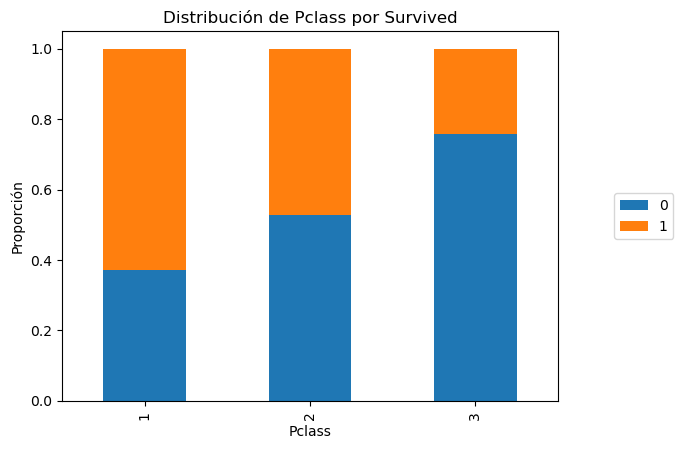

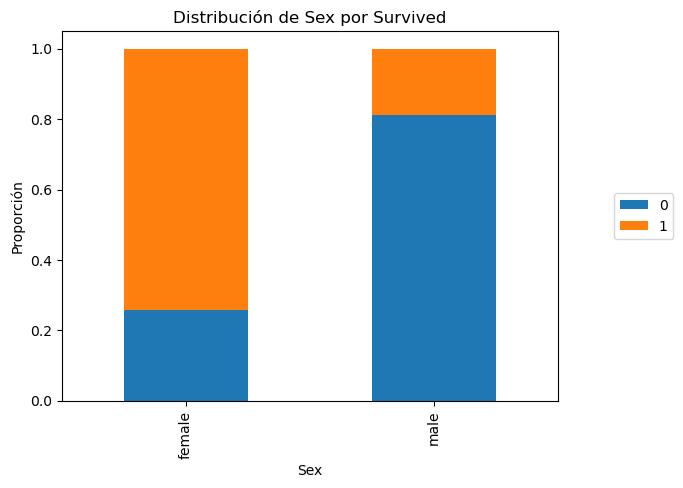

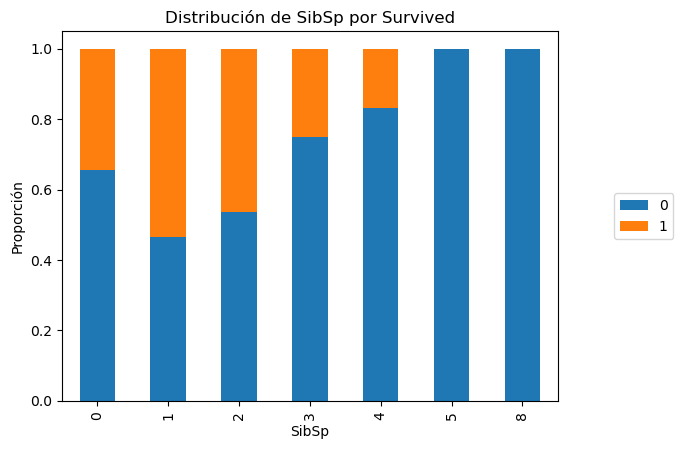

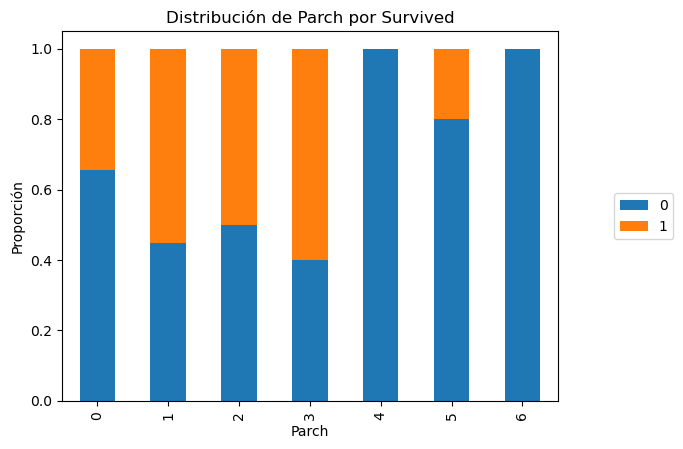

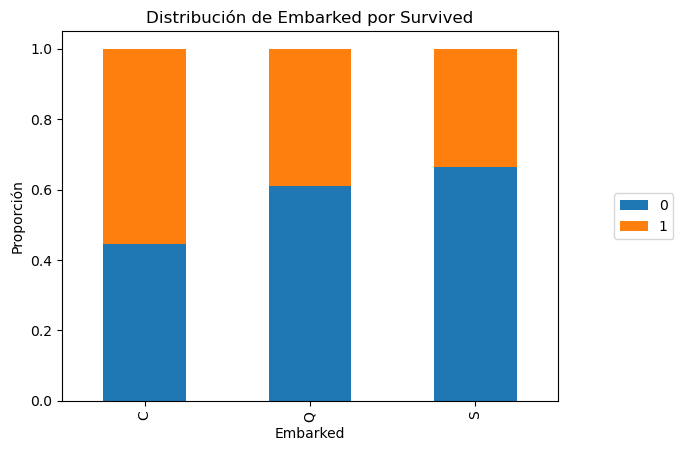

In [36]:
for var in cat_cols:
    if var != 'Survived':
        pd.crosstab(df[var], df["Survived"], normalize='index').plot(kind="bar", stacked=True)
        plt.legend(bbox_to_anchor=(1.1, 0.5), loc='center left')
        plt.title(f'Distribución de {var} por Survived') 
        plt.xlabel(var)  
        plt.ylabel('Proporción') 
        plt.show()  

### Análisis preliminar de la relación entre las clases de las variables continuas preliminares con la variable objetivo

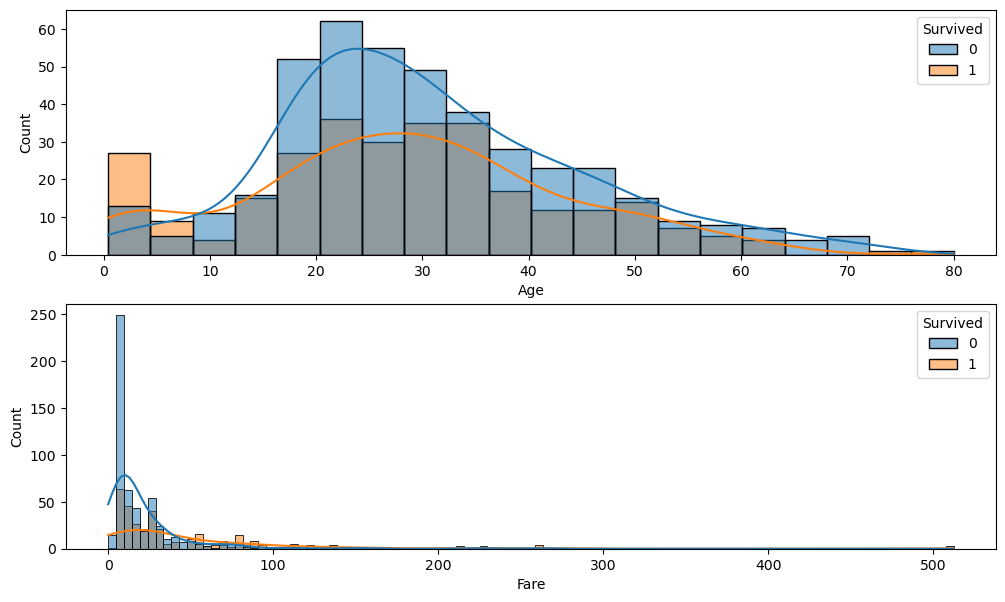

In [38]:
plt.figure(figsize=(12,7))
for i, var in enumerate(num_cols):
    plt.subplot(2, 1, i+1)
    sns.histplot(data = df, x = var, stat = "count", kde=True, hue='Survived');

### Análisis preliminar de correlaciones

In [40]:
corr_matrix = phik_matrix(df);

interval columns not set, guessing: ['PassengerId', 'Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare']


In [41]:
# Crear una máscara para el triángulo superior
mask = np.zeros_like(corr_matrix, dtype=bool)
mask[np.triu_indices_from(mask)] = True

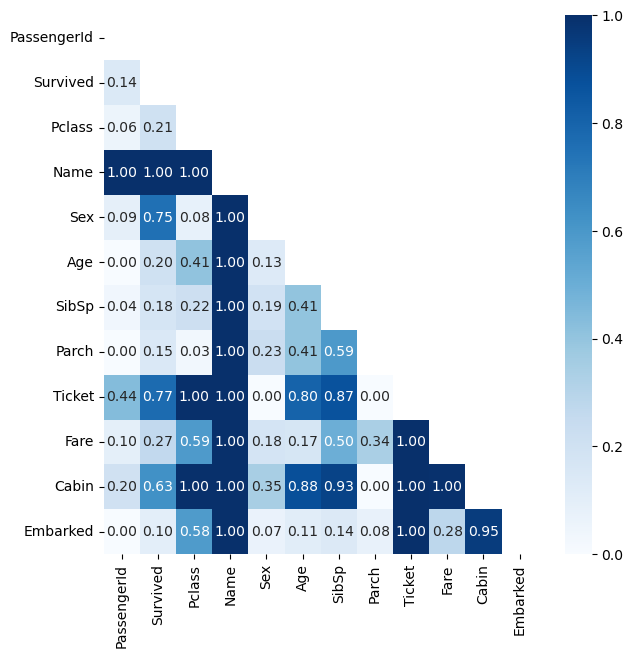

In [42]:
plt.figure(figsize=(7,7))
sns.heatmap(corr_matrix, annot=True, cmap='Blues', fmt='.2f', mask=mask);

## Separo el conjunto de datos en los conjuntos de entrenamiento y prueba

In [44]:
X = df.drop(columns = "Survived")
y = df.loc[:, ['Survived']]

In [45]:
X_train, X_test, y_train, y_test = train_test_split( X,y,test_size = 0.2,random_state = 42, stratify=y)

In [46]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 712 entries, 692 to 507
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  712 non-null    int64  
 1   Pclass       712 non-null    int64  
 2   Name         712 non-null    object 
 3   Sex          712 non-null    object 
 4   Age          575 non-null    float64
 5   SibSp        712 non-null    int64  
 6   Parch        712 non-null    int64  
 7   Ticket       712 non-null    object 
 8   Fare         712 non-null    float64
 9   Cabin        160 non-null    object 
 10  Embarked     710 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 66.8+ KB


In [47]:
X_train.shape

(712, 11)

In [48]:
X_test.shape

(179, 11)

## Ingeniería de datos

### Obtengo los títulos a partir de los nombres

In [51]:
X_train['Title'] = X_train['Name'].str.extract(r' ([A-Za-z]+)\.', expand=False)

In [52]:
X_train['Title']

692      Mr
481      Mr
527      Mr
855     Mrs
801     Mrs
       ... 
359    Miss
258    Miss
736     Mrs
462      Mr
507      Mr
Name: Title, Length: 712, dtype: object

In [53]:
X_train['Title'].value_counts(normalize = True)

Title
Mr          0.578652
Miss        0.198034
Mrs         0.150281
Master      0.043539
Dr          0.008427
Rev         0.007022
Col         0.002809
Mlle        0.002809
Major       0.001404
Lady        0.001404
Sir         0.001404
Ms          0.001404
Jonkheer    0.001404
Don         0.001404
Name: proportion, dtype: float64

In [54]:
X_test['Title'] = X_test['Name'].str.extract(r' ([A-Za-z]+)\.', expand=False)

In [55]:
X_test['Title'].value_counts(normalize = True)

Title
Mr          0.586592
Miss        0.229050
Mrs         0.100559
Master      0.050279
Major       0.005587
Mme         0.005587
Capt        0.005587
Countess    0.005587
Dr          0.005587
Rev         0.005587
Name: proportion, dtype: float64

In [56]:
# Clase para poder obtener el titulo a partir del la caracteristica nombre
class TitleExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, name_column='Name', title_column='Title'):
        # Columnas de entrada y salida
        self.name_column = name_column
        self.title_column = title_column

    def fit(self, X, y=None):
        # La clase no necesita ajuste
        return self

    def transform(self, X, y=None):
        # Crear una copia para evitar cambios en el DataFrame original
        X = X.copy()
        
        # Extraer el título de la columna 'Name' y crear la columna 'Title'
        X[self.title_column] = X[self.name_column].str.extract(r' ([A-Za-z]+)\.', expand=False)
        
        return X

In [57]:
# Para el pipeline
#('title_extractor', TitleExtractor(name_column='Name', title_column='Title')),

### Agrego una característica bivariable que identifica si los pasajeros viajaron solos o no

In [59]:
def add_is_alone(df):
    df['IsAlone'] = ((df['SibSp'] == 0) & (df['Parch'] == 0)).astype(int)
    return df

In [60]:
X_train = add_is_alone(X_train)
X_test = add_is_alone(X_test)

In [61]:
#Clase para caracteristica IsAlone 
class IsAloneFeatureExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, sibsp_column='SibSp', parch_column='Parch', is_alone_column='IsAlone'):
        # Columnas de entrada y salida
        self.sibsp_column = sibsp_column
        self.parch_column = parch_column
        self.is_alone_column = is_alone_column

    def fit(self, X, y=None):
        # No hay ajuste necesario
        return self

    def transform(self, X, y=None):
        # Crear una copia para evitar cambios en el DataFrame original
        X = X.copy()
        
        # Crear la columna IsAlone: 1 si el pasajero está solo, 0 si no lo está
        X[self.is_alone_column] = ((X[self.sibsp_column] == 0) & (X[self.parch_column] == 0)).astype(int)
        
        return X

In [62]:
# Para el pipeline
# ('is_alone_extractor', IsAloneFeatureExtractor(sibsp_column='SibSp', parch_column='Parch', is_alone_column='IsAlone')),

### Separo el código de las cabinas

In [64]:
X_train['Cabin_cat'] = X_train['Cabin'].str[0] # captures the first letter
X_train['Cabin_num'] = X_train['Cabin'].str.extract(r'(\d+)')  # captures numerical part

In [65]:
X_train[['Cabin', 'Cabin_cat', 'Cabin_num']].nunique()

Cabin        127
Cabin_cat      8
Cabin_num     84
dtype: int64

In [66]:
X_test['Cabin_cat'] = X_test['Cabin'].str[0] # captures the first letter
X_test['Cabin_num'] = X_test['Cabin'].str.extract(r'(\d+)')  # captures numerical part

In [67]:
X_test[['Cabin', 'Cabin_cat', 'Cabin_num']].nunique()

Cabin        41
Cabin_cat     6
Cabin_num    37
dtype: int64

In [68]:
X_train['Cabin_cat'].unique()

array([nan, 'C', 'A', 'D', 'E', 'F', 'B', 'G', 'T'], dtype=object)

In [69]:
X_test['Cabin_cat'].unique()

array([nan, 'B', 'C', 'F', 'E', 'D', 'A'], dtype=object)

In [70]:
# Combinar X_train con y_train para tener la columna 'Survived' en el mismo DataFrame
train_data = pd.concat([X_train, y_train], axis=1)

In [71]:
train_data['Cabin_cat'] = train_data['Cabin_cat'].fillna("no_cabin")

# Calcular el total de pasajeros por cada cabina
total_passengers_per_cabin = train_data.groupby('Cabin_cat').size().reset_index(name='Total Passengers')

# Calcular el total de sobrevivientes por cada cabina
survivors_per_cabin = train_data[train_data['Survived'] == 1].groupby('Cabin_cat').size().reset_index(name='Survivors')

# Combinar los dos DataFrames en uno solo para obtener el total de pasajeros y sobrevivientes por cabina
cabin_data = total_passengers_per_cabin.merge(survivors_per_cabin, on='Cabin_cat', how='left')

# Calcular el total de pasajeros en el conjunto de datos
total_passengers = train_data.shape[0]

# Calcular el porcentaje de pasajeros en cada cabina
cabin_data['Percentage of Passengers'] = (cabin_data['Total Passengers'] / total_passengers)


# Rellenar los valores nulos en 'Survivors' con 0 (en caso de cabinas sin sobrevivientes)
cabin_data['Survivors'] = cabin_data['Survivors'].fillna(0)

# Calcular la tasa de supervivencia por cabina
cabin_data['Survival Rate'] = cabin_data['Survivors'] / cabin_data['Total Passengers']

# Mostrar el resultado
cabin_data

,Cabin_cat,Total Passengers,Survivors,Percentage of Passengers,Survival Rate
0,A,14,6.0,0.019663,0.428571
1,B,34,25.0,0.047753,0.735294
2,C,41,28.0,0.057584,0.682927
3,D,26,21.0,0.036517,0.807692
4,E,29,22.0,0.040730,0.758621
5,F,11,8.0,0.015449,0.727273
6,G,4,2.0,0.005618,0.500000
7,T,1,0.0,0.001404,0.000000
8,no_cabin,552,161.0,0.775281,0.291667


Letra: Indica la sección del barco donde se encuentra la cabina. Las letras más comunes son:

- A: Cabinas de lujo en la parte superior del barco.
- B: Cabinas en la segunda clase.
- C: Cabinas en la tercera clase.
- D: Cabinas en la parte inferior o en la cubierta de carga.
- E: Cabinas en la parte de atrás o en la cubierta inferior.
- F: Generalmente cabinas en la parte más baja del barco.
- G: Suele referirse a cabinas de menor calidad o en áreas de servicio.

In [73]:
# Rellenar los valores nulos en 'Cabin_num' con "no_cabin"
train_data['Cabin_num'] = train_data['Cabin_num'].fillna("0")

# Calcular el total de pasajeros por cada número de cabina
total_passengers_per_cabin_num = train_data.groupby('Cabin_num').size().reset_index(name='Total Passengers')

# Calcular el total de sobrevivientes por cada número de cabina
survivors_per_cabin_num = train_data[train_data['Survived'] == 1].groupby('Cabin_num').size().reset_index(name='Survivors')

# Combinar los dos DataFrames en uno solo para obtener el total de pasajeros y sobrevivientes por número de cabina
cabin_num_data = total_passengers_per_cabin_num.merge(survivors_per_cabin_num, on='Cabin_num', how='left')

# Rellenar los valores nulos en 'Survivors' con 0 (en caso de cabinas sin sobrevivientes)
cabin_num_data['Survivors'] = cabin_num_data['Survivors'].fillna(0)

# Calcular el total de pasajeros en el conjunto de datos
total_passengers = train_data.shape[0]

# Calcular el porcentaje de pasajeros en cada número de cabina
cabin_num_data['Percentage of Passengers'] = (cabin_num_data['Total Passengers'] / total_passengers)

# Calcular la tasa de supervivencia por número de cabina
cabin_num_data['Survival Rate'] = cabin_num_data['Survivors'] / cabin_num_data['Total Passengers']

# Mostrar el resultado
cabin_num_data

,Cabin_num,Total Passengers,Survivors,Percentage of Passengers,Survival Rate
0,0,555,162.0,0.779494,0.291892
1,10,3,2.0,0.004213,0.666667
2,101,4,4.0,0.005618,1.000000
3,102,1,0.0,0.001404,0.000000
4,104,1,1.0,0.001404,1.000000
...,...,...,...,...,...
80,93,2,2.0,0.002809,1.000000
81,94,1,0.0,0.001404,0.000000
82,95,1,0.0,0.001404,0.000000
83,96,2,2.0,0.002809,1.000000


In [74]:
cabin_num_data['Cabin_num'] = cabin_num_data['Cabin_num'].astype('int')

In [75]:
cabin_num_data['Total Passengers'][cabin_num_data['Cabin_num'] > 100].sum()

17

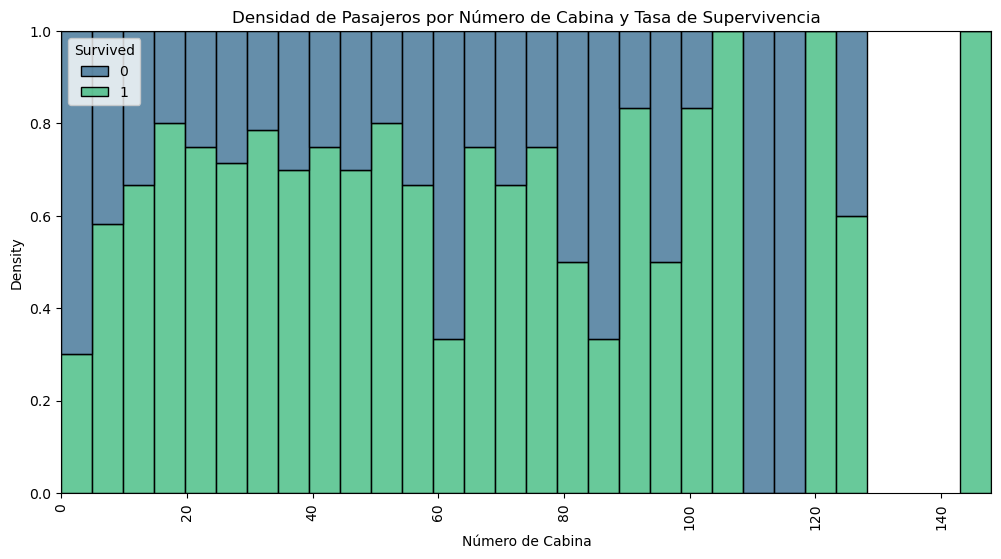

In [76]:
# Combinar train_data con cabin_num_data para incluir 'Survived'
combined_data = train_data[['Cabin_num', 'Survived']].copy()

# Asegúrate de que 'Cabin_num' sea del tipo entero
combined_data['Cabin_num'] = combined_data['Cabin_num'].fillna(0).astype(int)

# Crear el histograma con densidad
plt.figure(figsize=(12, 6))
sns.histplot(data=combined_data, x='Cabin_num', stat='density', 
             hue='Survived', multiple="fill", bins=30, palette='viridis')

# Configurar títulos y etiquetas
plt.title('Densidad de Pasajeros por Número de Cabina y Tasa de Supervivencia')
plt.xlabel('Número de Cabina')
plt.xticks(rotation=90)  # Rotar etiquetas del eje x si hay muchos números
plt.ylim(0, 1)  # Limitar el eje y entre 0 y 1

# Mostrar el gráfico
plt.show()

Número: Indica la ubicación específica de la cabina en la sección correspondiente. Cada número puede variar en el número de cabinas que hay en cada sección, y normalmente el número más bajo está más cerca del centro del barco

- Grupo 1: 0 (para las cabinas imputadas)
- Grupo 2: 1-50
- Grupo 3: 51-100
- Grupo 4: 101-148

In [79]:
# Clases

In [80]:
class CabinCategoryExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, cabin_column='Cabin', category_column='Cabin_cat'):
        # Columnas de entrada y salida
        self.cabin_column = cabin_column
        self.category_column = category_column

    def fit(self, X, y=None):
        # No hay ajuste necesario
        return self

    def transform(self, X, y=None):
        # Crear una copia para evitar cambios en el DataFrame original
        X = X.copy()
        
        # Capturar la primera letra de la columna 'Cabin'
        X[self.category_column] = X[self.cabin_column].str[0]
        
        return X

In [81]:
class CabinNumberExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, cabin_column='Cabin', number_column='Cabin_num'):
        # Columnas de entrada y salida
        self.cabin_column = cabin_column
        self.number_column = number_column

    def fit(self, X, y=None):
        # No hay ajuste necesario
        return self

    def transform(self, X, y=None):
        # Crear una copia para evitar cambios en el DataFrame original
        X = X.copy()
        
        # Capturar la parte numérica de la columna 'Cabin'
        X[self.number_column] = X[self.cabin_column].str.extract(r'(\d+)', expand=False)
                
        return X

In [82]:
# Para el pipeline
# ('cabin_category_extractor', CabinCategoryExtractor(cabin_column='Cabin', category_column='Cabin_cat')),
# ('cabin_number_extractor', CabinNumberExtractor(cabin_column='Cabin', number_column='Cabin_num')),

#### Antes de poder agrupar las categorías de las cabinas y discretizar los números de las cabinas, es necesario imputar los valores nulos

### Elimino las características que no tienen poder predictivo o que se han vuelto redundantes

In [85]:
drop_features_transformer = DropFeatures(features_to_drop=['Name', 'Cabin', 'Ticket', 'PassengerId'])

In [86]:
X_train = drop_features_transformer.fit_transform(X_train)
X_test = drop_features_transformer.transform(X_test)

In [87]:
X_train.dtypes

Pclass         int64
Sex           object
Age          float64
SibSp          int64
Parch          int64
Fare         float64
Embarked      object
Title         object
IsAlone        int32
Cabin_cat     object
Cabin_num     object
dtype: object

In [88]:
# Para el pipeline no es necesario crear una clase 
# ('drop_features', DropFeatures(features_to_drop=['Name', 'Cabin', 'Ticket', 'PassengerId'])),

### Análisis para la imputación de valores nulos

In [90]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 712 entries, 692 to 507
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Pclass     712 non-null    int64  
 1   Sex        712 non-null    object 
 2   Age        575 non-null    float64
 3   SibSp      712 non-null    int64  
 4   Parch      712 non-null    int64  
 5   Fare       712 non-null    float64
 6   Embarked   710 non-null    object 
 7   Title      712 non-null    object 
 8   IsAlone    712 non-null    int32  
 9   Cabin_cat  160 non-null    object 
 10  Cabin_num  157 non-null    object 
dtypes: float64(2), int32(1), int64(3), object(5)
memory usage: 64.0+ KB


In [91]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 179 entries, 565 to 637
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Pclass     179 non-null    int64  
 1   Sex        179 non-null    object 
 2   Age        139 non-null    float64
 3   SibSp      179 non-null    int64  
 4   Parch      179 non-null    int64  
 5   Fare       179 non-null    float64
 6   Embarked   179 non-null    object 
 7   Title      179 non-null    object 
 8   IsAlone    179 non-null    int32  
 9   Cabin_cat  44 non-null     object 
 10  Cabin_num  43 non-null     object 
dtypes: float64(2), int32(1), int64(3), object(5)
memory usage: 16.1+ KB


In [92]:
vars_with_na = [var for var in X_train.columns if X_train[var].isnull().sum() > 0]

In [93]:
X_train[vars_with_na].isnull().sum().sort_values(ascending=False)

Cabin_num    555
Cabin_cat    552
Age          137
Embarked       2
dtype: int64

In [94]:
cat_cols = X_train.select_dtypes(include=['category', 'object']).columns
num_cols = X_train.select_dtypes(include=['int', 'float']).columns

In [95]:
cat_na = [var for var in cat_cols if var in vars_with_na]
num_na = [var for var in num_cols if var in vars_with_na]

print('Number of categorical variables with na: ', len(cat_na))
print('Number of numerical variables with na: ', len(num_na))

Number of categorical variables with na:  3
Number of numerical variables with na:  1


In [96]:
cat_na

['Embarked', 'Cabin_cat', 'Cabin_num']

In [97]:
num_na

['Age']

#### Relación de los nulos con la supervivencia

In [99]:
def analyse_na_survival(df, var):
    # Copia del dataframe para no modificar el original
    df = df.copy()

    
    # Nos aseguramos de que 'Survived' sea numérico
    df['Survived'] = pd.to_numeric(df['Survived'], errors='coerce')

    
    # Creamos una variable temporal que indica 1 si el valor es nulo y 0 si no
    df[var + '_na'] = np.where(df[var].isnull(), 1, 0)

    # Calculamos la tasa de supervivencia para ambos grupos (nulos y no nulos)
    survival_rates = df.groupby(var + '_na')['Survived'].mean()
    
    # Creamos un DataFrame temporal para almacenar los resultados
    tmp = pd.DataFrame({'Survival_Rate': survival_rates, 'Count': df.groupby(var + '_na')['Survived'].count()})

    # Graficamos los resultados
    tmp['Survival_Rate'].plot(kind='barh', legend=False, title='Tasa de Supervivencia por Nulos en ' + var, color='skyblue')
    plt.xlabel('Tasa de Supervivencia')
    plt.ylabel('Nulos (1) / No Nulos (0)')
    plt.axvline(0.5, color='red', linestyle='--')  # Línea de referencia
    plt.show()


In [100]:
train_data = pd.concat([X_train, y_train], axis=1)
test_data = pd.concat([X_test, y_test], axis=1)
data = pd.concat([train_data, test_data], axis=0)

In [101]:
data.shape

(891, 12)

In [102]:
data.isnull().sum()

Pclass         0
Sex            0
Age          177
SibSp          0
Parch          0
Fare           0
Embarked       2
Title          0
IsAlone        0
Cabin_cat    687
Cabin_num    691
Survived       0
dtype: int64

In [103]:
def analyse_na_survival(df, var):
    # Copia del dataframe para no modificar el original
    df = df.copy()

    # Nos aseguramos de que 'Survived' sea numérico
    df['Survived'] = pd.to_numeric(df['Survived'], errors='coerce')

    # Calculamos la tasa de supervivencia promedio de todo el conjunto de datos
    overall_survival_rate = df['Survived'].mean()

    # Creamos una variable temporal que indica 1 si el valor es nulo y 0 si no
    df[var + '_na'] = np.where(df[var].isnull(), 1, 0)

    # Calculamos la tasa de supervivencia para ambos grupos (nulos y no nulos)
    survival_rates = df.groupby(var + '_na')['Survived'].mean()

    # Creamos un DataFrame temporal para almacenar los resultados
    tmp = pd.DataFrame({
        'Survival_Rate': survival_rates,
        'Count': df.groupby(var + '_na')['Survived'].count()
    })

    # Graficamos los resultados
    ax = tmp['Survival_Rate'].plot(kind='barh', legend=False, title='Tasa de Supervivencia por Nulos en ' + var, color='skyblue')
    plt.xlabel('Tasa de Supervivencia')
    plt.ylabel('Nulos (1) / No Nulos (0)')
    
    # Línea de referencia para la tasa de supervivencia general
    plt.axvline(overall_survival_rate, color='red', linestyle='--', label=f'Tasa de Supervivencia Promedio: {overall_survival_rate:.2f}')
    
    # Colocamos las etiquetas de las barras a la derecha de cada barra
    for index, value in enumerate(tmp['Survival_Rate']):
        ax.text(value + 0.02, index, f'{value:.2f}', va='center')

    # Mostrar leyenda
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.show()

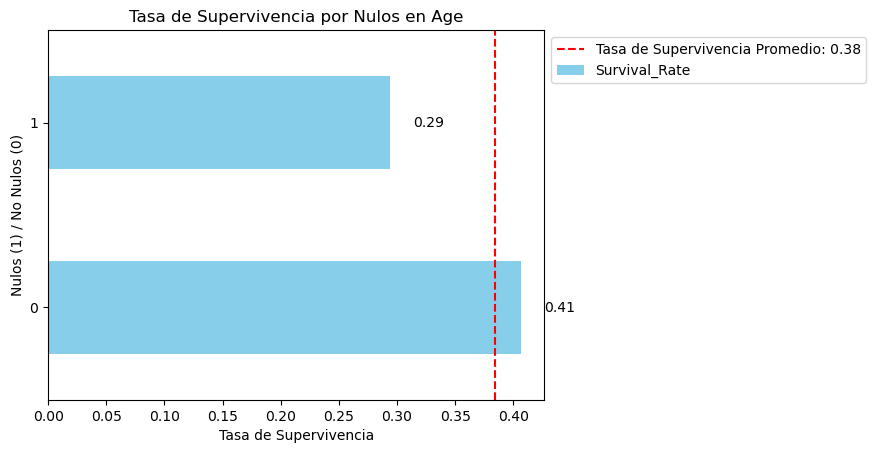

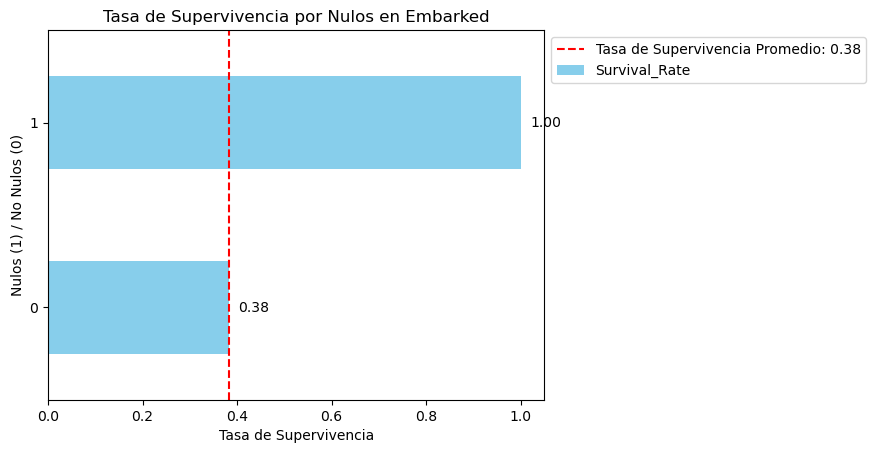

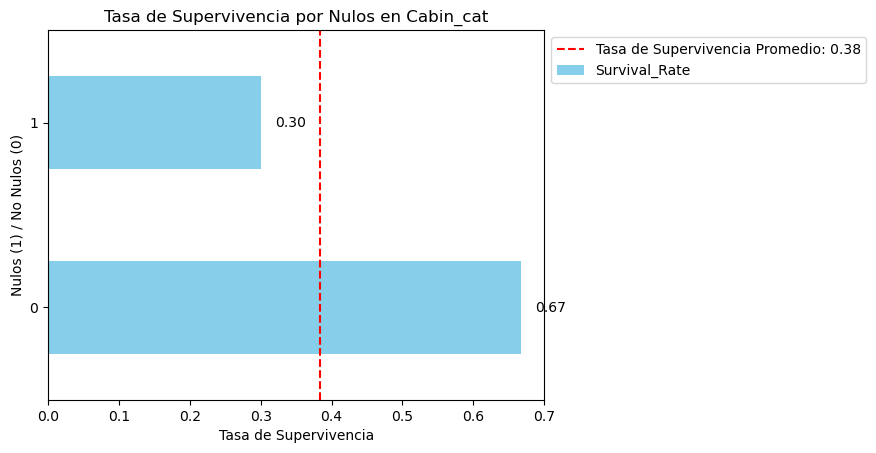

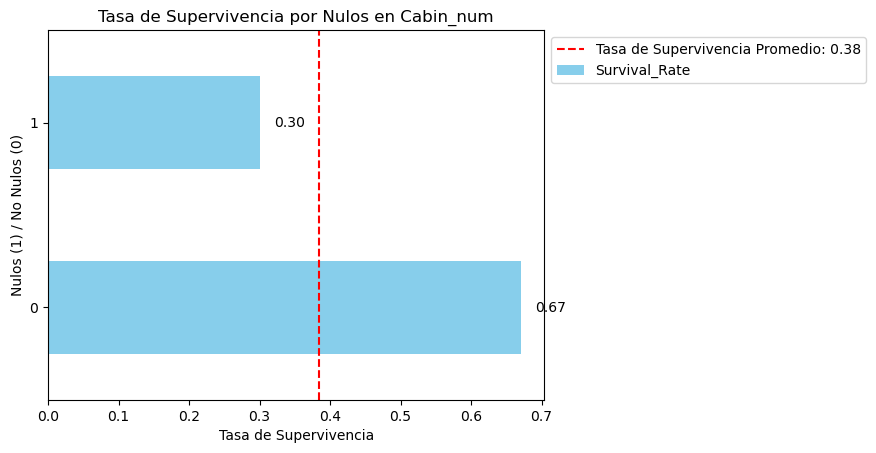

In [104]:
for var in vars_with_na:
    analyse_na_survival(data, var)

##### En el conjunto de entrenamiento, las características con valores nulos muestran tasas promedio de supervivencia diferentes entre las filas con datos faltantes y las que no. Esto sugiere que los valores nulos probablemente poseen un poder predictivo significativo

#### Imputación de valores nulos para las cabinas y el lugar de embarque

In [108]:
# Configuración de imputadores específicos para cada columna
imputer_cabin_cat = CategoricalImputer(imputation_method="missing", fill_value="Missing", variables=['Cabin_cat'])
imputer_cabin_num = CategoricalImputer(imputation_method="missing", fill_value="0", variables=['Cabin_num'])
imputer_embarked = CategoricalImputer(imputation_method="frequent", variables=['Embarked'])

In [109]:
# Agregar los imputadores de manera secuencial en un Pipeline
imputer_pipeline = Pipeline([
    ('impute_cabin_cat', imputer_cabin_cat),
    ('impute_cabin_num', imputer_cabin_num),
    ('impute_embarked', imputer_embarked)
])

In [110]:
imputer_pipeline.fit(X_train)  

Pipeline(steps=[('impute_cabin_cat',
                 CategoricalImputer(variables=['Cabin_cat'])),
                ('impute_cabin_num',
                 CategoricalImputer(fill_value='0', variables=['Cabin_num'])),
                ('impute_embarked',
                 CategoricalImputer(imputation_method='frequent',
                                    variables=['Embarked']))])

In [111]:
# Ajuste e imputación en el conjunto de entrenamiento y transformación en DataFrame
X_train_imputed = pd.DataFrame(imputer_pipeline.fit_transform(X_train), columns=X_train.columns, index=X_train.index)

# Transformación del conjunto de prueba y conversión en DataFrame
X_test_imputed = pd.DataFrame(imputer_pipeline.transform(X_test), columns=X_test.columns, index=X_test.index)

In [112]:
X_train_imputed.isnull().sum()

Pclass         0
Sex            0
Age          137
SibSp          0
Parch          0
Fare           0
Embarked       0
Title          0
IsAlone        0
Cabin_cat      0
Cabin_num      0
dtype: int64

In [113]:
X_train_imputed

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,IsAlone,Cabin_cat,Cabin_num
692,3,male,NaN,0,0,56.4958,S,Mr,1,Missing,0
481,2,male,NaN,0,0,0.0000,S,Mr,1,Missing,0
527,1,male,NaN,0,0,221.7792,S,Mr,1,C,95
855,3,female,18.0,0,1,9.3500,S,Mrs,0,Missing,0
801,2,female,31.0,1,1,26.2500,S,Mrs,0,Missing,0
...,...,...,...,...,...,...,...,...,...,...,...
359,3,female,NaN,0,0,7.8792,Q,Miss,1,Missing,0
258,1,female,35.0,0,0,512.3292,C,Miss,1,Missing,0
736,3,female,48.0,1,3,34.3750,S,Mrs,0,Missing,0
462,1,male,47.0,0,0,38.5000,S,Mr,1,E,63


In [114]:
X_test_imputed.isnull().sum()

Pclass        0
Sex           0
Age          40
SibSp         0
Parch         0
Fare          0
Embarked      0
Title         0
IsAlone       0
Cabin_cat     0
Cabin_num     0
dtype: int64

In [115]:
X_test_imputed.shape

(179, 11)

In [116]:
X_train.dtypes

Pclass         int64
Sex           object
Age          float64
SibSp          int64
Parch          int64
Fare         float64
Embarked      object
Title         object
IsAlone        int32
Cabin_cat     object
Cabin_num     object
dtype: object

In [117]:
# Para el pipeline
# ('impute_cabin_cat', CategoricalImputer(imputation_method="missing", fill_value="Missing", variables=['Cabin_cat'])),
# ('impute_cabin_num', CategoricalImputer(imputation_method="missing", fill_value="0", variables=['Cabin_num'])),
# ('impute_embarked', CategoricalImputer(imputation_method="frequent", variables=['Embarked'])),

##### Una vez imputados los valores donde habia nulos en Cabin_cat, Cabin_num y Title es necesario convertir los tipos de datos para luego poder agrupar, discretizar y/o convertir las caracteristicas en dummies con one hot encoder

### Transformo los tipos de datos

In [120]:
X_train_imputed['Cabin_cat'] = X_train_imputed['Cabin_cat'].astype('category')
X_train_imputed['Title'] = X_train_imputed['Title'].astype('category')
X_train_imputed['Cabin_num'] = X_train_imputed['Cabin_num'].astype('int32')
X_train_imputed['Embarked'] = X_train_imputed['Embarked'].astype('category')
X_train_imputed['Sex'] = X_train_imputed['Sex'].astype('category')
X_train_imputed['Pclass'] = X_train_imputed['Pclass'].astype('category')

In [121]:
X_test_imputed['Cabin_cat'] = X_test_imputed['Cabin_cat'].astype('category')
X_test_imputed['Title'] = X_test_imputed['Title'].astype('category')
X_test_imputed['Cabin_num'] = X_test_imputed['Cabin_num'].astype('int32')
X_test_imputed['Embarked'] = X_test_imputed['Embarked'].astype('category')
X_test_imputed['Sex'] = X_test_imputed['Sex'].astype('category')
X_test_imputed['Pclass'] = X_test_imputed['Pclass'].astype('category')

In [122]:
X_train_imputed.dtypes

Pclass       category
Sex          category
Age           float64
SibSp           int64
Parch           int64
Fare          float64
Embarked     category
Title        category
IsAlone         int32
Cabin_cat    category
Cabin_num       int32
dtype: object

In [123]:
class DType_first_Converter(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = X.copy()  # Evitar modificar el original

        X['Cabin_cat'] = X['Cabin_cat'].astype('object') # De esta manera podemos mapear sus valores
        X['Title'] = X['Title'].astype('category')
        X['Cabin_num'] = X['Cabin_num'].astype('int32')
        X['Embarked'] = X['Embarked'].astype('category')
        X['Sex'] = X['Sex'].astype('category')
        X['Pclass'] = X['Pclass'].astype('category')
               
        return X

In [124]:
# Para el pipeline
# ('dtype_fisrt_converter', DType_first_Converter()),

### Recategorización de las categorías y números de cabinas

In [126]:
X_train_imputed['Cabin_num'].unique()

array([  0,  95,  26,  78,  15,  49,  52, 104,   5,  73,  44,  96,  30,
        45,   6,  70,  57,  80,  69, 106,   8,   9,  68,  17,  58, 125,
        18,  83,   3,  33,  92, 121,  22,  23,  67,  35,  85,   2,  12,
        14,  86,  10,  47,  91,  62,  65, 101,   7,  31,  11, 102, 124,
        82,   4,  34, 110,  19,  42,  16,  94,  50,  99, 118,  46,  39,
        37,  20,  24,  56,  25,  36, 126,  32,  90,  38,  28,  93,  63,
        21,  77, 123,  40,  54,  51, 148])

In [127]:
freq_cat_cab = X_train_imputed.groupby(['Cabin_cat'], observed = False).size().reset_index(name='Count')
freq_cat_cab['Relative Frequency'] = freq_cat_cab['Count'] / sum(freq_cat_cab['Count'])
freq_cat_cab

,Cabin_cat,Count,Relative Frequency
0,A,14,0.019663
1,B,34,0.047753
2,C,41,0.057584
3,D,26,0.036517
4,E,29,0.040730
5,F,11,0.015449
6,G,4,0.005618
7,Missing,552,0.775281
8,T,1,0.001404


In [128]:
def recategorize_cabins(df):
    cabin_mapping = {
        'A': 'Cabina_Lujo',
        'B': 'Cabinas_clase_media',
        'C': 'Cabinas_clase_media',
        'D': 'Cabinas_clase_media_baja',
        'E': 'Cabinas_clase_media_baja',
        'F': 'Cabinas_economicas',
        'G': 'Cabinas_economicas',
        'T': 'Cabinas_economicas',
        'Missing': 'Missing'
    }
    df['Cabin_category'] = df['Cabin_cat'].map(cabin_mapping)
    return df

In [129]:
# Crear un FunctionTransformer con la función definida
recategorizer = FunctionTransformer(recategorize_cabins, validate=False)

In [130]:
X_train_imputed_recat = recategorizer.fit_transform(X_train_imputed)
X_test_imputed_recat = recategorizer.transform(X_test_imputed)

In [131]:
X_train_imputed_recat.head(4)

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,IsAlone,Cabin_cat,Cabin_num,Cabin_category
692,3,male,NaN,0,0,56.4958,S,Mr,1,Missing,0,Missing
481,2,male,NaN,0,0,0.0000,S,Mr,1,Missing,0,Missing
527,1,male,NaN,0,0,221.7792,S,Mr,1,C,95,Cabinas_clase_media
855,3,female,18.0,0,1,9.3500,S,Mrs,0,Missing,0,Missing


In [132]:
X_test_imputed_recat.isnull().sum()

Pclass             0
Sex                0
Age               40
SibSp              0
Parch              0
Fare               0
Embarked           0
Title              0
IsAlone            0
Cabin_cat          0
Cabin_num          0
Cabin_category     0
dtype: int64

In [133]:
X_train_imputed_recat = X_train_imputed_recat.drop(columns = 'Cabin_cat')
X_test_imputed_recat = X_test_imputed_recat.drop(columns = 'Cabin_cat');

In [134]:
class CabinRecategorizer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.cabin_mapping = {
            'A': 'Cabina_Lujo',
            'B': 'Cabinas_clase_media',
            'C': 'Cabinas_clase_media',
            'D': 'Cabinas_clase_media_baja',
            'E': 'Cabinas_clase_media_baja',
            'F': 'Cabinas_economicas',
            'G': 'Cabinas_economicas',
            'T': 'Cabinas_economicas',
            'Missing': 'Missing' 
        }
    
    def fit(self, X, y=None):
        return self  # No necesita ajuste, solo transformación

    def transform(self, X):
        X = X.copy()  # Evitar modificar el DataFrame original
        # Usar fillna para asegurar que no haya NaN antes de aplicar el mapeo
        X['Cabin_category'] = X['Cabin_cat'].fillna('Missing').map(self.cabin_mapping).astype('category')
        return X

In [135]:
# Para el pipeline
# ('cabin_recategorizer', CabinRecategorizer()),
# Despues hay que eliminar Cabin_cat

##### Agrupamiento arbitrario de los numeros de las cabinas
- Grupo 1: 0 (para los numeros de las cabinas que tenían valores nulos)
- Grupo 2: 1-50
- Grupo 3: 51-100
- Grupo 4: 101-148

In [137]:
# Creamos el discretizador
discretiser = ArbitraryDiscretiser(
    binning_dict= {
    "Cabin_num": [0, 1, 50, 100, np.inf]  # Definimos los grupos para Cabin_num
    }
)

In [138]:
# Aplicamos el discretizador al DataFrame
X_train_imputed_recat2 = discretiser.fit_transform(X_train_imputed_recat)
X_test_imputed_recat2 = discretiser.transform(X_test_imputed_recat)

In [139]:
X_train_imputed_recat2['Cabin_num'].unique()

array([0, 2, 1, 3], dtype=int64)

In [140]:
# Clase que discretariza los números de las cabinas y convierte a tipo categórico
class CustomCabinNumDiscretiser(BaseEstimator, TransformerMixin):
    def __init__(self, binning_dict=None):
        if binning_dict is None:
            self.binning_dict = {"Cabin_num": [0, 1, 50, 100, np.inf]}
        else:
            self.binning_dict = binning_dict

    def fit(self, X, y=None):
        return self  # No necesitamos ajustar nada aquí

    def transform(self, X):
        X = X.copy()  # Evitar modificar el original
        
        for feature, bins in self.binning_dict.items():
            # Discretizar usando pd.cut y devolver enteros como etiquetas
            X[feature] = pd.cut(X[feature], bins=bins, labels=range(len(bins)-1), include_lowest=True)

        # Convertir a tipo entero
        for feature in self.binning_dict.keys():
            X[feature] = X[feature].astype(int)
        
        return X

In [141]:
# Para el pipeline
# ('cabin_discretiser', CustomCabinNumDiscretiser()),

### Modifico los nombres de las clases de las cabinas

In [143]:
# Cambiamos las etiquetas a las que deseas
X_train_imputed_recat2['Cabin_num'] = X_train_imputed_recat2['Cabin_num'].map({
    0: 'Missing',
    1: 'Cabinas_Centro',
    2: 'Cabinas_mitad',
    3: 'Cabinas_extremos'
})

In [144]:
X_test_imputed_recat2['Cabin_num'] = X_test_imputed_recat2['Cabin_num'].map({
    0: 'Missing',
    1: 'Cabinas_Centro',
    2: 'Cabinas_mitad',
    3: 'Cabinas_extremos'
})

In [145]:
class CabinNumMapper(BaseEstimator, TransformerMixin):
    def __init__(self, mapping=None):
        # Diccionario de mapeo
        if mapping is None:
            self.mapping = {
                0: 'Missing',
                1: 'Cabinas_Centro',
                2: 'Cabinas_mitad',
                3: 'Cabinas_extremos'
            }
        else:
            self.mapping = mapping

    def fit(self, X, y=None):
        return self  # No necesita ajuste

    def transform(self, X):
        X = X.copy()  # Evitar modificar el original
        # Mapear los valores a las categorías
        X['Cabin_num'] = X['Cabin_num'].map(self.mapping)
        return X

In [146]:
# Para el pipeline
# ('cabin_num_mapper', CabinNumMapper()),

### Agrupamiento de títulos raros

In [148]:
X_train_imputed_recat2['Title'].value_counts(normalize = True)

Title
Mr          0.578652
Miss        0.198034
Mrs         0.150281
Master      0.043539
Dr          0.008427
Rev         0.007022
Col         0.002809
Mlle        0.002809
Don         0.001404
Jonkheer    0.001404
Lady        0.001404
Major       0.001404
Ms          0.001404
Sir         0.001404
Name: proportion, dtype: float64

In [149]:
rare_encoder = RareLabelEncoder(
    tol=0.04,  # minimal percentage to be considered non-rare
    n_categories=4,  # minimal number of categories the variable should have to re-cgroup rare categories
    variables=[
        "Title"
    ],
    replace_with='Rare_Title',
)

In [150]:
rare_encoder.fit(X_train_imputed_recat2)

RareLabelEncoder(n_categories=4, replace_with='Rare_Title', tol=0.04,
                 variables=['Title'])

In [151]:
rare_encoder.encoder_dict_

{'Title': ['Mr', 'Miss', 'Mrs', 'Master']}

In [152]:
X_train_imputed_recat3 = rare_encoder.transform(X_train_imputed_recat2)
X_test_imputed_recat3 = rare_encoder.transform(X_test_imputed_recat2)

In [153]:
# No hace falta crear una clase para esta transformacion
# Para el pipeline
# ('rare_encoder', RareLabelEncoder(tol=0.04, n_categories=4, variables=["Title"], replace_with='Rare_Title')),

### Agrupo por cantidad de acompañantes

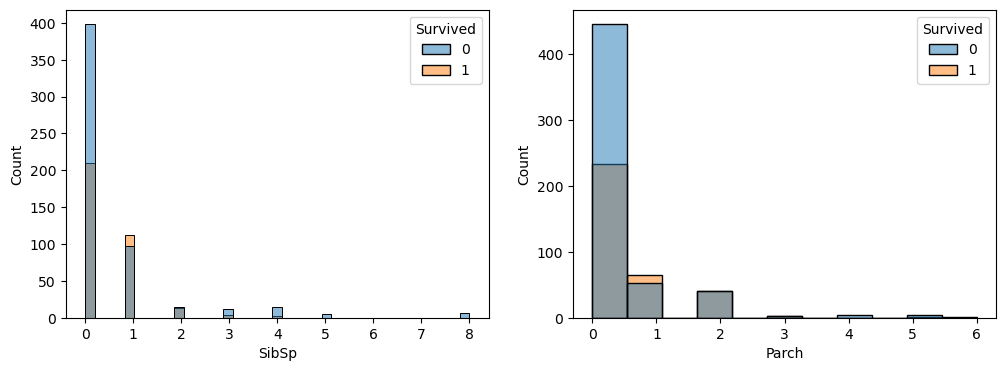

In [155]:
plt.figure(figsize=(12,4))
for i, var in enumerate(['SibSp', 'Parch']):
    plt.subplot(1, 2, i+1)
    sns.histplot(data = data, x = var, stat = "count", kde=False, hue='Survived');

In [156]:
print(X_train_imputed_recat3['Parch'].nunique())
print(X_test_imputed_recat3['Parch'].nunique())
print(X_train_imputed_recat3['SibSp'].nunique())
print(X_test_imputed_recat3['SibSp'].nunique())

7
3
7
7


In [157]:
disc = ArbitraryDiscretiser(
    binning_dict = {
        "SibSp": [0, 0.9, 1.9, 2.9, np.inf],
        "Parch": [0, 0.9, 1.9, 2.9, np.inf]},
)

In [158]:
# Ajustar el discretizador a tus datos
X_discretized = disc.fit_transform(X_train_imputed_recat3)

In [159]:
X_discretized_test = disc.transform(X_test_imputed_recat3)

In [160]:
# Verifico los indices
X_discretized.head(4)

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,IsAlone,Cabin_num,Cabin_category
692,3,male,NaN,0,0,56.4958,S,Mr,1,Missing,Missing
481,2,male,NaN,0,0,0.0000,S,Mr,1,Missing,Missing
527,1,male,NaN,0,0,221.7792,S,Mr,1,Cabinas_mitad,Cabinas_clase_media
855,3,female,18.0,0,1,9.3500,S,Mrs,0,Missing,Missing


In [161]:
# Clase para discretizar por la cantidad de familiares
class CustomDiscretiser(BaseEstimator, TransformerMixin):
    def __init__(self, binning_dict=None):
        if binning_dict is None:
            self.binning_dict = {
                "SibSp": [0, 0.9, 1.9, 2.9, np.inf],
                "Parch": [0, 0.9, 1.9, 2.9, np.inf]
            }
        else:
            self.binning_dict = binning_dict

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()  # Evitar modificar el original
        # Aplicar discretización
        for feature, bins in self.binning_dict.items():
            X[feature] = pd.cut(X[feature], bins=bins, labels=False, include_lowest=True)  # Devolver índices en lugar de etiquetas
        return X

In [162]:
# Para el pipeline
# ('family_discretiser', CustomDiscretiser()),

### Cambio el nombre de las clases discretizadas de SibSp y Parch

In [164]:
# Cambiar los nombres de los bins después de la discretización
# Suponiendo que `X_discretized` tiene las columnas 'SibSp' y 'Parch'
X_discretized['SibSp'] = X_discretized['SibSp'].replace({0: 'Sin hermanos', 1: '1 hermano', 2: '2 hermanos', 3:'3 o más hermanos'})
X_discretized['Parch'] = X_discretized['Parch'].replace({0: 'Sin padres/hijos', 1: '1 padre/hijo', 2: '2 padres/hijos', 3: '3 o más padres/hijos'})


In [165]:
# Cambiar los nombres de los bins después de la discretización
# Suponiendo que `X_discretized_test` tiene las columnas 'SibSp' y 'Parch'
X_discretized_test['SibSp'] = X_discretized_test['SibSp'].replace({0: 'Sin hermanos', 1: '1 hermano', 2: '2 hermanos', 3: '3 o más hermanos'})
X_discretized_test['Parch'] = X_discretized_test['Parch'].replace({0: 'Sin padres/hijos', 1: '1 padre/hijo', 2: '2 padres/hijos', 3: '3 o más padres/hijos'})


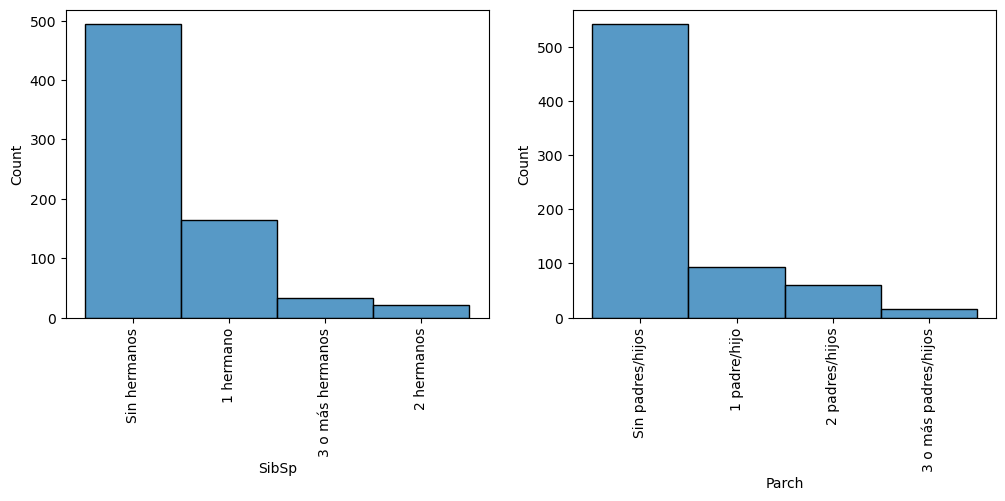

In [166]:
plt.figure(figsize=(12,4))
for i, var in enumerate(['SibSp', 'Parch']):
    plt.subplot(1, 2, i+1)
    sns.histplot(data = X_discretized, x = var)
    plt.xticks(rotation=90);

In [167]:
# Clase para mapear tamaños de familia a categorías descriptivas
class FamilySizeMapper(BaseEstimator, TransformerMixin):
    def __init__(self):
        # Diccionarios de mapeo
        self.sibsp_mapping = {
            0: 'Sin hermanos',
            1: '1 hermano',
            2: '2 hermanos',
            3: '3 o más hermanos',
            4: '3 o más hermanos'  # Puedes ajustar o eliminar esta línea según sea necesario
        }
        self.parch_mapping = {
            0: 'Sin padres/hijos',
            1: '1 padre/hijo',
            2: '2 padres/hijos',
            3: '3 o más padres/hijos',
            4: '3 o más padres/hijos'  # Igual aquí, ajuste según necesidad
        }

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()  # Evitar modificar el original
        # Reemplazar enteros por categorías
        X['SibSp'] = X['SibSp'].replace(self.sibsp_mapping).astype('category')
        X['Parch'] = X['Parch'].replace(self.parch_mapping).astype('category')
        return X


In [168]:
# Para el pipeline
# ('family_mapper', FamilySizeMapper()), 

### Transformo las clases de las categorías en variables dummy

In [170]:
cat_cols = X_discretized.select_dtypes(include=['category','object']).columns
cat_cols_list = cat_cols.tolist()
cat_cols_list

['Pclass',
 'Sex',
 'SibSp',
 'Parch',
 'Embarked',
 'Title',
 'Cabin_num',
 'Cabin_category']

In [171]:
encoder = OneHotEncoder(
    drop = "first",   #if_binary
    sparse_output = False,
    handle_unknown = "infrequent_if_exist",  # helps deal with rare labels
    dtype = "int"
).set_output(transform="pandas")

In [172]:
# encoder.set_output(transform="pandas")

In [173]:
X_train_enc = encoder.fit_transform(X_discretized[cat_cols_list])

In [174]:
X_train_enc_test = encoder.transform(X_discretized_test[cat_cols_list])

In [175]:
X_train_enc.info()

<class 'pandas.core.frame.DataFrame'>
Index: 712 entries, 692 to 507
Data columns (total 22 columns):
 #   Column                                   Non-Null Count  Dtype
---  ------                                   --------------  -----
 0   Pclass_2                                 712 non-null    int32
 1   Pclass_3                                 712 non-null    int32
 2   Sex_male                                 712 non-null    int32
 3   SibSp_2 hermanos                         712 non-null    int32
 4   SibSp_3 o más hermanos                   712 non-null    int32
 5   SibSp_Sin hermanos                       712 non-null    int32
 6   Parch_2 padres/hijos                     712 non-null    int32
 7   Parch_3 o más padres/hijos               712 non-null    int32
 8   Parch_Sin padres/hijos                   712 non-null    int32
 9   Embarked_Q                               712 non-null    int32
 10  Embarked_S                               712 non-null    int32
 11  Title_Mis

In [176]:
X_train_enc_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 179 entries, 565 to 637
Data columns (total 22 columns):
 #   Column                                   Non-Null Count  Dtype
---  ------                                   --------------  -----
 0   Pclass_2                                 179 non-null    int32
 1   Pclass_3                                 179 non-null    int32
 2   Sex_male                                 179 non-null    int32
 3   SibSp_2 hermanos                         179 non-null    int32
 4   SibSp_3 o más hermanos                   179 non-null    int32
 5   SibSp_Sin hermanos                       179 non-null    int32
 6   Parch_2 padres/hijos                     179 non-null    int32
 7   Parch_3 o más padres/hijos               179 non-null    int32
 8   Parch_Sin padres/hijos                   179 non-null    int32
 9   Embarked_Q                               179 non-null    int32
 10  Embarked_S                               179 non-null    int32
 11  Title_Mis

In [177]:
X_prepro1 = X_discretized.drop(columns = cat_cols_list) 
X_prepro1 = pd.concat([X_prepro1, X_train_enc], axis= 1)
X_prepro1

,Age,Fare,IsAlone,Pclass_2,Pclass_3,Sex_male,SibSp_2 hermanos,SibSp_3 o más hermanos,SibSp_Sin hermanos,Parch_2 padres/hijos,...,Title_Mr,Title_Mrs,Title_Rare_Title,Cabin_num_Cabinas_extremos,Cabin_num_Cabinas_mitad,Cabin_num_Missing,Cabin_category_Cabinas_clase_media,Cabin_category_Cabinas_clase_media_baja,Cabin_category_Cabinas_economicas,Cabin_category_Missing
692,NaN,56.4958,1,0,1,1,0,0,1,0,...,1,0,0,0,0,1,0,0,0,1
481,NaN,0.0000,1,1,0,1,0,0,1,0,...,1,0,0,0,0,1,0,0,0,1
527,NaN,221.7792,1,0,0,1,0,0,1,0,...,1,0,0,0,1,0,1,0,0,0
855,18.0,9.3500,0,0,1,0,0,0,1,0,...,0,1,0,0,0,1,0,0,0,1
801,31.0,26.2500,0,1,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
359,NaN,7.8792,1,0,1,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,1
258,35.0,512.3292,1,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,1
736,48.0,34.3750,0,0,1,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,1
462,47.0,38.5000,1,0,0,1,0,0,1,0,...,1,0,0,0,1,0,0,1,0,0


In [178]:
X_prepro1_test = X_discretized_test.drop(columns = cat_cols_list) 
X_prepro1_test = pd.concat([X_prepro1_test, X_train_enc_test], axis= 1)
X_prepro1_test

,Age,Fare,IsAlone,Pclass_2,Pclass_3,Sex_male,SibSp_2 hermanos,SibSp_3 o más hermanos,SibSp_Sin hermanos,Parch_2 padres/hijos,...,Title_Mr,Title_Mrs,Title_Rare_Title,Cabin_num_Cabinas_extremos,Cabin_num_Cabinas_mitad,Cabin_num_Missing,Cabin_category_Cabinas_clase_media,Cabin_category_Cabinas_clase_media_baja,Cabin_category_Cabinas_economicas,Cabin_category_Missing
565,24.0,24.1500,0,0,1,1,1,0,0,0,...,1,0,0,0,0,1,0,0,0,1
160,44.0,16.1000,0,0,1,1,0,0,1,0,...,1,0,0,0,0,1,0,0,0,1
553,22.0,7.2250,1,0,1,1,0,0,1,0,...,1,0,0,0,0,1,0,0,0,1
860,41.0,14.1083,0,0,1,1,1,0,0,0,...,1,0,0,0,0,1,0,0,0,1
241,NaN,15.5000,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
880,25.0,26.0000,0,1,0,0,0,0,1,0,...,0,1,0,0,0,1,0,0,0,1
91,20.0,7.8542,1,0,1,1,0,0,1,0,...,1,0,0,0,0,1,0,0,0,1
883,28.0,10.5000,1,1,0,1,0,0,1,0,...,1,0,0,0,0,1,0,0,0,1
473,23.0,13.7917,1,1,0,0,0,0,1,0,...,0,1,0,0,0,1,0,1,0,0


In [179]:
X_prepro1.isnull().sum()

Age                                        137
Fare                                         0
IsAlone                                      0
Pclass_2                                     0
Pclass_3                                     0
Sex_male                                     0
SibSp_2 hermanos                             0
SibSp_3 o más hermanos                       0
SibSp_Sin hermanos                           0
Parch_2 padres/hijos                         0
Parch_3 o más padres/hijos                   0
Parch_Sin padres/hijos                       0
Embarked_Q                                   0
Embarked_S                                   0
Title_Miss                                   0
Title_Mr                                     0
Title_Mrs                                    0
Title_Rare_Title                             0
Cabin_num_Cabinas_extremos                   0
Cabin_num_Cabinas_mitad                      0
Cabin_num_Missing                            0
Cabin_categor

In [180]:
X_prepro1.dtypes

Age                                        float64
Fare                                       float64
IsAlone                                      int32
Pclass_2                                     int32
Pclass_3                                     int32
Sex_male                                     int32
SibSp_2 hermanos                             int32
SibSp_3 o más hermanos                       int32
SibSp_Sin hermanos                           int32
Parch_2 padres/hijos                         int32
Parch_3 o más padres/hijos                   int32
Parch_Sin padres/hijos                       int32
Embarked_Q                                   int32
Embarked_S                                   int32
Title_Miss                                   int32
Title_Mr                                     int32
Title_Mrs                                    int32
Title_Rare_Title                             int32
Cabin_num_Cabinas_extremos                   int32
Cabin_num_Cabinas_mitad        

##### Para el pipeline, se crearán dos clases diferentes. En la primera, se elimina la primera etiqueta de cada categoría, mientras que en la segunda, solo se elimina una etiqueta en las características bicategóricas. La primera opción suele ser más efectiva para modelos de regresión, mientras que la segunda permite que los árboles de decisión consideren todas las opciones

In [182]:
class CustomOneHotEncoder_drop_first(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.encoder = OneHotEncoder(drop="first", sparse_output=False, handle_unknown="infrequent_if_exist", dtype=int)
    
    def fit(self, X, y=None):
        # Seleccionar solo las columnas categóricas
        cat_cols = X.select_dtypes(include=['category', 'object']).columns
        self.encoder.fit(X[cat_cols])
        return self

    def transform(self, X):
        # Seleccionar solo las columnas categóricas
        cat_cols = X.select_dtypes(include=['category', 'object']).columns
        # Transformar solo las columnas categóricas
        X_encoded = self.encoder.transform(X[cat_cols])
        # Crear un DataFrame con las columnas codificadas
        encoded_df = pd.DataFrame(X_encoded, columns=self.encoder.get_feature_names_out(input_features=cat_cols), index=X.index)
        
        # Concatenar el DataFrame original (sin las columnas categóricas) con el DataFrame codificado
        X_remaining = X.drop(columns=cat_cols)
        return pd.concat([X_remaining, encoded_df], axis=1)

In [183]:
class CustomOneHotEncoder_if_binary(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.encoder = OneHotEncoder(drop="if_binary", sparse_output=False, handle_unknown="infrequent_if_exist", dtype=int)
    
    def fit(self, X, y=None):
        # Seleccionar solo las columnas categóricas
        cat_cols = X.select_dtypes(include=['category', 'object']).columns
        self.encoder.fit(X[cat_cols])
        return self

    def transform(self, X):
        # Seleccionar solo las columnas categóricas
        cat_cols = X.select_dtypes(include=['category', 'object']).columns
        # Transformar solo las columnas categóricas
        X_encoded = self.encoder.transform(X[cat_cols])
        # Crear un DataFrame con las columnas codificadas
        encoded_df = pd.DataFrame(X_encoded, columns=self.encoder.get_feature_names_out(input_features=cat_cols), index=X.index)
        
        # Concatenar el DataFrame original (sin las columnas categóricas) con el DataFrame codificado
        X_remaining = X.drop(columns=cat_cols)
        return pd.concat([X_remaining, encoded_df], axis=1)

In [184]:
# para el pipeline
# ('custom_onehot_encoder', CustomOneHotEncoder_drop_first()),
# o
#('custom_onehot_encoder', CustomOneHotEncoder_if_binary()),

### Transformo los valores de la tarifa para que tengan forma de campana

<Axes: xlabel='Fare', ylabel='Count'>

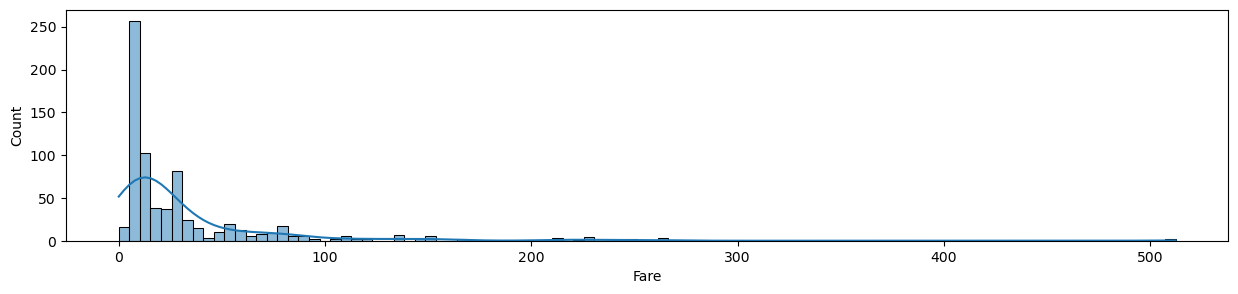

In [186]:
plt.figure(figsize=(15,3))
sns.histplot(data=X_prepro1, x='Fare', stat="count", kde=True)

In [187]:
yjt = YeoJohnsonTransformer()
yjt.fit(X_prepro1[['Fare']])

YeoJohnsonTransformer()

In [188]:
X_trans = pd.DataFrame()

In [189]:
X_trans_test = pd.DataFrame()

In [190]:
X_trans['Fare_transformed'] = yjt.transform(X_prepro1[['Fare']])
X_trans['Fare'] = X_prepro1['Fare']

In [191]:
X_trans_test['Fare_transformed'] = yjt.transform(X_prepro1_test[['Fare']])
X_trans_test['Fare'] = X_prepro1_test['Fare']

In [192]:
X_trans[['Fare', 'Fare_transformed']]

,Fare,Fare_transformed
692,56.4958,3.486357
481,0.0000,0.000000
527,221.7792,4.431708
855,9.3500,2.140875
801,26.2500,2.922005
...,...,...
359,7.8792,2.011833
258,512.3292,4.967578
736,34.3750,3.122899
462,38.5000,3.206617


<Axes: xlabel='Fare_transformed', ylabel='Count'>

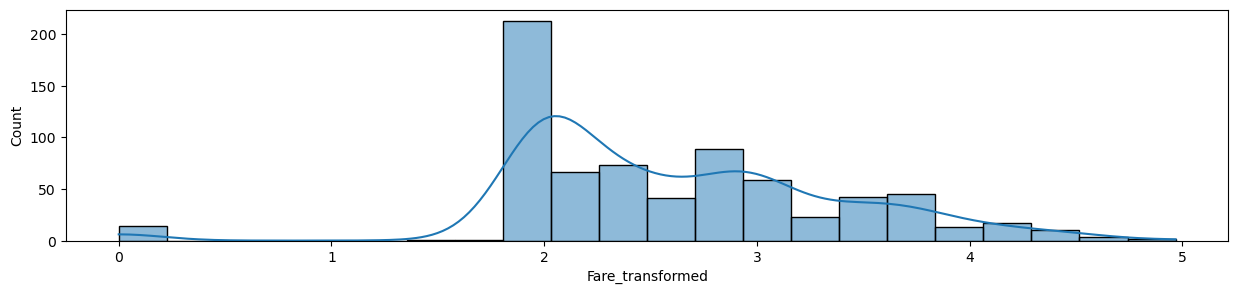

In [193]:
plt.figure(figsize=(15,3))
# Histograma de Age después de la imputación
sns.histplot(data=X_trans, x='Fare_transformed', stat="count", kde=True)

In [194]:
import scipy.stats as stats

In [195]:
def make_qqplot(df):
    variables = list(df.columns)
    plt.figure(figsize=(10, 6), constrained_layout=True)
    for i in range(2):
        # location in figure
        ax = plt.subplot(1, 2, i + 1)
        # variable to plot
        var = variables[i]
        # q-q plot
        stats.probplot((df[var]), dist="norm", plot=plt)
        # add variable name as title
        ax.set_title(var)
    plt.show()

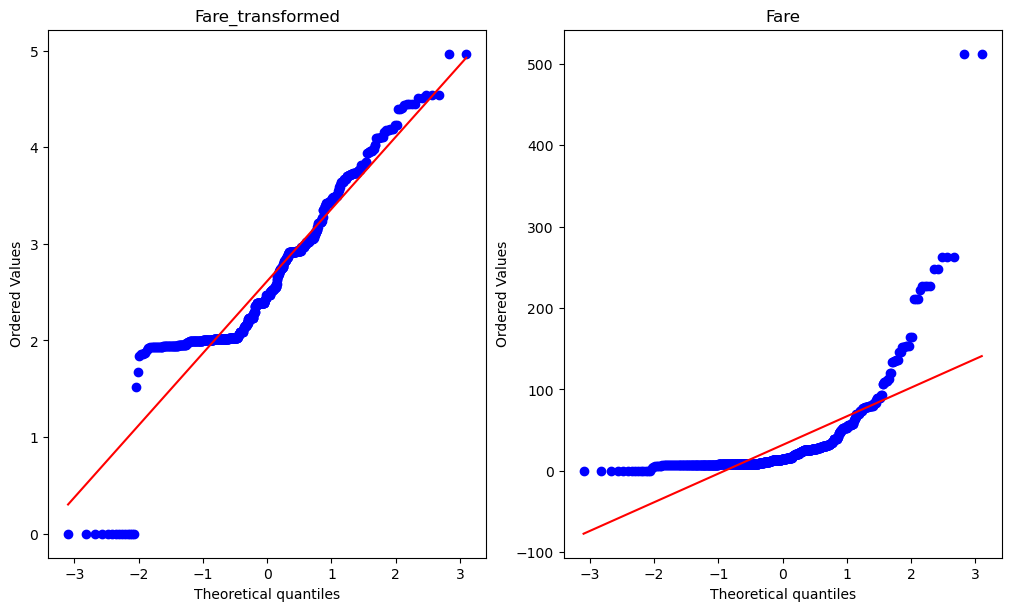

In [196]:
make_qqplot(X_trans)

#### Modifico la variable "fare" y creo una nueva variable relacionada a ella

##### Dado que el valor de Fare no puede ser cero (excepto en casos específicos, como boletos de cortesía o empleados), sustituiremos este valor por uno muy elevado para que, al aplicar la transformación, parezca ajustarse a una distribución normal. Además, crearemos una variable categórica que tomará el valor 1 cuando Fare sea igual a 0.

In [199]:
X_prepro1['Fare_0'] = np.where(X_prepro1['Fare'] == 0, 1, 0).astype(int)

In [200]:
X_prepro1_test['Fare_0'] = np.where(X_prepro1_test['Fare'] == 0, 1, 0).astype(int)

In [201]:
X_prepro2 = X_prepro1.copy()

In [202]:
X_prepro2_test = X_prepro1_test.copy()

In [203]:
X_prepro2['Fare'].max()

512.3292

In [204]:
X_prepro2['Fare'] = np.where(X_prepro2['Fare'] == 0, 700, X_prepro2['Fare'])

In [205]:
X_prepro2_test['Fare'] = np.where(X_prepro2_test['Fare'] == 0, 700, X_prepro2_test['Fare'])

In [206]:
X_prepro2['Fare'].min()

4.0125

In [207]:
# Clase para la creacion bivariable Fare_0
class FareZeroTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        # No hay necesidad de ajustar nada en este transformador
        return self

    def transform(self, X):
        # Verificamos que la entrada sea un DataFrame
        if not isinstance(X, pd.DataFrame):
            raise ValueError("Input must be a pandas DataFrame")
        
        # Creamos la nueva columna 'Fare_0'
        X['Fare_0'] = np.where(X['Fare'] == 0, 1, 0).astype(int)
        return X

In [208]:
# Clase para reemplzar las observaciones de Fare con valor 0 por 700
class FareReplacementTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, target_column='Fare', replacement_value=700):
        self.target_column = target_column
        self.replacement_value = replacement_value

    def fit(self, X, y=None):
        return self  # No necesitamos ajuste

    def transform(self, X):
        X = X.copy()
        X[self.target_column] = np.where(X[self.target_column] == 0, self.replacement_value, X[self.target_column])
        return X

In [209]:
# Para el pipeline
# ('fare_zero_transformer', FareZeroTransformer()),
# ('fare_replacement', FareReplacementTransformer()),

### Transformo los nuevos valores de "Fare"

In [211]:
bct = BoxCoxTransformer()
bct.fit(X_prepro2[['Fare']])

BoxCoxTransformer()

In [212]:
X_trans = pd.DataFrame()

In [213]:
X_trans['Fare_transformed'] = bct.transform(X_prepro2[['Fare']])
X_trans['Fare'] = X_prepro2['Fare']

In [214]:
X_trans_test['Fare_transformed'] = bct.transform(X_prepro2_test[['Fare']])
X_trans_test['Fare'] = X_prepro2_test['Fare']

In [215]:
X_trans[['Fare', 'Fare_transformed']]

,Fare,Fare_transformed
692,56.4958,1.666464
481,700.0000,1.831050
527,221.7792,1.781627
855,9.3500,1.310865
801,26.2500,1.554623
...,...,...
359,7.8792,1.255966
258,512.3292,1.820447
736,34.3750,1.599229
462,38.5000,1.616156


<Axes: xlabel='Fare_transformed', ylabel='Count'>

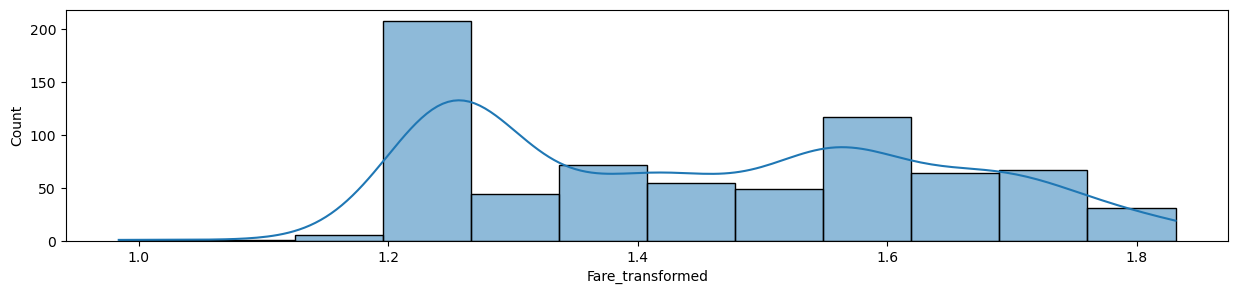

In [216]:
plt.figure(figsize=(15,3))
# Histograma de Age después de la imputación
sns.histplot(data=X_trans, x='Fare_transformed', stat="count", kde=True)

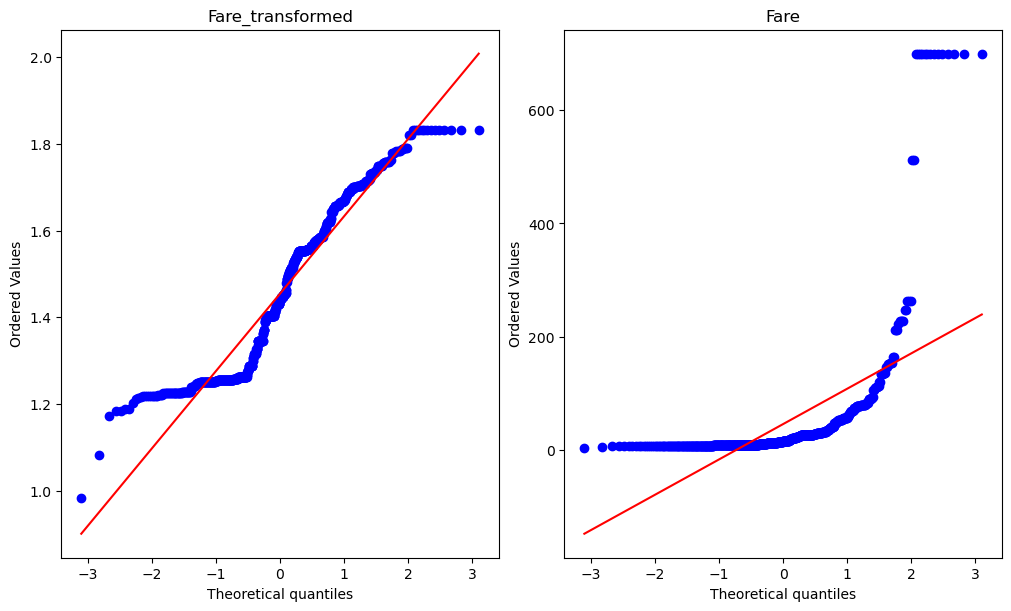

In [217]:
make_qqplot(X_trans)

In [218]:
X_prepro2['Fare'] = X_trans['Fare_transformed']

In [219]:
# Para el pipeline no hace falta crear una clase
# ('boxcox_transformer', BoxCoxTransformer(variables=['Fare'])),

In [220]:
X_prepro2.head()

,Age,Fare,IsAlone,Pclass_2,Pclass_3,Sex_male,SibSp_2 hermanos,SibSp_3 o más hermanos,SibSp_Sin hermanos,Parch_2 padres/hijos,...,Title_Mrs,Title_Rare_Title,Cabin_num_Cabinas_extremos,Cabin_num_Cabinas_mitad,Cabin_num_Missing,Cabin_category_Cabinas_clase_media,Cabin_category_Cabinas_clase_media_baja,Cabin_category_Cabinas_economicas,Cabin_category_Missing,Fare_0
692,NaN,1.666464,1,0,1,1,0,0,1,0,...,0,0,0,0,1,0,0,0,1,0
481,NaN,1.831050,1,1,0,1,0,0,1,0,...,0,0,0,0,1,0,0,0,1,1
527,NaN,1.781627,1,0,0,1,0,0,1,0,...,0,0,0,1,0,1,0,0,0,0
855,18.0,1.310865,0,0,1,0,0,0,1,0,...,1,0,0,0,1,0,0,0,1,0
801,31.0,1.554623,0,1,0,0,0,0,0,0,...,1,0,0,0,1,0,0,0,1,0


In [221]:
X_prepro2_test['Fare'] = X_trans_test['Fare_transformed']

### Imputo los valores faltantes de Age

In [223]:
1 - X_train_imputed_recat2['Age'].count()/len(X_train_imputed_recat2)
# Dada la alta cantidad de missing imputaremos con MICE luego de hacer los preprocesos necesarios

0.1924157303370787

In [224]:
# let's create a MICE imputer using Bayes as estimator

imputer = IterativeImputer(
    estimator=BayesianRidge(), # the estimator to predict the NA
    initial_strategy='mean', # how will NA be imputed in step 1
    max_iter=20, # number of cycles
    imputation_order='ascending', # the order in which to impute the variables
    n_nearest_features=None, # whether to limit the number of predictors
    skip_complete=True, # whether to ignore variables without NA
    random_state=0,
)

In [225]:
imputer.fit(X_prepro2)

IterativeImputer(estimator=BayesianRidge(), max_iter=20, random_state=0,
                 skip_complete=True)

In [226]:
train_t = imputer.transform(X_prepro2) # --> modifica los indices

In [227]:
train_t_test = imputer.transform(X_prepro2_test)

In [228]:
X_trans_test

,Fare_transformed,Fare
565,1.539492,24.1500
160,1.455603,16.1000
553,1.226208,7.2250
860,1.424161,14.1083
241,1.446784,15.5000
...,...,...
880,1.552920,26.0000
91,1.254899,7.8542
883,1.345345,10.5000
473,1.418532,13.7917


In [229]:
X_prepro3 = pd.DataFrame(train_t, columns=X_prepro2.columns, index=X_prepro2.index) # De esta manera se mantienen los indices originales
X_prepro3_test = pd.DataFrame(train_t_test, columns=X_prepro2_test.columns, index=X_prepro2_test.index)

In [230]:
X_prepro3

,Age,Fare,IsAlone,Pclass_2,Pclass_3,Sex_male,SibSp_2 hermanos,SibSp_3 o más hermanos,SibSp_Sin hermanos,Parch_2 padres/hijos,...,Title_Mrs,Title_Rare_Title,Cabin_num_Cabinas_extremos,Cabin_num_Cabinas_mitad,Cabin_num_Missing,Cabin_category_Cabinas_clase_media,Cabin_category_Cabinas_clase_media_baja,Cabin_category_Cabinas_economicas,Cabin_category_Missing,Fare_0
692,30.932025,1.666464,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
481,34.059857,1.831050,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0
527,40.828138,1.781627,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
855,18.000000,1.310865,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
801,31.000000,1.554623,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
359,25.857926,1.255966,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
258,35.000000,1.820447,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
736,48.000000,1.599229,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
462,47.000000,1.616156,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0


In [231]:
X_prepro3.isnull().sum().sum()

0

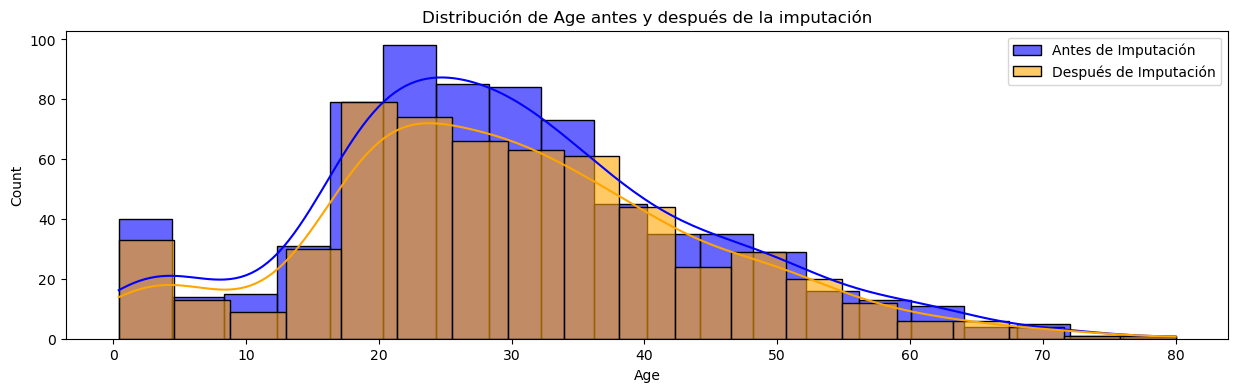

In [232]:
plt.figure(figsize=(15,4))
# Histograma de Age antes de la imputación
sns.histplot(data=df, x='Age', stat="count", kde=True, color='blue', label='Antes de Imputación', alpha=0.6)

# Histograma de Age después de la imputación
sns.histplot(data=X_prepro2, x='Age', stat="count", kde=True, color='orange', label='Después de Imputación', alpha=0.6)

# Añadir títulos y etiquetas
plt.title('Distribución de Age antes y después de la imputación')
plt.xlabel('Age')
plt.ylabel('Count')

# Mostrar leyenda
plt.legend()

# Mostrar la gráfica
plt.show()

In [233]:
X_prepro3.describe()

,Age,Fare,IsAlone,Pclass_2,Pclass_3,Sex_male,SibSp_2 hermanos,SibSp_3 o más hermanos,SibSp_Sin hermanos,Parch_2 padres/hijos,...,Title_Mrs,Title_Rare_Title,Cabin_num_Cabinas_extremos,Cabin_num_Cabinas_mitad,Cabin_num_Missing,Cabin_category_Cabinas_clase_media,Cabin_category_Cabinas_clase_media_baja,Cabin_category_Cabinas_economicas,Cabin_category_Missing,Fare_0
count,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000,...,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000
mean,29.961067,1.454472,0.609551,0.210674,0.549157,0.644663,0.029494,0.046348,0.693820,0.085674,...,0.150281,0.029494,0.023876,0.063202,0.779494,0.105337,0.077247,0.022472,0.775281,0.019663
std,13.591591,0.184968,0.488194,0.408074,0.497927,0.478952,0.169307,0.210386,0.461229,0.280079,...,0.357598,0.169307,0.152771,0.243497,0.414879,0.307203,0.267171,0.148317,0.417691,0.138937
min,0.420000,0.983878,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,21.208941,1.257908,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,30.000000,1.439787,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,38.000000,1.592878,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,80.000000,1.831050,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [234]:
# Clase para realizar la imputación con MICE
class MICEImputer(BaseEstimator, TransformerMixin):
    def __init__(self, max_iter=20, random_state=0):
        self.max_iter = max_iter
        self.random_state = random_state
        self.imputer = IterativeImputer(
            estimator=BayesianRidge(),
            initial_strategy='mean',
            max_iter=self.max_iter,
            imputation_order='ascending',
            n_nearest_features=None,
            skip_complete=True,
            random_state=self.random_state,
        )

    def fit(self, X, y=None):
        self.imputer.fit(X)
        self.original_types = X.dtypes  # Guardar los tipos originales
        return self

    def transform(self, X):
        X_imputed = self.imputer.transform(X)
        X_imputed_df = pd.DataFrame(X_imputed, columns=X.columns, index=X.index)
        # Convertir de nuevo a los tipos originales
        for col in X_imputed_df.columns:
            if col in self.original_types.index:
                X_imputed_df[col] = X_imputed_df[col].astype(self.original_types[col])
        return X_imputed_df

In [235]:
# Para el pipeline
# ('mice_imputer', MICEImputer(max_iter=20, random_state=0)), 

### Analizo los outliers

In [237]:
def plot_boxplot_and_hist(data, variable):
    
    # creating a figure composed of two matplotlib.Axes 
    # objects (ax_box and ax_hist)
    
    f, (ax_box, ax_hist) = plt.subplots(
        2, sharex=True, gridspec_kw={"height_ratios": (0.50, 0.85)}
    )

    # assigning a graph to each ax
    sns.boxplot(x=data[variable], ax=ax_box)
    sns.histplot(data=data, x=variable, ax=ax_hist)

    # Remove x axis name for the boxplot
    ax_box.set(xlabel="")
    plt.title(variable)
    plt.show()

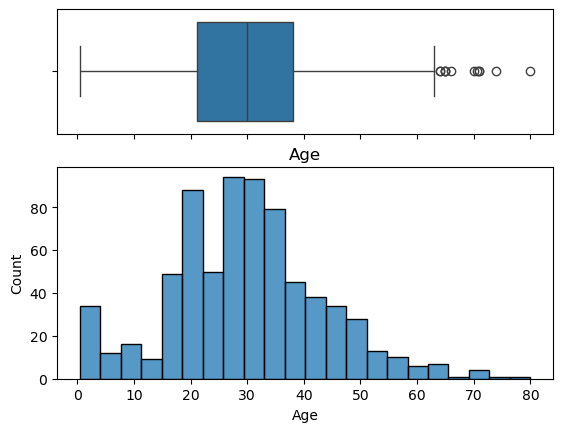

In [238]:
plot_boxplot_and_hist(X_prepro3, "Age")

In [239]:
# Supongamos que ya tienes el DataFrame X_prepro3
# Calcular Q1, Q3 y IQR
Q1 = X_prepro3['Age'].quantile(0.25)
Q3 = X_prepro3['Age'].quantile(0.75)
IQR = Q3 - Q1

# Calcular el bigote superior
upper_whisker = Q3 + 1.5 * IQR

# Contar los valores de Age que están por encima del bigote superior
count_above_upper_whisker = (X_prepro3['Age'] > upper_whisker).sum()

# Mostrar el resultado
print(f"Número de valores de Age por encima del bigote superior: {count_above_upper_whisker}")


Número de valores de Age por encima del bigote superior: 12


In [240]:
def find_limits(df, variable):
    IQR = df[variable].quantile(0.75) - df[variable].quantile(0.25)
    lower_limit = df[variable].quantile(0.25) - (IQR * 1.5)
    upper_limit = df[variable].quantile(0.75) + (IQR * 1.5)
    return lower_limit, upper_limit

In [241]:
lower_limit, upper_limit = find_limits(X_prepro3, "Age")
lower_limit, upper_limit

(-3.977648670945147, 63.18658920256709)

In [242]:
X_prepro3["Age"] = X_prepro3["Age"].clip(lower=lower_limit, upper=upper_limit)

In [243]:
X_prepro3_test["Age"] = X_prepro3_test["Age"].clip(lower=lower_limit, upper=upper_limit)

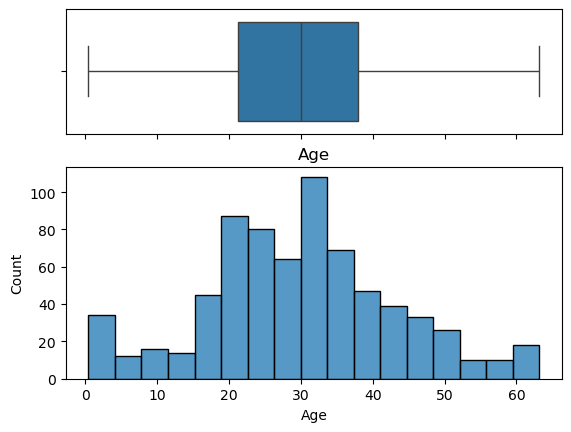

In [244]:
plot_boxplot_and_hist(X_prepro3, "Age")

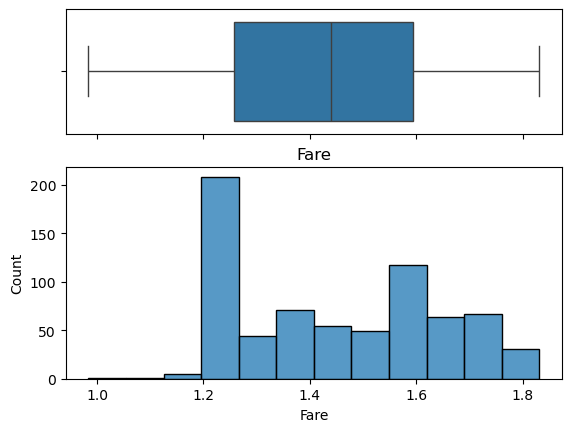

In [245]:
plot_boxplot_and_hist(X_prepro3, "Fare")

In [246]:
# Clase para reemplzar el valor de los puntos extremos 
class OutlierAdjuster(BaseEstimator, TransformerMixin):
    def __init__(self, variables):
        self.variables = variables
        self.limits = {}

    def fit(self, X, y=None):
        for variable in self.variables:
            lower_limit, upper_limit = self.find_limits(X, variable)
            self.limits[variable] = (lower_limit, upper_limit)
        return self

    def transform(self, X):
        X_transformed = X.copy()
        for variable, (lower_limit, upper_limit) in self.limits.items():
            # Recortar outliers
            X_transformed[variable] = X_transformed[variable].clip(lower=lower_limit, upper=upper_limit)
        return X_transformed

    def find_limits(self, df, variable):
        IQR = df[variable].quantile(0.75) - df[variable].quantile(0.25)
        lower_limit = df[variable].quantile(0.25) - (IQR * 1.5)
        upper_limit = df[variable].quantile(0.75) + (IQR * 1.5)
        return lower_limit, upper_limit

In [247]:
# Para el pipeline
# ('outlier_adjustment', OutlierAdjuster(variables=['Fare', 'Age'])),

### Escalo los valores fare y age

In [249]:
scaler = MinMaxScaler().set_output(transform="pandas")

In [250]:
# fit the scaler to the train set, it will learn the parameters
scaler.fit(X_prepro3[['Age', 'Fare']])

MinMaxScaler()

In [251]:
# transform train and test sets
X_prepro3[['Age', 'Fare']] = scaler.transform(X_prepro3[['Age', 'Fare']])

In [252]:
# transform train and test sets
X_prepro3_test[['Age', 'Fare']] = scaler.transform(X_prepro3_test[['Age', 'Fare']])

In [253]:
# Clase para escalar segun solo las caracteristicas deseadas
class CustomMinMaxScaler(BaseEstimator, TransformerMixin):
    def __init__(self, features):
        self.features = features
        self.scaler = MinMaxScaler()

    def fit(self, X, y=None):
        self.scaler.fit(X[self.features])
        return self

    def transform(self, X):
        X_transformed = X.copy()
        X_transformed[self.features] = self.scaler.transform(X[self.features])
        return X_transformed

In [254]:
# Para el pipeline
# ('scaler', CustomMinMaxScaler(features=['Age', 'Fare'])),

In [255]:
X_train = X_prepro3.copy() 
X_test = X_prepro3_test.copy() 
#y_train = y_train.values.ravel()
#y_test = y_test.values.ravel()

In [256]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(712, 26)
(712, 1)
(179, 26)
(179, 1)


In [257]:
X_train.head(4)

,Age,Fare,IsAlone,Pclass_2,Pclass_3,Sex_male,SibSp_2 hermanos,SibSp_3 o más hermanos,SibSp_Sin hermanos,Parch_2 padres/hijos,...,Title_Mrs,Title_Rare_Title,Cabin_num_Cabinas_extremos,Cabin_num_Cabinas_mitad,Cabin_num_Missing,Cabin_category_Cabinas_clase_media,Cabin_category_Cabinas_clase_media_baja,Cabin_category_Cabinas_economicas,Cabin_category_Missing,Fare_0
692,0.486119,0.805724,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
481,0.535952,1.000000,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0
527,0.643784,0.941661,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
855,0.280085,0.385974,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [258]:
y_train.head(4)

,Survived
692,1
481,0
527,0
855,1


In [259]:
train_data = pd.concat([X_train, y_train], axis=1)

In [260]:
train_data.isnull().sum().sum()

0

In [261]:
test_data = pd.concat([X_test, y_test], axis=1)

In [262]:
test_data.isnull().sum().sum()

0

In [263]:
data = pd.concat([train_data, test_data], axis=0)

In [264]:
data

,Age,Fare,IsAlone,Pclass_2,Pclass_3,Sex_male,SibSp_2 hermanos,SibSp_3 o más hermanos,SibSp_Sin hermanos,Parch_2 padres/hijos,...,Title_Rare_Title,Cabin_num_Cabinas_extremos,Cabin_num_Cabinas_mitad,Cabin_num_Missing,Cabin_category_Cabinas_clase_media,Cabin_category_Cabinas_clase_media_baja,Cabin_category_Cabinas_economicas,Cabin_category_Missing,Fare_0,Survived
692,0.486119,0.805724,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1
481,0.535952,1.000000,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0
527,0.643784,0.941661,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0
855,0.280085,0.385974,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1
801,0.487202,0.673707,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
880,0.391610,0.671697,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1
91,0.311949,0.319913,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0
883,0.439406,0.426674,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0
473,0.359746,0.513065,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1


In [265]:
data.isnull().sum().sum()

0

interval columns not set, guessing: ['Age', 'Fare', 'IsAlone', 'Pclass_2', 'Pclass_3', 'Sex_male', 'SibSp_2 hermanos', 'SibSp_3 o más hermanos', 'SibSp_Sin hermanos', 'Parch_2 padres/hijos', 'Parch_3 o más padres/hijos', 'Parch_Sin padres/hijos', 'Embarked_Q', 'Embarked_S', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Rare_Title', 'Cabin_num_Cabinas_extremos', 'Cabin_num_Cabinas_mitad', 'Cabin_num_Missing', 'Cabin_category_Cabinas_clase_media', 'Cabin_category_Cabinas_clase_media_baja', 'Cabin_category_Cabinas_economicas', 'Cabin_category_Missing', 'Fare_0', 'Survived']


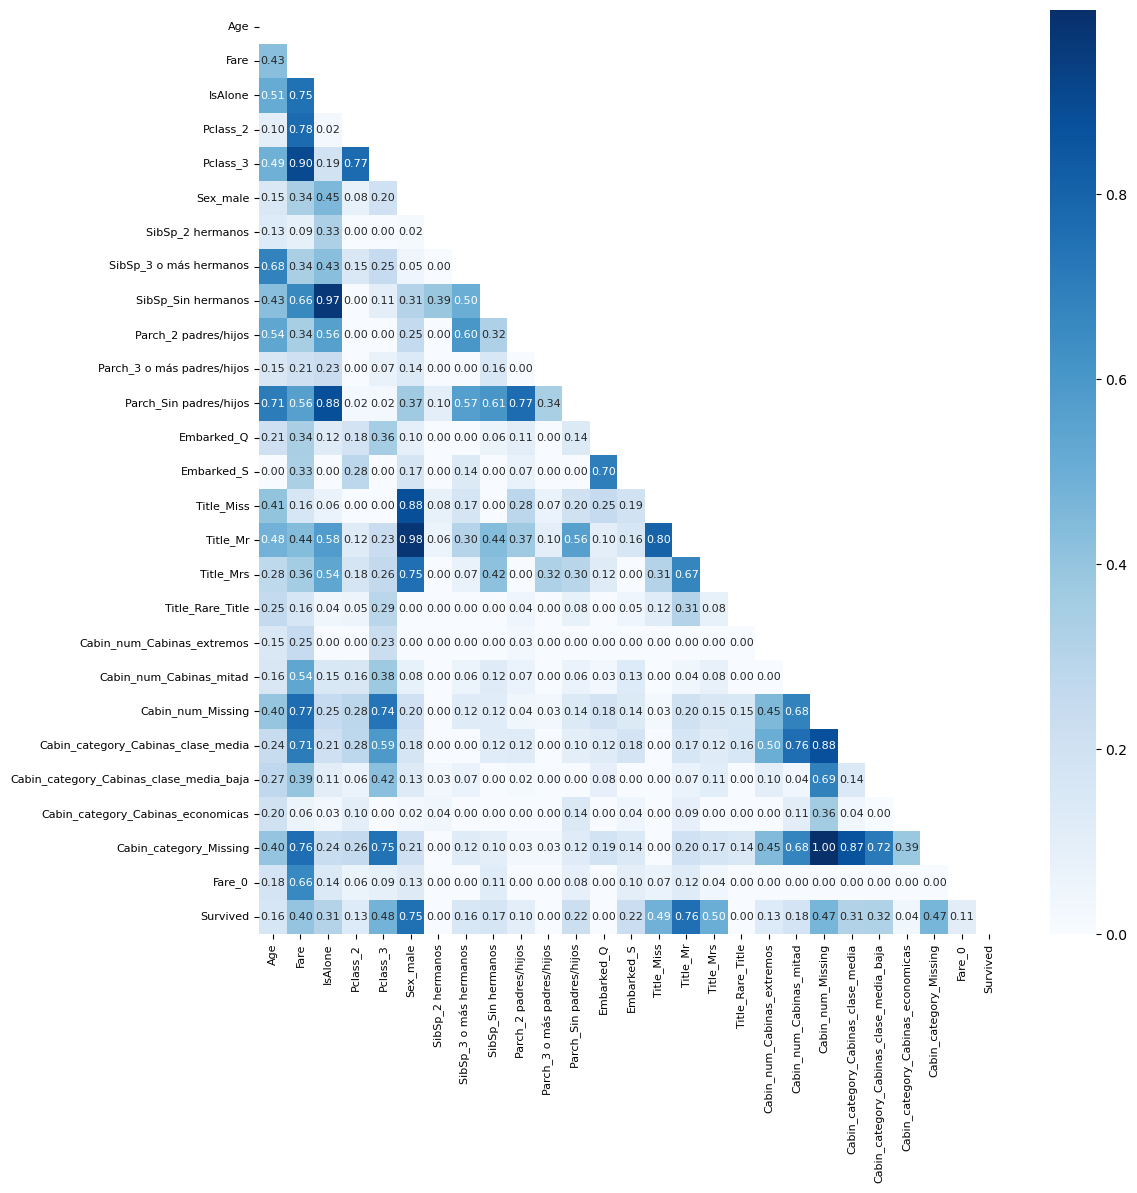

In [266]:
# Calcular la matriz de correlación usando phik
corr_matrix = phik_matrix(data)

# Crear una máscara para el triángulo superior
mask = np.zeros_like(corr_matrix, dtype=bool)
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(12, 12))
ax = sns.heatmap(corr_matrix, annot=True, cmap='Blues', fmt='.2f', mask=mask,
                 annot_kws={"size": 8})

# Ajustar el tamaño de las etiquetas de los ejes
ax.set_xticklabels(ax.get_xticklabels(), fontsize=8)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=8)

plt.show();

## Pipeline para preprocesamiento de datos

In [268]:
titanic_preprocessing_pipeline = Pipeline([
    ('title_extractor', TitleExtractor(name_column='Name', title_column='Title')),
    ('is_alone_extractor', IsAloneFeatureExtractor(sibsp_column='SibSp', parch_column='Parch', is_alone_column='IsAlone')),
    ('cabin_category_extractor', CabinCategoryExtractor(cabin_column='Cabin', category_column='Cabin_cat')),
    ('cabin_number_extractor', CabinNumberExtractor(cabin_column='Cabin', number_column='Cabin_num')),
    ('drop_features', DropFeatures(features_to_drop=['Name', 'Cabin', 'Ticket', 'PassengerId'])),
    ('impute_cabin_cat', CategoricalImputer(imputation_method="missing", fill_value="Missing", variables=['Cabin_cat'])),
    ('impute_cabin_num', CategoricalImputer(imputation_method="missing", fill_value="0", variables=['Cabin_num'])),
    ('impute_embarked', CategoricalImputer(imputation_method="frequent", variables=['Embarked'])),
    ('dtype_fisrt_converter', DType_first_Converter()),
    ('cabin_recategorizer', CabinRecategorizer()),
    ('drop_Cabin_cat', DropFeatures(features_to_drop=['Cabin_cat'])),
    ('cabin_discretiser', CustomCabinNumDiscretiser()),
    ('cabin_num_mapper', CabinNumMapper()),
    
    ('rare_encoder', RareLabelEncoder(tol=0.04, n_categories=4, variables=["Title"], replace_with='Rare_Title')),
    ('family_discretiser', CustomDiscretiser()),    
    ('family_mapper', FamilySizeMapper()), 
        
    ('custom_onehot_encoder', CustomOneHotEncoder_drop_first()),
    # o
    #('custom_onehot_encoder', CustomOneHotEncoder_if_binary()),
    
    ('fare_zero_transformer', FareZeroTransformer()),
    ('fare_replacement', FareReplacementTransformer()),
    ('boxcox_transformer', BoxCoxTransformer(variables=['Fare'])),
    ('mice_imputer', MICEImputer(max_iter=20, random_state=0)), 
    ('outlier_adjustment', OutlierAdjuster(variables=['Fare', 'Age'])),
    ('scaler', CustomMinMaxScaler(features=['Age', 'Fare']))
])    

### Verifico que el pipeline funcione correctamente

#### Verifico paso a paso las transformaciones del pipeline en un conjunto de muestra

In [271]:
df_raw = raw_data.copy()
prueba_data = df_raw.sample(50)  # Selecciona una muestra pequeña
prueba_data = prueba_data.drop(columns = "Survived")

In [272]:
for nombre, paso in titanic_preprocessing_pipeline.steps:
    prueba_data = paso.fit_transform(prueba_data)
    print(f"\nDespués de {nombre}:\n",prueba_data.head(10))


Después de title_extractor:
      PassengerId  Pclass                                               Name  \
6              7       1                            McCarthy, Mr. Timothy J   
645          646       1                          Harper, Mr. Henry Sleeper   
271          272       3                       Tornquist, Mr. William Henry   
90            91       3                               Christmann, Mr. Emil   
817          818       2                                 Mallet, Mr. Albert   
424          425       3                        Rosblom, Mr. Viktor Richard   
41            42       2  Turpin, Mrs. William John Robert (Dorothy Ann ...   
185          186       1                              Rood, Mr. Hugh Roscoe   
257          258       1                               Cherry, Miss. Gladys   
551          552       2                        Sharp, Mr. Percival James R   

        Sex   Age  SibSp  Parch           Ticket     Fare Cabin Embarked Title  
6      male  54.0  

C:\Users\germa\anaconda3\Lib\site-packages\feature_engine\encoding\rare_label.py:216: UserWarning: The number of unique categories for variable Title is less than that indicated in n_categories. Thus, all categories will be considered frequent
  warnings.warn(


#### Verifico paso a paso los tipos de datos al aplicar las transformaciones del pipeline en un conjunto de muestra

In [274]:
df_raw = raw_data.copy()
prueba_data = df_raw.sample(50)  # Selecciona una muestra pequeña
prueba_data = prueba_data.drop(columns = "Survived")

In [275]:
for nombre, paso in titanic_preprocessing_pipeline.steps:
    prueba_data = paso.fit_transform(prueba_data)
    print(f"\nDespués de {nombre}:\n",prueba_data.dtypes)


Después de title_extractor:
 PassengerId      int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
Title           object
dtype: object

Después de is_alone_extractor:
 PassengerId      int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
Title           object
IsAlone          int32
dtype: object

Después de cabin_category_extractor:
 PassengerId      int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
Title           object
IsAlone          in

#### Verifico que el pipeline no genere valores nulos en un conjunto de muestra

In [277]:
df_raw = raw_data.copy()
prueba_data = df_raw.sample(50)  # Selecciona una muestra pequeña
prueba_data = prueba_data.drop(columns = "Survived")

In [278]:
for nombre, paso in titanic_preprocessing_pipeline.steps:
    prueba_data = paso.fit_transform(prueba_data)
    # Filtrar y mostrar solo las columnas con nulos
    nulos = prueba_data.isnull().sum()
    nulos_con_datos = nulos[nulos > 0]  # Solo columnas con nulos
    print(f"\nNulos después de {nombre}:\n",nulos_con_datos)


Nulos después de title_extractor:
 Age       6
Cabin    32
dtype: int64

Nulos después de is_alone_extractor:
 Age       6
Cabin    32
dtype: int64

Nulos después de cabin_category_extractor:
 Age           6
Cabin        32
Cabin_cat    32
dtype: int64

Nulos después de cabin_number_extractor:
 Age           6
Cabin        32
Cabin_cat    32
Cabin_num    32
dtype: int64

Nulos después de drop_features:
 Age           6
Cabin_cat    32
Cabin_num    32
dtype: int64

Nulos después de impute_cabin_cat:
 Age           6
Cabin_num    32
dtype: int64

Nulos después de impute_cabin_num:
 Age    6
dtype: int64

Nulos después de impute_embarked:
 Age    6
dtype: int64

Nulos después de dtype_fisrt_converter:
 Age    6
dtype: int64

Nulos después de cabin_recategorizer:
 Age    6
dtype: int64

Nulos después de drop_Cabin_cat:
 Age    6
dtype: int64

Nulos después de cabin_discretiser:
 Age    6
dtype: int64

Nulos después de cabin_num_mapper:
 Age    6
dtype: int64

Nulos después de rare_encode

### Verifico el resultado final del pipeline

In [280]:
X_pipe_train, X_pipe_test, y_pipe_train, y_pipe_test = train_test_split( X,y,test_size = 0.2,random_state = 42, stratify=y)

In [281]:
# Aplicar el pipeline para preprocesar el conjunto de entrenamiento
titanic_pipe_df_train = titanic_preprocessing_pipeline.fit_transform(X_pipe_train)

In [282]:
# Ver el DataFrame resultante
titanic_pipe_df_train

,Age,Fare,IsAlone,Pclass_2,Pclass_3,Sex_male,SibSp_2 hermanos,SibSp_3 o más hermanos,SibSp_Sin hermanos,Parch_2 padres/hijos,...,Title_Mrs,Title_Rare_Title,Cabin_num_Cabinas_extremos,Cabin_num_Cabinas_mitad,Cabin_num_Missing,Cabin_category_Cabinas_clase_media,Cabin_category_Cabinas_clase_media_baja,Cabin_category_Cabinas_economicas,Cabin_category_Missing,Fare_0
692,0.486119,0.805724,1,0,1,1,0,0,1,0,...,0,0,0,0,1,0,0,0,1,0
481,0.535952,1.000000,1,1,0,1,0,0,1,0,...,0,0,0,0,1,0,0,0,1,1
527,0.643784,0.941661,1,0,0,1,0,0,1,0,...,0,0,0,1,0,1,0,0,0,0
855,0.280085,0.385974,0,0,1,0,0,0,1,0,...,1,0,0,0,1,0,0,0,1,0
801,0.487202,0.673707,0,1,0,0,0,0,0,0,...,1,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
359,0.405278,0.321173,1,0,1,0,0,0,1,0,...,0,0,0,0,1,0,0,0,1,0
258,0.550930,0.987485,1,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,1,0
736,0.758047,0.726359,0,0,1,0,0,0,0,0,...,1,0,0,0,1,0,0,0,1,0
462,0.742115,0.746340,1,0,0,1,0,0,1,0,...,0,0,0,1,0,0,1,0,0,0


#### Comparo el dataframe resultante de aplicar el pipeline con el dataframe obtenido al aplicar las transformaciones manualmente

In [284]:
titanic_pipe_df_train = titanic_pipe_df_train[sorted(titanic_pipe_df_train.columns)]
X_train = X_train[sorted(X_train.columns)]

In [285]:
# Verificar si son iguales
are_equal = titanic_pipe_df_train.equals(X_train)
print("\n¿Son iguales los DataFrames?", are_equal)


¿Son iguales los DataFrames? False


In [286]:
titanic_pipe_df_train.columns.tolist() == X_train.columns.tolist()

True

In [287]:
# Comparamos las diferencias
diferencias = set(titanic_pipe_df_train.columns) - set(X_train.columns)
print("Columnas diferentes:", diferencias)

Columnas diferentes: set()


In [288]:
# Comparamos las diferencias
diferencias = set(X_train.columns) - set(titanic_pipe_df_train.columns)
print("Columnas diferentes:", diferencias)

Columnas diferentes: set()


In [289]:
# Comparar fila por fila
if not are_equal:
    differences = titanic_pipe_df_train.compare(X_train)
    print("\nDiferencias entre los DataFrames:")
    print(differences)


Diferencias entre los DataFrames:
Empty DataFrame
Columns: []
Index: []


In [290]:
print("¿Los DataFrames son exactamente iguales?:", are_equal)

# Si quieres ver diferencias columna por columna
if not are_equal:
    for column in titanic_pipe_df_train.columns:
        if not titanic_pipe_df_train[column].equals(X_train[column]):
            print(f"Diferencias en la columna: {column}")
            print("Valores en titanic_pipe_df_train:")
            print(titanic_pipe_df_train[column].unique())
            print("Valores en X_train:")
            print(X_train[column].unique())

¿Los DataFrames son exactamente iguales?: False
Diferencias en la columna: Cabin_category_Cabinas_clase_media
Valores en titanic_pipe_df_train:
[0 1]
Valores en X_train:
[0. 1.]
Diferencias en la columna: Cabin_category_Cabinas_clase_media_baja
Valores en titanic_pipe_df_train:
[0 1]
Valores en X_train:
[0. 1.]
Diferencias en la columna: Cabin_category_Cabinas_economicas
Valores en titanic_pipe_df_train:
[0 1]
Valores en X_train:
[0. 1.]
Diferencias en la columna: Cabin_category_Missing
Valores en titanic_pipe_df_train:
[1 0]
Valores en X_train:
[1. 0.]
Diferencias en la columna: Cabin_num_Cabinas_extremos
Valores en titanic_pipe_df_train:
[0 1]
Valores en X_train:
[0. 1.]
Diferencias en la columna: Cabin_num_Cabinas_mitad
Valores en titanic_pipe_df_train:
[0 1]
Valores en X_train:
[0. 1.]
Diferencias en la columna: Cabin_num_Missing
Valores en titanic_pipe_df_train:
[1 0]
Valores en X_train:
[1. 0.]
Diferencias en la columna: Embarked_Q
Valores en titanic_pipe_df_train:
[0 1]
Valores 

In [291]:
# En X_train todos los valores son flotantes, esto no es un impedimento. Solo se debe tener en cuenta si el conjunto de datos es muy grande
X_train.dtypes

Age                                        float64
Cabin_category_Cabinas_clase_media         float64
Cabin_category_Cabinas_clase_media_baja    float64
Cabin_category_Cabinas_economicas          float64
Cabin_category_Missing                     float64
Cabin_num_Cabinas_extremos                 float64
Cabin_num_Cabinas_mitad                    float64
Cabin_num_Missing                          float64
Embarked_Q                                 float64
Embarked_S                                 float64
Fare                                       float64
Fare_0                                     float64
IsAlone                                    float64
Parch_2 padres/hijos                       float64
Parch_3 o más padres/hijos                 float64
Parch_Sin padres/hijos                     float64
Pclass_2                                   float64
Pclass_3                                   float64
Sex_male                                   float64
SibSp_2 hermanos               

### Creo un pipeline en el que solo se eliminan las dummies correspondientes a las características bicategóricas

In [293]:
titanic_preprocessing_pipeline_for_tree = Pipeline([
    ('title_extractor', TitleExtractor(name_column='Name', title_column='Title')),
    ('is_alone_extractor', IsAloneFeatureExtractor(sibsp_column='SibSp', parch_column='Parch', is_alone_column='IsAlone')),
    ('cabin_category_extractor', CabinCategoryExtractor(cabin_column='Cabin', category_column='Cabin_cat')),
    ('cabin_number_extractor', CabinNumberExtractor(cabin_column='Cabin', number_column='Cabin_num')),
    ('drop_features', DropFeatures(features_to_drop=['Name', 'Cabin', 'Ticket', 'PassengerId'])),
    ('impute_cabin_cat', CategoricalImputer(imputation_method="missing", fill_value="Missing", variables=['Cabin_cat'])),
    ('impute_cabin_num', CategoricalImputer(imputation_method="missing", fill_value="0", variables=['Cabin_num'])),
    ('impute_embarked', CategoricalImputer(imputation_method="frequent", variables=['Embarked'])),
    ('dtype_fisrt_converter', DType_first_Converter()),
    ('cabin_recategorizer', CabinRecategorizer()),
    ('drop_Cabin_cat', DropFeatures(features_to_drop=['Cabin_cat'])),
    ('cabin_discretiser', CustomCabinNumDiscretiser()),
    ('cabin_num_mapper', CabinNumMapper()),
    
    ('rare_encoder', RareLabelEncoder(tol=0.04, n_categories=4, variables=["Title"], replace_with='Rare_Title')),
    ('family_discretiser', CustomDiscretiser()),    
    ('family_mapper', FamilySizeMapper()), 
        
    ('custom_onehot_encoder', CustomOneHotEncoder_if_binary()),
    
    ('fare_zero_transformer', FareZeroTransformer()),
    ('fare_replacement', FareReplacementTransformer()),
    ('boxcox_transformer', BoxCoxTransformer(variables=['Fare'])),
    ('mice_imputer', MICEImputer(max_iter=20, random_state=0)), 
    ('outlier_adjustment', OutlierAdjuster(variables=['Fare', 'Age'])),
    ('scaler', CustomMinMaxScaler(features=['Age', 'Fare']))
])  

In [294]:
# Aplicar el pipeline a X_train
titanic_pipe_df_train = titanic_preprocessing_pipeline.fit_transform(X_pipe_train)
titanic_pipe_df_train_for_trees = titanic_preprocessing_pipeline_for_tree.fit_transform(X_pipe_train)

# Transformar X_test (si lo necesitas, aunque en este caso solo exportaremos el entrenamiento)
titanic_pipe_df_test = titanic_preprocessing_pipeline.transform(X_pipe_test)
titanic_pipe_df_test_for_trees = titanic_preprocessing_pipeline_for_tree.transform(X_pipe_test)

In [295]:
titanic_pipe_df_test

,Age,Fare,IsAlone,Pclass_2,Pclass_3,Sex_male,SibSp_2 hermanos,SibSp_3 o más hermanos,SibSp_Sin hermanos,Parch_2 padres/hijos,...,Title_Mrs,Title_Rare_Title,Cabin_num_Cabinas_extremos,Cabin_num_Cabinas_mitad,Cabin_num_Missing,Cabin_category_Cabinas_clase_media,Cabin_category_Cabinas_clase_media_baja,Cabin_category_Cabinas_economicas,Cabin_category_Missing,Fare_0
565,0.375678,0.655846,0,0,1,1,1,0,0,0,...,0,0,0,0,1,0,0,0,1,0
160,0.694318,0.556824,0,0,1,1,0,0,1,0,...,0,0,0,0,1,0,0,0,1,0
553,0.343813,0.286046,1,0,1,1,0,0,1,0,...,0,0,0,0,1,0,0,0,1,0
860,0.646522,0.519709,0,0,1,1,1,0,0,0,...,0,0,0,0,1,0,0,0,1,0
241,0.332320,0.546414,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
880,0.391610,0.671697,0,1,0,0,0,0,1,0,...,1,0,0,0,1,0,0,0,1,0
91,0.311949,0.319913,1,0,1,1,0,0,1,0,...,0,0,0,0,1,0,0,0,1,0
883,0.439406,0.426674,1,1,0,1,0,0,1,0,...,0,0,0,0,1,0,0,0,1,0
473,0.359746,0.513065,1,1,0,0,0,0,1,0,...,1,0,0,0,1,0,1,0,0,0


In [296]:
titanic_pipe_df_test_for_trees

,Age,Fare,IsAlone,Pclass_1,Pclass_2,Pclass_3,Sex_male,SibSp_1 hermano,SibSp_2 hermanos,SibSp_3 o más hermanos,...,Cabin_num_Cabinas_Centro,Cabin_num_Cabinas_extremos,Cabin_num_Cabinas_mitad,Cabin_num_Missing,Cabin_category_Cabina_Lujo,Cabin_category_Cabinas_clase_media,Cabin_category_Cabinas_clase_media_baja,Cabin_category_Cabinas_economicas,Cabin_category_Missing,Fare_0
565,0.377075,0.655846,0,0,0,1,1,0,1,0,...,0,0,0,1,0,0,0,0,1,0
160,0.696901,0.556824,0,0,0,1,1,0,0,0,...,0,0,0,1,0,0,0,0,1,0
553,0.345092,0.286046,1,0,0,1,1,0,0,0,...,0,0,0,1,0,0,0,0,1,0
860,0.648927,0.519709,0,0,0,1,1,0,1,0,...,0,0,0,1,0,0,0,0,1,0
241,0.338139,0.546414,0,0,0,1,0,1,0,0,...,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
880,0.393066,0.671697,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
91,0.313110,0.319913,1,0,0,1,1,0,0,0,...,0,0,0,1,0,0,0,0,1,0
883,0.441040,0.426674,1,0,1,0,1,0,0,0,...,0,0,0,1,0,0,0,0,1,0
473,0.361084,0.513065,1,0,1,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0


## Exporto los conjuntos de datos procesados

In [298]:
# Definir una función para convertir el índice a columna, nombrarla y exportar el DataFrame
def export_with_index(df, filepath, index_name='IndexName'):
    df_with_index = df.reset_index().rename(columns={'index': index_name})
    df_with_index.to_csv(filepath, index=False)

# Aplicar la función a cada DataFrame y exportarlo
export_with_index(titanic_pipe_df_train, '../Titanic/Dataset Titanic/titanic_pipe_df_train.csv')
export_with_index(titanic_pipe_df_train_for_trees, '../Titanic/Dataset Titanic/titanic_pipe_df_train_for_trees.csv')
export_with_index(titanic_pipe_df_test, '../Titanic/Dataset Titanic/titanic_pipe_df_test.csv')
export_with_index(titanic_pipe_df_test_for_trees, '../Titanic/Dataset Titanic/titanic_pipe_df_test_for_trees.csv')
export_with_index(y_pipe_train, '../Titanic/Dataset Titanic/y_pipe_train.csv')
export_with_index(y_pipe_test, '../Titanic/Dataset Titanic/y_pipe_test.csv')

#### Verifico que los datos se puedan importar correctamente

In [300]:
titanic_pipe_df_train = pd.read_csv('../Titanic/Dataset Titanic/titanic_pipe_df_train.csv', index_col='IndexName')
titanic_pipe_df_train_for_trees = pd.read_csv('../Titanic/Dataset Titanic/titanic_pipe_df_train_for_trees.csv', index_col='IndexName')

titanic_pipe_df_test = pd.read_csv('../Titanic/Dataset Titanic/titanic_pipe_df_test.csv', index_col='IndexName')
titanic_pipe_df_test_for_trees = pd.read_csv('../Titanic/Dataset Titanic/titanic_pipe_df_test_for_trees.csv', index_col='IndexName')

y_pipe_train = pd.read_csv('../Titanic/Dataset Titanic/y_pipe_train.csv', index_col='IndexName')
y_pipe_test = pd.read_csv('../Titanic/Dataset Titanic/y_pipe_test.csv', index_col='IndexName')

In [301]:
# Remover los nombres de los índices
titanic_pipe_df_train.index.name = None
titanic_pipe_df_train_for_trees.index.name = None
titanic_pipe_df_test.index.name = None
titanic_pipe_df_test_for_trees.index.name = None
y_pipe_train.index.name = None
y_pipe_test.index.name = None

In [302]:
X_train = titanic_pipe_df_train.copy()
X_train_tree = titanic_pipe_df_train_for_trees.copy()

X_test = titanic_pipe_df_test.copy()
X_test_tree = titanic_pipe_df_test_for_trees.copy()

y_train = y_pipe_train.copy()
y_test = y_pipe_test.copy()

In [303]:
X_train.head(4)

,Age,Fare,IsAlone,Pclass_2,Pclass_3,Sex_male,SibSp_2 hermanos,SibSp_3 o más hermanos,SibSp_Sin hermanos,Parch_2 padres/hijos,...,Title_Mrs,Title_Rare_Title,Cabin_num_Cabinas_extremos,Cabin_num_Cabinas_mitad,Cabin_num_Missing,Cabin_category_Cabinas_clase_media,Cabin_category_Cabinas_clase_media_baja,Cabin_category_Cabinas_economicas,Cabin_category_Missing,Fare_0
692,0.486119,0.805724,1,0,1,1,0,0,1,0,...,0,0,0,0,1,0,0,0,1,0
481,0.535952,1.000000,1,1,0,1,0,0,1,0,...,0,0,0,0,1,0,0,0,1,1
527,0.643784,0.941661,1,0,0,1,0,0,1,0,...,0,0,0,1,0,1,0,0,0,0
855,0.280085,0.385974,0,0,1,0,0,0,1,0,...,1,0,0,0,1,0,0,0,1,0


In [304]:
y_train.head(4)

,Survived
692,1
481,0
527,0
855,1


In [305]:
X_test.head(4)

,Age,Fare,IsAlone,Pclass_2,Pclass_3,Sex_male,SibSp_2 hermanos,SibSp_3 o más hermanos,SibSp_Sin hermanos,Parch_2 padres/hijos,...,Title_Mrs,Title_Rare_Title,Cabin_num_Cabinas_extremos,Cabin_num_Cabinas_mitad,Cabin_num_Missing,Cabin_category_Cabinas_clase_media,Cabin_category_Cabinas_clase_media_baja,Cabin_category_Cabinas_economicas,Cabin_category_Missing,Fare_0
565,0.375678,0.655846,0,0,1,1,1,0,0,0,...,0,0,0,0,1,0,0,0,1,0
160,0.694318,0.556824,0,0,1,1,0,0,1,0,...,0,0,0,0,1,0,0,0,1,0
553,0.343813,0.286046,1,0,1,1,0,0,1,0,...,0,0,0,0,1,0,0,0,1,0
860,0.646522,0.519709,0,0,1,1,1,0,0,0,...,0,0,0,0,1,0,0,0,1,0


In [306]:
y_test.head(4)

,Survived
565,0
160,0
553,1
860,0


#### Transformo los dataframes de la variable objetivo a listas

In [308]:
y_train = y_train.values.flatten()
y_test = y_test.values.flatten()

## Búsqueda del mejor modelo

### Defino diferentes funciones para determinar los mejores parámetros en distintos modelos

In [311]:
def objective_logit(trial, X_train, y_train, metric='accuracy'):
    # Definir los parámetros del modelo en un diccionario
    param = {
        'penalty': trial.suggest_categorical('logit_penalty', ['l1', 'l2']),
        'C': trial.suggest_float('logit_c', 1e-5, 1e2, log=True),
        'solver': trial.suggest_categorical('logit_solver', ['liblinear', 'saga']),
        'max_iter': trial.suggest_int('logit_max_iter', 100, 1000),
    }
    
    # Crear el modelo utilizando **param
    model = LogisticRegression(**param)
    model.fit(X_train, y_train)
    score = cross_val_score(model, X_train, y_train, cv=5, scoring=metric).mean()
    
    return score

from sklearn.calibration import CalibratedClassifierCV

def objective_svc(trial, X_train, y_train, metric='accuracy'):
    # Definir los parámetros del modelo en un diccionario
    param = {
        'C': trial.suggest_float('svc_c', 1e-5, 1e2, log=True),
        'kernel': trial.suggest_categorical('svc_kernel', ['linear', 'poly']),
        'gamma': trial.suggest_categorical('svc_gamma', ['scale', 'auto']),
        'degree': trial.suggest_int('svc_degree', 2, 4),
        'random_state': 42
    }
    
    # Crear el modelo base SVC
    model = SVC(**param)
    # Calibrar el modelo para obtener predict_proba
    calibrated_model = CalibratedClassifierCV(model, method='sigmoid', cv=5)
    
    # Usar el modelo calibrado para la validación cruzada
    score = cross_val_score(calibrated_model, X_train, y_train, cv=5, scoring=metric).mean()
    
    return score

def objective_gbm(trial, X_train, y_train, metric='accuracy'):
    # Definir los parámetros del modelo en un diccionario
    param = {
        'n_estimators': trial.suggest_int("gbm_n_estimators", 50, 200),
        'learning_rate': trial.suggest_float("gbm_learning_rate", 0.01, 0.2),
        'max_depth': trial.suggest_int("gbm_max_depth", 1, 25),
        'min_samples_split': trial.suggest_int("gbm_min_samples_split", 2, 100),
        'min_samples_leaf': trial.suggest_int("gbm_min_samples_leaf", 1, 200),
        'max_features': trial.suggest_categorical("gbm_max_features", ['sqrt', 'log2', None]),
        'random_state': 42
    }

    # Crear el modelo utilizando **param
    model = GradientBoostingClassifier(**param)    
    model.fit(X_train, y_train)
    score = cross_val_score(model, X_train, y_train, cv=5, scoring=metric).mean()
    
    return score

def objective_knn(trial, X_train, y_train, metric='accuracy'):
    # Definir los parámetros del modelo en un diccionario
    param = {
        'n_neighbors': trial.suggest_int('knn_n_neighbors', 3, 49, step=2),
        'weights': trial.suggest_categorical('knn_weights', ['uniform', 'distance']),
        'p': trial.suggest_int('knn_p', 1, 2),
    }

    # Crear el modelo utilizando **param
    model = KNeighborsClassifier(**param)
    
    model.fit(X_train, y_train)
    score = cross_val_score(model, X_train, y_train, cv=5, scoring=metric).mean()
    
    return score

def objective_naive(trial, X_train, y_train, metric='accuracy'):
    # Definir los parámetros del modelo en un diccionario
    param = {
        'var_smoothing': trial.suggest_float('naive_var_smoothing', 1e-3, 1e0, log=True)
    }

    # Crear el modelo utilizando **param
    model = GaussianNB(**param)
    
    model.fit(X_train, y_train)
    score = cross_val_score(model, X_train, y_train, cv=5, scoring=metric).mean()
    
    return score

def objective_rf(trial, X_train, y_train, metric='accuracy'):
    # Definir los parámetros del modelo en un diccionario
    param = {
        'n_estimators': trial.suggest_int("rf_n_estimators", 50, 300),
        'max_depth': trial.suggest_int("rf_max_depth", 1, 30),
        'min_samples_split': trial.suggest_int("rf_min_samples_split", 2, 400),
        'min_samples_leaf': trial.suggest_int("rf_min_samples_leaf", 1, 400),
        'max_features': trial.suggest_categorical("rf_max_features", [None, 'sqrt', 'log2']),
        'bootstrap': trial.suggest_categorical("rf_bootstrap", [True, False]),
        'random_state': 42
    }
    
    # Crear el modelo utilizando **param
    model = RandomForestClassifier(**param)
    model.fit(X_train, y_train)
    score = cross_val_score(model, X_train, y_train, cv=5, scoring=metric).mean()
    
    return score

def objective_dt(trial, X_train, y_train, metric='accuracy'):
    # Definir los parámetros del modelo en un diccionario
    param = {
        'max_depth': trial.suggest_int("dt_max_depth", 1, 20),
        'min_samples_split': trial.suggest_int("dt_min_samples_split", 2, 400),
        'min_samples_leaf': trial.suggest_int("dt_min_samples_leaf", 1, 400),
        'criterion': trial.suggest_categorical("dt_criterion", ["gini", "entropy"]),
        'random_state': 42
    }

    # Crear el modelo utilizando **param
    model = DecisionTreeClassifier(**param)
    
    model.fit(X_train, y_train)
    score = cross_val_score(model, X_train, y_train, cv=5, scoring=metric).mean()
    
    return score

def objective_lgbm(trial, X_train, y_train, metric='accuracy'):
    # Definir los parámetros del modelo en un diccionario
    param = {
        'objective': 'binary',
        'metric': 'auc',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'num_leaves': trial.suggest_int('num_leaves', 20, 100),
        'max_depth': trial.suggest_int('max_depth', 2, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
        'min_child_samples': trial.suggest_int('min_child_samples', 20, 500),
        'min_child_weight': trial.suggest_float('min_child_weight', 1e-5, 1e-2, log=True), 
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 1.0),
        'random_state': 42,
#        'class_weight': 'balanced'  # Address class imbalance
    }

    # Crear el modelo utilizando **param
    model = lgb.LGBMClassifier(**param, verbose=0)
    
    model.fit(X_train, y_train)
    score = cross_val_score(model, X_train, y_train, cv=5, scoring=metric).mean()
    
    return score

### Definición de funciones para la evaluación de los modelos

In [313]:
def resultados(y, y_pred, y_proba=None):
    """
    Esta función evalúa el rendimiento de un modelo de clasificación utilizando
    una matriz de confusión y, si se proporcionan probabilidades, la curva AUC-ROC.
    
    Parámetros:
    - y: array-like, valores verdaderos de las etiquetas de clase (etiquetas reales).
    - y_pred: array-like, valores predichos por el modelo (etiquetas predichas).
    - y_proba: array-like, probabilidades predichas por el modelo (opcional).
    """
    # Matriz de confusión
    conf_matrix = confusion_matrix(y, y_pred, normalize='true')
    
    # Configuración de la figura
    if y_proba is None:
        fig, ax = plt.subplots(figsize=(5, 4))  # Una sola figura si no hay `y_proba`
        sns.heatmap(conf_matrix, annot=True, cmap='Blues', vmin=0, vmax=1, center=0.5, ax=ax)
        ax.set_title("Matriz de Confusión")
        ax.set_ylabel('Real')
        ax.set_xlabel('Predicho')
    else:
        fig, axes = plt.subplots(1, 2, figsize=(10, 4))  # Dos subfiguras si hay `y_proba`
        
        # Graficar la matriz de confusión
        sns.heatmap(conf_matrix, annot=True, cmap='Blues', vmin=0, vmax=1, center=0.5, ax=axes[0])
        axes[0].set_title("Matriz de Confusión")
        axes[0].set_ylabel('Real')
        axes[0].set_xlabel('Predicho')
        
        # Calcular y graficar la curva AUC-ROC
        fpr, tpr, _ = roc_curve(y, y_proba)
        auc_score = roc_auc_score(y, y_proba)
        axes[1].plot(fpr, tpr, label=f'AUC = {auc_score:.2f}')
        axes[1].plot([0, 1], [0, 1], 'k--')  # Línea diagonal para referencia
        axes[1].set_title("Curva AUC-ROC")
        axes[1].set_xlabel("False Positive Rate")
        axes[1].set_ylabel("True Positive Rate")
        axes[1].legend()
    
    plt.tight_layout()
    plt.show()
    
    # Reporte de clasificación
    print(classification_report(y, y_pred))

In [314]:
def model_evaluation(model, X_train, y_train, metric='accuracy'):
    """
    Esta función evalúa el rendimiento del modelo utilizando K-Fold Cross-Validation
    y devuelve métricas de rendimiento, así como el riesgo de sobreajuste.

    Parámetros:
    - model: el modelo a evaluar.
    - X_train: conjunto de datos de entrenamiento.
    - y_train: etiquetas del conjunto de entrenamiento.

    Retorna:
    - df: DataFrame con las métricas de rendimiento.
    - overfitting_risk: diccionario con información sobre el riesgo de sobreajuste.
    """
    # K-Fold Cross-Validation
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    try:
        # Estimación del error de generalización
        clf = cross_validate(
            model,
            X_train,
            y_train,
            scoring= metric,
            return_train_score=True,
            cv=kf
        )

        # Calcular valores para el conjunto de entrenamiento
        mean_train_score = np.mean(clf['train_score'])
        std_train_score = np.std(clf['train_score'])

        # Calcular el intervalo para el conjunto de entrenamiento
        interval_lower_train = mean_train_score - 3 * std_train_score
        interval_upper_train = mean_train_score + 3 * std_train_score

        # Calcular el puntaje medio y el intervalo para el conjunto de prueba
        mean_test_score = np.mean(clf['test_score']) if 'test_score' in clf else np.nan
        std_test_score = np.std(clf['test_score']) if 'test_score' in clf else np.nan

        # Calcular el intervalo para el conjunto de prueba
        interval_lower_test = mean_test_score - 3 * std_test_score if not np.isnan(mean_test_score) else np.nan
        interval_upper_test = mean_test_score + 3 * std_test_score if not np.isnan(mean_test_score) else np.nan

        # Crear el DataFrame con las métricas
        df = pd.DataFrame({
            'mean': [mean_train_score, mean_test_score],
            'std': [std_train_score, std_test_score],
            'interval_lower': [interval_lower_train, interval_lower_test],
            'interval_upper': [interval_upper_train, interval_upper_test]
        }, index=['train_set', 'test_set'])

        # Prueba t para comparar las puntuaciones de entrenamiento y prueba
        t_stat, p_value = stats.ttest_ind(clf['train_score'], clf['test_score'], equal_var=False)

        # Diccionario con la probabilidad de sobreajuste
        overfitting_risk = {
            't_statistic': t_stat,
            'p_value': p_value,
            'overfitting_likelihood': 'High' if p_value < 0.10 else 'Low'
        }

        return df, overfitting_risk

    except Exception as e:
        print(f"Error al evaluar el modelo: {e}")
        return None, None

### Búsqueda de los mejores parámetros

In [316]:
from optuna.pruners import HyperbandPruner
import lightgbm as lgb
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

In [317]:
# Metrica a optimizar:
chosen_metric = 'roc_auc'

In [318]:
# Diccionario con los modelos y sus funciones objective correspondientes
model_dict = {
    'lgbm': objective_lgbm,
    'knn': objective_knn,
    'naive': objective_naive,
    'dt': objective_dt,
    'logit': objective_logit,
    'rf': objective_rf,
    'gbm': objective_gbm
}

#### Búsqueda de los mejores parámetros para el primer conjunto de datos

In [320]:
directory = "../01 - Binary Clasification/Titanic/Parameters/"

In [321]:
# Intentar leer el archivo CSV, si no existe, ejecutar la optimización
try:
    # Intentar leer el archivo CSV
    trials_df1 = pd.read_csv("../Titanic/Parameters/parameters_trials_1.csv")
    print("Archivo leído correctamente.\n")

except FileNotFoundError:
    # Si el archivo no existe, ejecutar la optimización
    print("Archivo no encontrado. Ejecutando optimización...")

    best_params_df = pd.DataFrame(columns=["model", "params", "score"])  # Agregar columna para la métrica

    # Loop sobre los modelos
    for model_name, objective_func in model_dict.items():
        # Crear el estudio para cada modelo
        study = optuna.create_study(direction='maximize', pruner=HyperbandPruner())

        # Optimizar el modelo con Optuna utilizando su función objective correspondiente
        study.optimize(lambda trial: objective_func(trial, X_train, y_train, metric = chosen_metric), n_trials = 80)

        # Obtener los mejores parámetros y la mejor puntuación
        best_params = study.best_params
        best_score = study.best_value  # Obtiene la mejor puntuación (por ejemplo, accuracy o roc_auc)

        # Imprimir mensaje indicando que la búsqueda terminó para el modelo actual
        print(f'Búsqueda en {model_name} finalizada')
        
        # Guardar en el DataFrame usando pd.concat()
        best_params_df = pd.concat([best_params_df, pd.DataFrame([{"model": model_name, 
                                                                   "params": best_params, 
                                                                   "score": best_score}])], ignore_index=True)

    # Guardar los resultados en un archivo CSV
    best_params_df.to_csv("../Titanic/Parameters/parameters_trials_1.csv", index=False)
    print("Resultados guardados en parameters_trials_1.csv")

# Leer el archivo CSV después de guardar
trials_df1 = pd.read_csv("../Titanic/Parameters/parameters_trials_1.csv")
print("Archivo leído correctamente después de la optimización.\n")

Archivo leído correctamente.

Archivo leído correctamente después de la optimización.



#### Búsqueda de los mejores parámetros para el segundo conjunto de datos

In [323]:
# Intentar leer el archivo CSV, si no existe, ejecutar la optimización
try:
    # Intentar leer el archivo CSV
    trials_df2 = pd.read_csv("../Titanic/parameters_trials_2.csv")
    print("Archivo leído correctamente.\n")

except FileNotFoundError:
    # Si el archivo no existe, ejecutar la optimización
    print("Archivo no encontrado. Ejecutando optimización...")

    best_params_df = pd.DataFrame(columns=["model", "params", "score"])  # Agregar columna para la métrica

    # Loop sobre los modelos
    for model_name, objective_func in model_dict.items():
        # Crear el estudio para cada modelo
        study = optuna.create_study(direction='maximize', pruner=HyperbandPruner())

        # Optimizar el modelo con Optuna utilizando su función objective correspondiente
        study.optimize(lambda trial: objective_func(trial, X_train_tree, y_train, metric = chosen_metric), n_trials = 80)

        # Obtener los mejores parámetros y la mejor puntuación
        best_params = study.best_params
        best_score = study.best_value  # Obtiene la mejor puntuación (por ejemplo, accuracy o roc_auc)

        # Imprimir mensaje indicando que la búsqueda terminó para el modelo actual
        print(f'Búsqueda en {model_name} finalizada')
        
        # Guardar en el DataFrame usando pd.concat()
        best_params_df = pd.concat([best_params_df, pd.DataFrame([{"model": model_name, 
                                                                   "params": best_params, 
                                                                   "score": best_score}])], ignore_index=True)

    # Guardar los resultados en un archivo CSV
    best_params_df.to_csv("../Titanic/parameters_trials_2.csv", index=False)
    print("Resultados guardados en parameters_trials.csv")

# Leer el archivo CSV después de guardar
trials_df2 = pd.read_csv("../Titanic/parameters_trials_2.csv")
print("Archivo leído correctamente después de la optimización.\n")

Archivo leído correctamente.

Archivo leído correctamente después de la optimización.



In [324]:
trials_df1

,model,params,score
0,lgbm,"{'num_leaves': 80, 'max_depth': 10, 'learning_...",0.890721
1,knn,"{'knn_n_neighbors': 29, 'knn_weights': 'unifor...",0.864292
2,naive,{'naive_var_smoothing': 0.9995914941610888},0.849011
3,dt,"{'dt_max_depth': 11, 'dt_min_samples_split': 7...",0.850223
4,logit,"{'logit_penalty': 'l2', 'logit_c': 1.402567232...",0.869582
5,rf,"{'rf_n_estimators': 127, 'rf_max_depth': 4, 'r...",0.866638
6,gbm,"{'gbm_n_estimators': 183, 'gbm_learning_rate':...",0.886798


In [325]:
trials_df2

,model,params,score
0,lgbm,"{'num_leaves': 26, 'max_depth': 2, 'learning_r...",0.837201
1,knn,"{'knn_n_neighbors': 27, 'knn_weights': 'unifor...",0.820309
2,naive,{'naive_var_smoothing': 0.2071322790493498},0.782281
3,dt,"{'dt_max_depth': 13, 'dt_min_samples_split': 1...",0.809111
4,logit,"{'logit_penalty': 'l2', 'logit_c': 6.565858124...",0.830090
5,rf,"{'rf_n_estimators': 292, 'rf_max_depth': 27, '...",0.830099
6,gbm,"{'gbm_n_estimators': 87, 'gbm_learning_rate': ...",0.847001


#### Defino una función para corregir el nombre de los parámetros

In [327]:
def remove_prefix_and_modify_params(params, model_name, prefix):
    """Elimina el prefijo de los parámetros y cambia 'c' a 'C' para logit y svc."""
    
    # Eliminar el prefijo de los parámetros
    new_params = {}
    for key, value in params.items():

        # Eliminar el prefijo y mantener el valor del parámetro
        if key.startswith(prefix):
            new_key = key[len(prefix):]  # Eliminar el prefijo
        else:
            new_key = key  # Si no tiene prefijo, usamos la clave original

        # Cambiar 'c' a 'C' para los modelos logit y svc
        if model_name in ['logit', 'svc'] and new_key == 'c':
            print(f"Se encontró 'c' como clave para {model_name}. Cambiando a 'C'.")
            new_key = 'C'  # Cambiar 'c' a 'C'

        new_params[new_key] = value
    
    return new_params

In [328]:
# Recorremos cada fila del DataFrame y removemos el prefijo de los parámetros
for index, row in trials_df1.iterrows():
    # Cargar los parámetros de la columna 'params' como diccionario
    params = eval(row['params'])  # Convertir string a diccionario

    # Obtener el nombre del modelo
    model_name = row['model']
    
    # Si el modelo es 'lgbm', no hay prefijo; en otros casos, usamos el nombre del modelo seguido de un guion bajo
    if model_name == "lgbm":
        prefix = ""
    else:
        prefix = f"{model_name}_"

    # Remover el prefijo y cambiar 'c' a 'C' si es necesario
    new_params = remove_prefix_and_modify_params(params, model_name, prefix)

    # Actualizar la columna 'params' con los nuevos parámetros sin prefijo
    trials_df1.at[index, 'params'] = new_params

# Imprimir el DataFrame actualizado después de la depuración
print("\nDataFrame actualizado:")
print(trials_df1)

Se encontró 'c' como clave para logit. Cambiando a 'C'.

DataFrame actualizado:
   model                                             params     score
0   lgbm  {'num_leaves': 80, 'max_depth': 10, 'learning_...  0.890721
1    knn  {'n_neighbors': 29, 'weights': 'uniform', 'p': 1}  0.864292
2  naive              {'var_smoothing': 0.9995914941610888}  0.849011
3     dt  {'max_depth': 11, 'min_samples_split': 75, 'mi...  0.850223
4  logit  {'penalty': 'l2', 'C': 1.402567232832215, 'sol...  0.869582
5     rf  {'n_estimators': 127, 'max_depth': 4, 'min_sam...  0.866638
6    gbm  {'n_estimators': 183, 'learning_rate': 0.16375...  0.886798


In [329]:
# Recorremos cada fila del DataFrame y removemos el prefijo de los parámetros
for index, row in trials_df2.iterrows():
    # Cargar los parámetros de la columna 'params' como diccionario
    params = eval(row['params'])  # Convertir string a diccionario

    # Obtener el nombre del modelo
    model_name = row['model']
    
    # Si el modelo es 'lgbm', no hay prefijo; en otros casos, usamos el nombre del modelo seguido de un guion bajo
    if model_name == "lgbm":
        prefix = ""
    else:
        prefix = f"{model_name}_"

    # Remover el prefijo y cambiar 'c' a 'C' si es necesario
    new_params = remove_prefix_and_modify_params(params, model_name, prefix)

    # Actualizar la columna 'params' con los nuevos parámetros sin prefijo
    trials_df2.at[index, 'params'] = new_params

# Imprimir el DataFrame actualizado después de la depuración
print("\nDataFrame actualizado:")
print(trials_df2)

Se encontró 'c' como clave para logit. Cambiando a 'C'.

DataFrame actualizado:
   model                                             params     score
0   lgbm  {'num_leaves': 26, 'max_depth': 2, 'learning_r...  0.837201
1    knn  {'n_neighbors': 27, 'weights': 'uniform', 'p': 2}  0.820309
2  naive              {'var_smoothing': 0.2071322790493498}  0.782281
3     dt  {'max_depth': 13, 'min_samples_split': 13, 'mi...  0.809111
4  logit  {'penalty': 'l2', 'C': 6.565858124530713, 'sol...  0.830090
5     rf  {'n_estimators': 292, 'max_depth': 27, 'min_sa...  0.830099
6    gbm  {'n_estimators': 87, 'learning_rate': 0.069087...  0.847001


### Evaluación de los modelos

#### Evaluación de los mejores parámetros para el primer conjunto de datos

In [332]:
model_dict = {
    'gbm': GradientBoostingClassifier,
    'knn': KNeighborsClassifier,
    'naive': GaussianNB,
    'dt': DecisionTreeClassifier,
    'lgbm': lgb.LGBMClassifier,
    'logit': LogisticRegression,
    'rf': RandomForestClassifier,
}

In [333]:
# Nombre del archivo CSV relacionado con "comportamiento_mejores_parametros"
csv_filename = "../Titanic/Parameters/best_params_results_1.csv"

# Verifica si el archivo ya existe
if os.path.exists(csv_filename):
    # Si el archivo existe, solo se lee y se omite el proceso de evaluación y guardado
    results_df_1 = pd.read_csv(csv_filename)
    print("El archivo ya existe. Se han cargado los resultados desde el archivo.")
else:
    # Si el archivo no existe, se realiza el cálculo y se guarda el archivo
    results_df_1 = pd.DataFrame(columns=["model", "mean_train_score", "std_train_score", "interval_lower_train", 
                                       "interval_upper_train", "mean_test_score", "std_test_score", 
                                       "interval_lower_test", "interval_upper_test", "overfitting_risk", "p_value"])

    # Para cada modelo en trials_df1, crea y entrena el modelo utilizando los parámetros
    for index, row in trials_df1.iterrows():
        model_name = row['model']
        params = row['params']

        # Si el modelo es 'lgbm', no necesita prefijo como los otros modelos
        if model_name != 'lgbm':
            # Remover el prefijo (modelo_name + "_") de los parámetros
            params = {k.replace(f'{model_name}_', ''): v for k, v in params.items()}

        # Crear el modelo usando los parámetros
        model_class = model_dict[model_name]
        model = model_class(**params)

        # Evaluar el modelo usando la función 'model_evaluation'
        df, overfitting_risk = model_evaluation(model, X_train, y_train, metric = chosen_metric)

        # Extraer los resultados de la evaluación
        mean_train_score = df.loc['train_set', 'mean']
        std_train_score = df.loc['train_set', 'std']
        interval_lower_train = df.loc['train_set', 'interval_lower']
        interval_upper_train = df.loc['train_set', 'interval_upper']
        
        mean_test_score = df.loc['test_set', 'mean']
        std_test_score = df.loc['test_set', 'std']
        interval_lower_test = df.loc['test_set', 'interval_lower']
        interval_upper_test = df.loc['test_set', 'interval_upper']

        # Extraer el valor p
        p_value = overfitting_risk.get('p_value', 1.0)

        # Crear un diccionario con los resultados para agregar al DataFrame
        results = {
            "model": model_name,
            "mean_train_score": mean_train_score,
            "std_train_score": std_train_score,
            "interval_lower_train": interval_lower_train,
            "interval_upper_train": interval_upper_train,
            "mean_test_score": mean_test_score,
            "std_test_score": std_test_score,
            "interval_lower_test": interval_lower_test,
            "interval_upper_test": interval_upper_test,
            "overfitting_risk": overfitting_risk['overfitting_likelihood'],
            "p_value": p_value
        }

        # Agregar los resultados al DataFrame de resultados
        results_df_1 = pd.concat([results_df_1, pd.DataFrame([results])], ignore_index=True)
    
    # Guardar los resultados en el archivo CSV
    results_df_1.to_csv(csv_filename, index=False)
    print("El archivo ha sido creado y los resultados han sido guardados.")

El archivo ya existe. Se han cargado los resultados desde el archivo.


#### Evaluación de los mejores parámetros para el segundo conjunto de datos

In [335]:
# Nombre del archivo CSV relacionado con "comportamiento_mejores_parametros"
csv_filename = "../Titanic/Parameters/best_params_results_2.csv"

# Verifica si el archivo ya existe
if os.path.exists(csv_filename):
    # Si el archivo existe, solo se lee y se omite el proceso de evaluación y guardado
    results_df_2 = pd.read_csv(csv_filename)
    print("El archivo ya existe. Se han cargado los resultados desde el archivo.")
else:
    # Si el archivo no existe, se realiza el cálculo y se guarda el archivo
    results_df_2 = pd.DataFrame(columns=["model", "mean_train_score", "std_train_score", "interval_lower_train", 
                                       "interval_upper_train", "mean_test_score", "std_test_score", 
                                       "interval_lower_test", "interval_upper_test", "overfitting_risk", "p_value"])

    # Para cada modelo en trials_df2, crea y entrena el modelo utilizando los parámetros
    for index, row in trials_df2.iterrows():
        model_name = row['model']
        params = row['params']

        # Si el modelo es 'lgbm', no necesita prefijo como los otros modelos
        if model_name != 'lgbm':
            # Remover el prefijo (modelo_name + "_") de los parámetros
            params = {k.replace(f'{model_name}_', ''): v for k, v in params.items()}

        # Crear el modelo usando los parámetros
        model_class = model_dict[model_name]
        model = model_class(**params)

        # Evaluar el modelo usando la función 'model_evaluation'
        df, overfitting_risk = model_evaluation(model, X_train_tree, y_train, metric = chosen_metric)

        # Extraer los resultados de la evaluación
        mean_train_score = df.loc['train_set', 'mean']
        std_train_score = df.loc['train_set', 'std']
        interval_lower_train = df.loc['train_set', 'interval_lower']
        interval_upper_train = df.loc['train_set', 'interval_upper']
        
        mean_test_score = df.loc['test_set', 'mean']
        std_test_score = df.loc['test_set', 'std']
        interval_lower_test = df.loc['test_set', 'interval_lower']
        interval_upper_test = df.loc['test_set', 'interval_upper']

        # Extraer el valor p
        p_value = overfitting_risk.get('p_value', 1.0)

        # Crear un diccionario con los resultados para agregar al DataFrame
        results = {
            "model": model_name,
            "mean_train_score": mean_train_score,
            "std_train_score": std_train_score,
            "interval_lower_train": interval_lower_train,
            "interval_upper_train": interval_upper_train,
            "mean_test_score": mean_test_score,
            "std_test_score": std_test_score,
            "interval_lower_test": interval_lower_test,
            "interval_upper_test": interval_upper_test,
            "overfitting_risk": overfitting_risk['overfitting_likelihood'],
            "p_value": p_value
        }

        # Agregar los resultados al DataFrame de resultados
        results_df_2 = pd.concat([results_df_2, pd.DataFrame([results])], ignore_index=True)
    
    # Guardar los resultados en el archivo CSV
    results_df_2.to_csv(csv_filename, index=False)
    print("El archivo ha sido creado y los resultados han sido guardados.")

El archivo ya existe. Se han cargado los resultados desde el archivo.


#### Unifico los resultados en una sola matriz

In [337]:
results_df = pd.concat([results_df_1, results_df_2], ignore_index=True)
results_df['source'] = ['drop_first'] * len(results_df_1) + ['drop_bicat'] * len(results_df_2)
results_df

,model,mean_train_score,std_train_score,interval_lower_train,interval_upper_train,mean_test_score,std_test_score,interval_lower_test,interval_upper_test,overfitting_risk,p_value,source
0,lgbm,0.960683,0.002480,0.953244,0.968122,0.886752,0.036862,0.776168,0.997337,High,0.015816,drop_first
1,knn,0.888773,0.011271,0.854960,0.922585,0.863612,0.044458,0.730238,0.996987,Low,0.327644,drop_first
2,naive,0.851608,0.011702,0.816501,0.886715,0.847460,0.045369,0.711353,0.983567,Low,0.867110,drop_first
3,dt,0.903217,0.007587,0.880457,0.925977,0.861613,0.032726,0.763436,0.959790,High,0.062407,drop_first
4,logit,0.888025,0.011107,0.854703,0.921348,0.873455,0.044745,0.739219,1.007690,Low,0.558088,drop_first
5,rf,0.884489,0.008247,0.859748,0.909229,0.866430,0.046661,0.726447,1.006412,Low,0.486033,drop_first
6,gbm,0.949633,0.005987,0.931671,0.967594,0.881704,0.038843,0.765175,0.998233,High,0.024043,drop_first
7,lgbm,0.934618,0.007721,0.911456,0.957781,0.882520,0.043216,0.752872,1.012169,High,0.072659,drop_bicat
8,knn,0.882964,0.010910,0.850234,0.915694,0.851904,0.048010,0.707875,0.995933,Low,0.269629,drop_bicat
9,naive,0.846664,0.010472,0.815250,0.878079,0.839706,0.040758,0.717432,0.961981,Low,0.755631,drop_bicat


#### Grafico los resultados para poder compararlos

In [339]:
from matplotlib.colors import Normalize, LinearSegmentedColormap

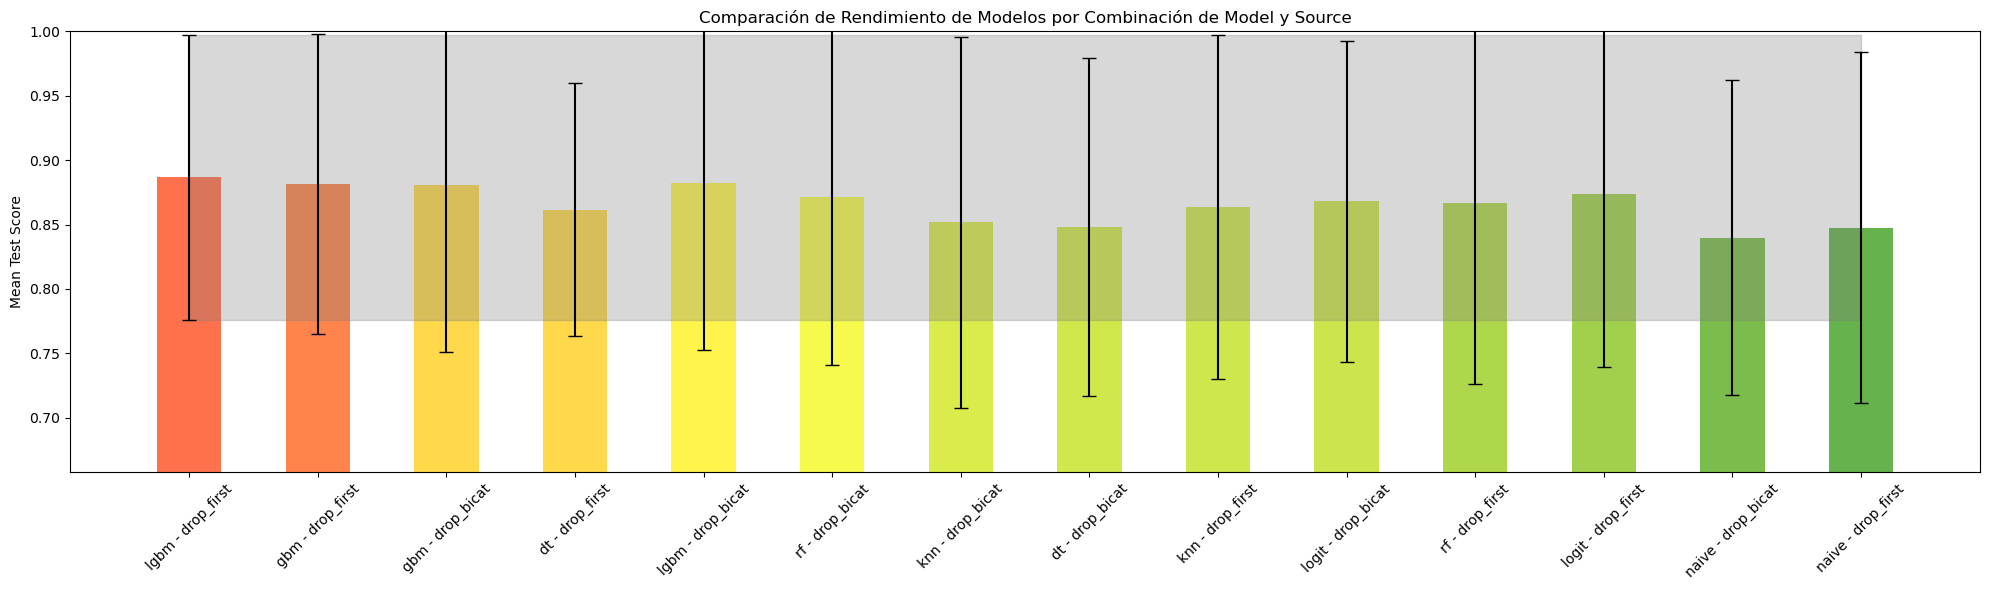

In [340]:
# Ordenar el DataFrame por el valor p creciente
results_df_sorted = results_df.sort_values(by='p_value')

# Crear el gráfico de barras
plt.figure(figsize=(20, 6))  # Ajustar el tamaño de la figura
bar_width = 0.5  # Ajuste del ancho de las barras

# Obtener todas las combinaciones únicas de 'model' y 'source'
combinations = results_df_sorted[['model', 'source']].drop_duplicates()

# Inicializar posición base
x_pos = np.arange(len(combinations))  # Número total de barras
num_combinations = len(combinations)

# Crear un colormap personalizado para los valores p (ajustado a tus indicaciones)
colors = LinearSegmentedColormap.from_list(
    "p_value_gradient", [(0, 'red'), (0.075, 'yellow'), (1, 'green')])

# Normalizar los valores p de acuerdo con el rango entre 0 y 1
norm = Normalize(vmin=0, vmax=1)

# Inicializar las variables para encontrar el máximo y mínimo
max_mean_test_score = -np.inf  # Para encontrar el mayor mean_test_score
interval_lower_test_max = None  # Para almacenar el intervalo inferior del máximo mean_test_score
interval_upper_test_max = None  # Para almacenar el intervalo superior del máximo mean_test_score
min_interval_lower_test = np.inf  # Para encontrar el menor intervalo inferior de test

# Graficar las métricas de test (mean_test_score y std_test_score)
for i, (model, source) in enumerate(combinations.values):
    # Filtrar los datos para la combinación actual de 'model' y 'source'
    filtered_df = results_df_sorted[(results_df_sorted['model'] == model) & (results_df_sorted['source'] == source)]
    
    # Obtener las métricas del modelo
    mean_test_score = filtered_df['mean_test_score'].values[0]
    test_std = filtered_df['std_test_score'].values[0] * 3  # Multiplicar la desviación estándar por 3
    p_value = filtered_df['p_value'].values[0]

    # Obtener los límites del intervalo de test
    interval_lower_test = filtered_df['interval_lower_test'].values[0]
    interval_upper_test = filtered_df['interval_upper_test'].values[0]
    
    # Actualizar el máximo y el mínimo mean_test_score, así como los límites del intervalo
    if mean_test_score > max_mean_test_score:
        max_mean_test_score = mean_test_score
        interval_lower_test_max = interval_lower_test
        interval_upper_test_max = interval_upper_test
    if interval_lower_test < min_interval_lower_test:
        min_interval_lower_test = interval_lower_test
    
    # Asignar el color basado en el valor p usando el colormap
    color = colors(norm(p_value))  # Aplicar normalización y obtener el color
    
    # Posicionar las barras
    plt.bar(x_pos[i], mean_test_score, yerr=test_std, capsize=5, 
            color=color, width=bar_width, alpha=0.7, label=f'{model} - {source}' if i == 0 else "")

# Asegurarse de que min_interval_lower_test tenga un valor válido
if min_interval_lower_test == np.inf:
    min_interval_lower_test = 0  # Si no se actualizó, asignar un valor mínimo válido

# Ajustar el límite inferior del eje Y
plt.ylim(min_interval_lower_test - 0.05, 1.0)  # Agregar un pequeño margen debajo del valor mínimo

# Añadir la banda entre interval_lower_test_max y interval_upper_test_max
if interval_lower_test_max is not None and interval_upper_test_max is not None:
    plt.fill_between(
        [0, len(combinations) - 1],  # Todo el ancho del gráfico
        interval_lower_test_max, interval_upper_test_max,
        color='gray', alpha=0.3, label=f'Intervalo de Test (Max Mean Test Score: {max_mean_test_score:.2f})'
    )

# Añadir etiquetas y título
plt.title('Comparación de Rendimiento de Modelos por Combinación de Model y Source')
plt.xticks(x_pos, [f'{model} - {source}' for model, source in combinations.values], rotation=45)
plt.ylabel('Mean Test Score')

# Mostrar el gráfico
plt.tight_layout()
plt.show()

### Evalúo el desempeño de los modelos más prometedores

In [342]:
gbm_best_params = trials_df2[trials_df2['model'] == 'gbm']['params'].iloc[0]
print(gbm_best_params)

{'n_estimators': 87, 'learning_rate': 0.0690872707181246, 'max_depth': 15, 'min_samples_split': 78, 'min_samples_leaf': 20, 'max_features': 'sqrt'}


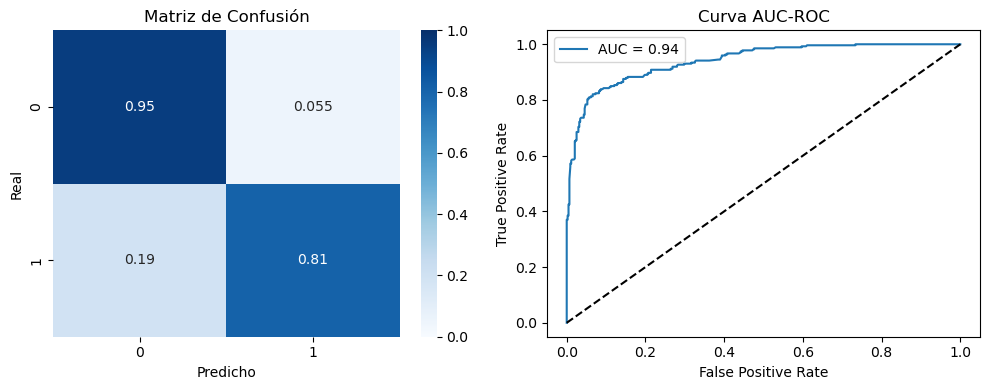

              precision    recall  f1-score   support

           0       0.89      0.95      0.92       439
           1       0.90      0.81      0.85       273

    accuracy                           0.89       712
   macro avg       0.89      0.88      0.88       712
weighted avg       0.89      0.89      0.89       712



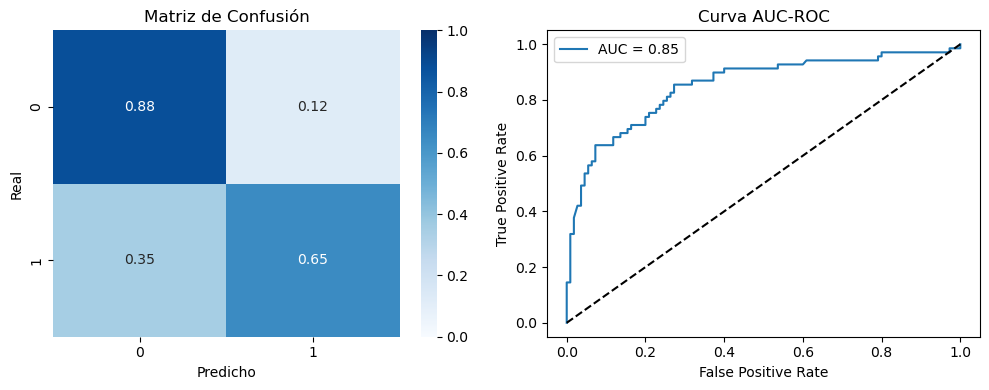

              precision    recall  f1-score   support

           0       0.80      0.88      0.84       110
           1       0.78      0.65      0.71        69

    accuracy                           0.79       179
   macro avg       0.79      0.77      0.77       179
weighted avg       0.79      0.79      0.79       179



In [343]:
gbm_classifier = GradientBoostingClassifier(**gbm_best_params)
gbm_classifier.fit(X_train_tree, y_train)
y_train_pred = gbm_classifier.predict(X = X_train_tree)
y_test_pred = gbm_classifier.predict(X = X_test_tree)
y_train_proba = gbm_classifier.predict_proba(X_train_tree)[:, 1]
y_test_proba = gbm_classifier.predict_proba(X_test_tree)[:, 1]
resultados(y_train, y_train_pred, y_train_proba)
resultados(y_test, y_test_pred, y_test_proba)

##### GradientBoostingClassifier con el conjunto X_train_tree sobreajusta 

#### Evalúo el desempeño de DecisionTreeClassifier

In [346]:
results_df[results_df['model'] == 'dt']

,model,mean_train_score,std_train_score,interval_lower_train,interval_upper_train,mean_test_score,std_test_score,interval_lower_test,interval_upper_test,overfitting_risk,p_value,source
3,dt,0.903217,0.007587,0.880457,0.925977,0.861613,0.032726,0.763436,0.959790,High,0.062407,drop_first
10,dt,0.873651,0.011818,0.838197,0.909106,0.847723,0.043743,0.716494,0.978952,Low,0.308692,drop_bicat


In [347]:
dt_best_params = trials_df1[trials_df1['model'] == 'dt']['params'].iloc[0]
print(dt_best_params)

{'max_depth': 11, 'min_samples_split': 75, 'min_samples_leaf': 10, 'criterion': 'gini'}


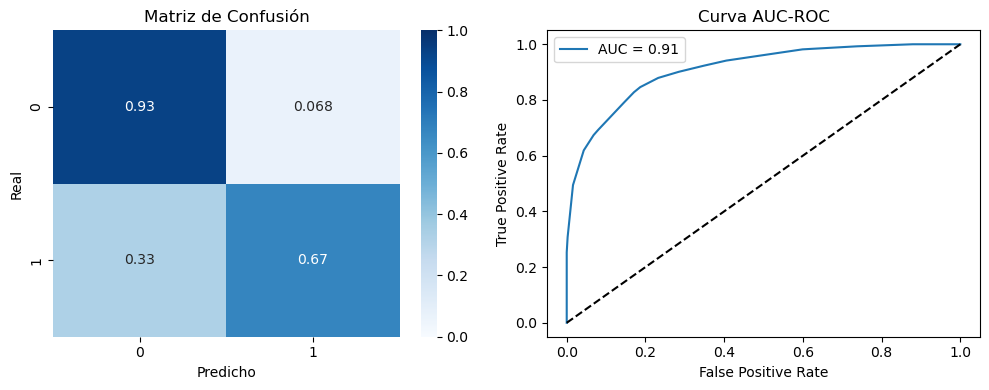

              precision    recall  f1-score   support

           0       0.82      0.93      0.87       439
           1       0.86      0.67      0.76       273

    accuracy                           0.83       712
   macro avg       0.84      0.80      0.81       712
weighted avg       0.84      0.83      0.83       712



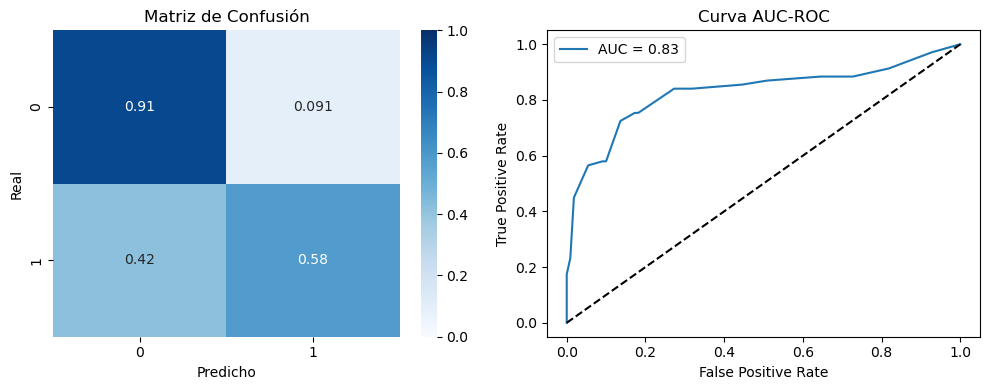

              precision    recall  f1-score   support

           0       0.78      0.91      0.84       110
           1       0.80      0.58      0.67        69

    accuracy                           0.78       179
   macro avg       0.79      0.74      0.75       179
weighted avg       0.78      0.78      0.77       179



In [348]:
dt_classifier = DecisionTreeClassifier(**dt_best_params)
dt_classifier.fit(X_train, y_train)
y_train_pred = dt_classifier.predict(X = X_train)
y_test_pred = dt_classifier.predict(X = X_test)
y_train_proba = dt_classifier.predict_proba(X_train)[:, 1]
y_test_proba = dt_classifier.predict_proba(X_test)[:, 1]
resultados(y_train, y_train_pred, y_train_proba)
resultados(y_test, y_test_pred, y_test_proba)

##### Tambien presenta sobreajuste

#### Evalúo el desempeño de LogisticRegression

In [351]:
logit_best_params = trials_df1[trials_df1['model'] == 'logit']['params'].iloc[0]
print(logit_best_params)

{'penalty': 'l2', 'C': 1.402567232832215, 'solver': 'liblinear', 'max_iter': 103}


In [352]:
logit_best_params['max_iter'] = 500
logit_best_params

{'penalty': 'l2',
 'C': 1.402567232832215,
 'solver': 'liblinear',
 'max_iter': 500}

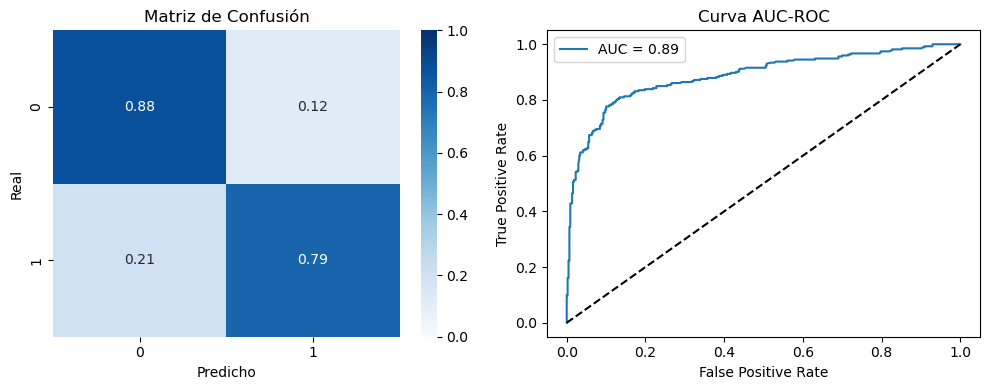

              precision    recall  f1-score   support

           0       0.87      0.88      0.88       439
           1       0.80      0.79      0.80       273

    accuracy                           0.85       712
   macro avg       0.84      0.84      0.84       712
weighted avg       0.85      0.85      0.85       712



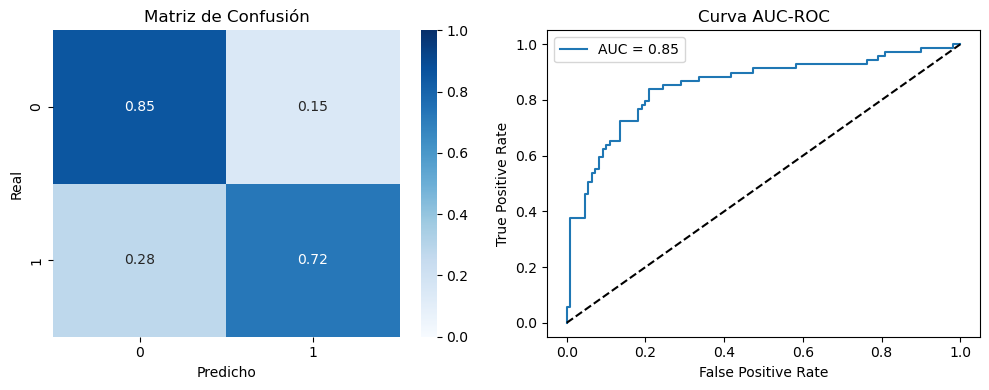

              precision    recall  f1-score   support

           0       0.83      0.85      0.84       110
           1       0.76      0.72      0.74        69

    accuracy                           0.80       179
   macro avg       0.79      0.79      0.79       179
weighted avg       0.80      0.80      0.80       179



In [353]:
logit_classifier = LogisticRegression(**logit_best_params)
logit_classifier.fit(X_train, y_train)
y_train_pred = logit_classifier.predict(X = X_train)
y_test_pred = logit_classifier.predict(X = X_test)
y_train_proba = logit_classifier.predict_proba(X_train)[:, 1]
y_test_proba = logit_classifier.predict_proba(X_test)[:, 1]
resultados(y_train, y_train_pred, y_train_proba)
resultados(y_test, y_test_pred, y_test_proba)

#### Evalúo el desempeño de GaussianNB

In [355]:
naive_best_params = trials_df1[trials_df1['model'] == 'naive']['params'].iloc[0]
print(naive_best_params)

{'var_smoothing': 0.9995914941610888}


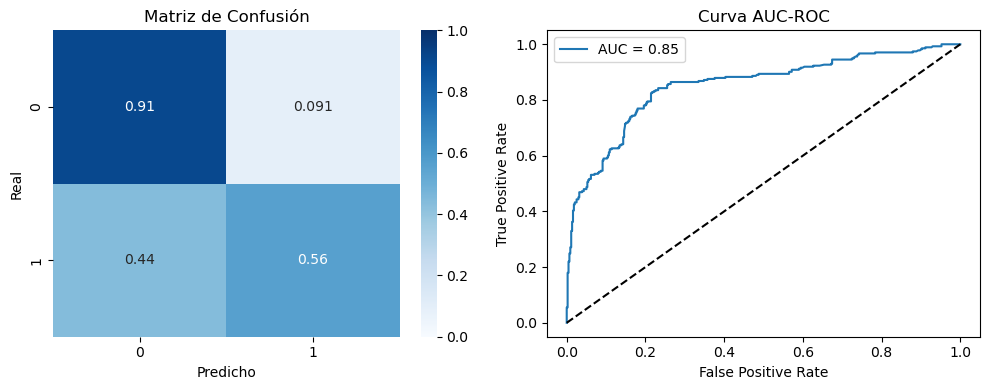

              precision    recall  f1-score   support

           0       0.77      0.91      0.83       439
           1       0.79      0.56      0.66       273

    accuracy                           0.78       712
   macro avg       0.78      0.73      0.74       712
weighted avg       0.78      0.78      0.77       712



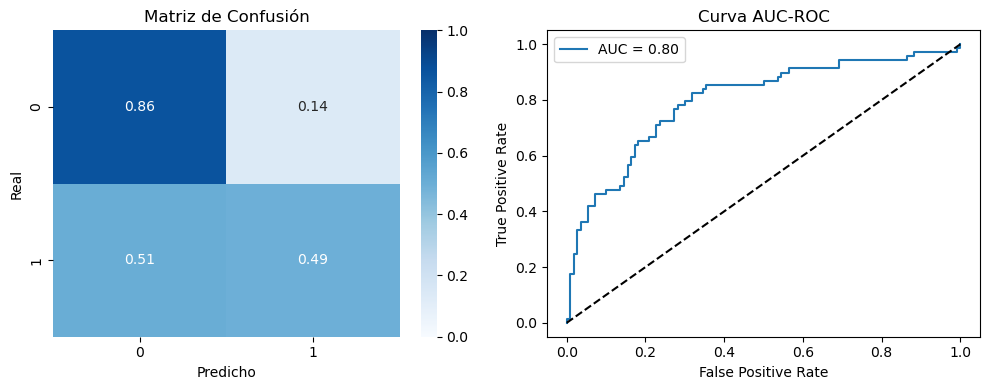

              precision    recall  f1-score   support

           0       0.73      0.86      0.79       110
           1       0.69      0.49      0.58        69

    accuracy                           0.72       179
   macro avg       0.71      0.68      0.68       179
weighted avg       0.72      0.72      0.71       179



In [356]:
naive_classifier = GaussianNB(**naive_best_params)
naive_classifier.fit(X_train, y_train)
y_train_pred = naive_classifier.predict(X = X_train)
y_test_pred = naive_classifier.predict(X = X_test)
y_train_proba = naive_classifier.predict_proba(X_train)[:, 1]
y_test_proba = naive_classifier.predict_proba(X_test)[:, 1]
resultados(y_train, y_train_pred, y_train_proba)
resultados(y_test, y_test_pred, y_test_proba)

#### Evalúo el desempeño de LGBMClassifier

In [358]:
lgbm_best_params = trials_df2[trials_df2['model'] == 'lgbm']['params'].iloc[0]
lgbm_best_params['verbose'] = -1
print(lgbm_best_params)

{'num_leaves': 26, 'max_depth': 2, 'learning_rate': 0.04216755094796287, 'n_estimators': 655, 'min_child_samples': 48, 'min_child_weight': 2.4526886355349785e-05, 'subsample': 0.521277765257744, 'colsample_bytree': 0.9954832800399598, 'reg_alpha': 0.6877918218311383, 'reg_lambda': 0.12166983023336694, 'verbose': -1}


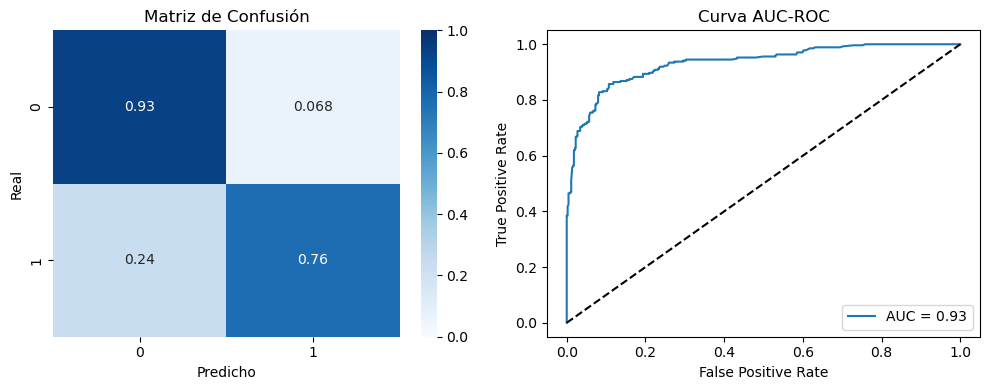

              precision    recall  f1-score   support

           0       0.86      0.93      0.90       439
           1       0.87      0.76      0.81       273

    accuracy                           0.87       712
   macro avg       0.87      0.85      0.86       712
weighted avg       0.87      0.87      0.86       712



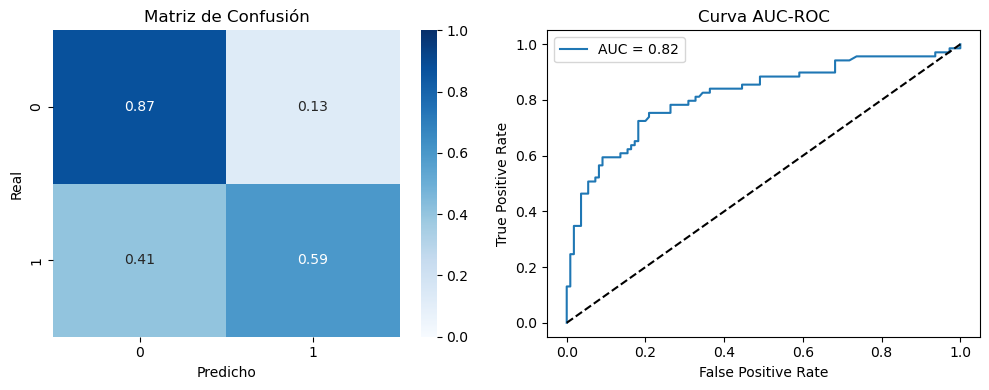

              precision    recall  f1-score   support

           0       0.77      0.87      0.82       110
           1       0.75      0.59      0.66        69

    accuracy                           0.77       179
   macro avg       0.76      0.73      0.74       179
weighted avg       0.76      0.77      0.76       179



In [359]:
lgbm_classifier = lgb.LGBMClassifier(**lgbm_best_params)
lgbm_classifier.fit(X_train_tree, y_train)
y_train_pred = lgbm_classifier.predict(X = X_train_tree)
y_test_pred = lgbm_classifier.predict(X = X_test_tree)
y_train_proba = lgbm_classifier.predict_proba(X_train_tree)[:, 1]
y_test_proba = lgbm_classifier.predict_proba(X_test_tree)[:, 1]
resultados(y_train, y_train_pred, y_train_proba)
resultados(y_test, y_test_pred, y_test_proba)

##### Analizo si agregando el parametro 'class_weight': 'balanced' obtengo mejores resultados

In [361]:
lgbm_best_params['random_state'] = 42
lgbm_best_params['class_weight'] = 'balanced'
print(lgbm_best_params)

{'num_leaves': 26, 'max_depth': 2, 'learning_rate': 0.04216755094796287, 'n_estimators': 655, 'min_child_samples': 48, 'min_child_weight': 2.4526886355349785e-05, 'subsample': 0.521277765257744, 'colsample_bytree': 0.9954832800399598, 'reg_alpha': 0.6877918218311383, 'reg_lambda': 0.12166983023336694, 'verbose': -1, 'random_state': 42, 'class_weight': 'balanced'}


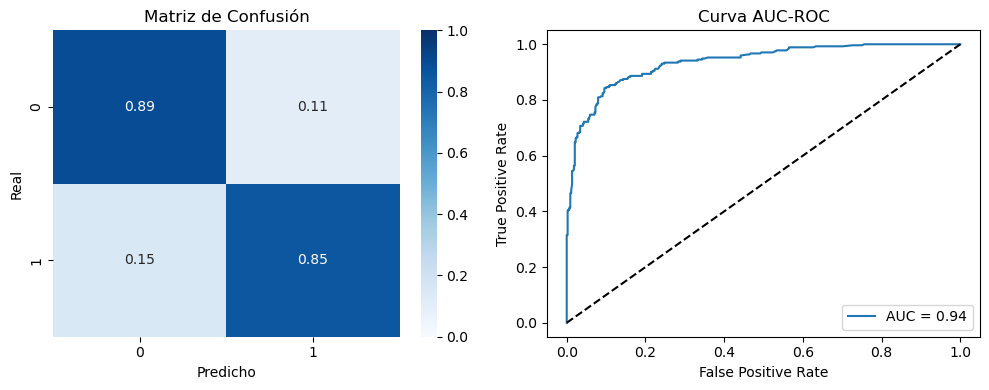

              precision    recall  f1-score   support

           0       0.91      0.89      0.90       439
           1       0.83      0.85      0.84       273

    accuracy                           0.88       712
   macro avg       0.87      0.87      0.87       712
weighted avg       0.88      0.88      0.88       712



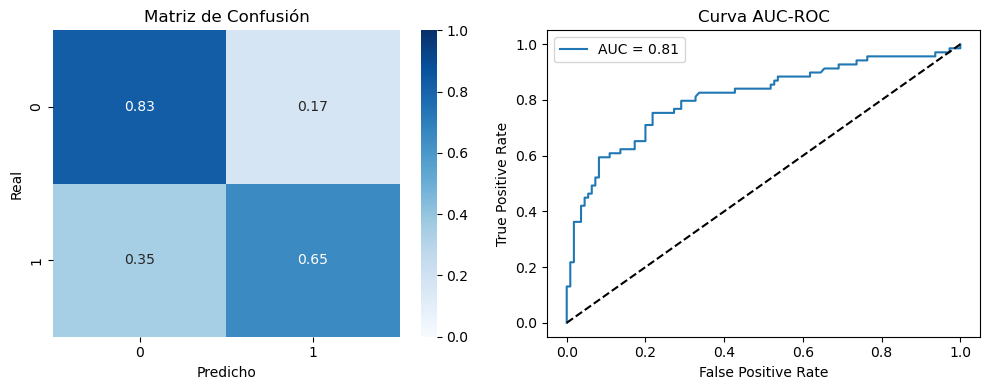

              precision    recall  f1-score   support

           0       0.79      0.83      0.81       110
           1       0.70      0.65      0.68        69

    accuracy                           0.76       179
   macro avg       0.75      0.74      0.74       179
weighted avg       0.76      0.76      0.76       179



In [362]:
lgbm_classifier = lgb.LGBMClassifier(**lgbm_best_params)
lgbm_classifier.fit(X_train_tree, y_train)
y_train_pred = lgbm_classifier.predict(X = X_train_tree)
y_test_pred = lgbm_classifier.predict(X = X_test_tree)
y_train_proba = lgbm_classifier.predict_proba(X_train_tree)[:, 1]
y_test_proba = lgbm_classifier.predict_proba(X_test_tree)[:, 1]
resultados(y_train, y_train_pred, y_train_proba)
resultados(y_test, y_test_pred, y_test_proba)

### Modelo final

Los siguientes parámetros se obtuvieron mediante una búsqueda aleatoria con Optuna en una corrida que no se dejó registro. Esto resalta la naturaleza aleatoria de la búsqueda del mejor conjunto de parámetros para un modelo determinado. Además, indica que al utilizar TPE, Optuna pudo haberse detenido en un máximo local en lugar de alcanzar el máximo global.

Sin embargo, las métricas de la mayoría de los modelos evaluados se ubicaron dentro de sus respectivos intervalos de confianza, calculados a partir de la validación cruzada en el conjunto de entrenamiento. Por lo tanto, no se puede concluir que estos modelos estén sobreajustando

In [365]:
modelo_final = LogisticRegression(
            penalty = 'l2',
            C = 2.5821196041782692,
            solver = 'saga',
            max_iter = 226
        )

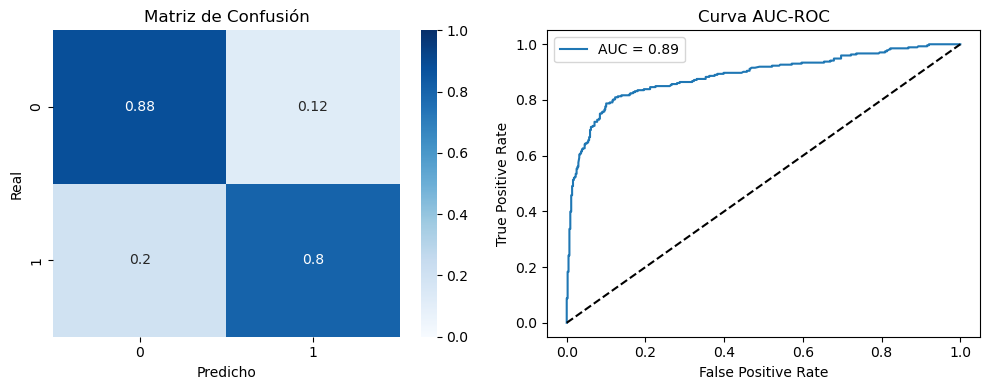

              precision    recall  f1-score   support

           0       0.88      0.88      0.88       439
           1       0.81      0.80      0.80       273

    accuracy                           0.85       712
   macro avg       0.84      0.84      0.84       712
weighted avg       0.85      0.85      0.85       712



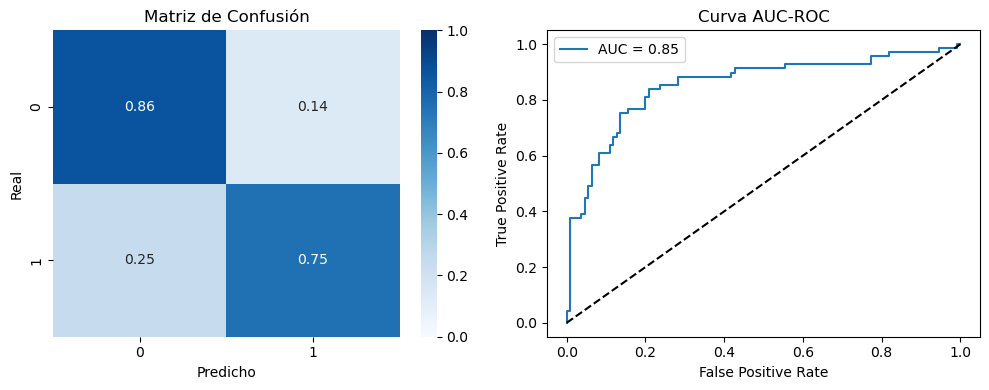

              precision    recall  f1-score   support

           0       0.85      0.86      0.86       110
           1       0.78      0.75      0.76        69

    accuracy                           0.82       179
   macro avg       0.81      0.81      0.81       179
weighted avg       0.82      0.82      0.82       179



In [366]:
modelo_final.fit(X_train, y_train)
y_train_pred = modelo_final.predict(X = X_train)
y_test_pred = modelo_final.predict(X = X_test)
y_train_proba = modelo_final.predict_proba(X_train)[:, 1]
y_test_proba = modelo_final.predict_proba(X_test)[:, 1]
resultados(y_train, y_train_pred, y_train_proba)
resultados(y_test, y_test_pred, y_test_proba)

### Desempeño del modelo final

In [368]:
def resultados_clasificacion_cv(model, X, y, cv=5, include_auc_roc=False):
    """
    Esta función evalúa el rendimiento de un modelo de clasificación bivariada utilizando
    varias métricas: accuracy, precision, recall, f1-score, y opcionalmente auc-roc, con 
    validación cruzada (CV). Devuelve un DataFrame con los resultados de las métricas, 
    sus medias, desviaciones estándar y los intervalos de confianza al 95%.
    
    Parámetros:
    - model: el modelo de clasificación a evaluar.
    - X: array-like, características del modelo (conjunto de entrenamiento).
    - y: array-like, valores verdaderos de las etiquetas (valores reales).
    - cv: número de pliegues para la validación cruzada (default es 5).
    - include_auc_roc: booleano, si se debe incluir la métrica AUC-ROC (default es False).
    
    Retorna:
    - df_resultados: DataFrame con las métricas y sus estadísticas.
    """
    
    # Asegurarse de que y sea un pandas Series con el mismo índice que X
    if isinstance(y, np.ndarray):
        y = pd.Series(y, index=X.index)  # Convertir y a pandas Series si es un array
    
    # Inicializar el objeto KFold para cross-validation
    kf = KFold(n_splits=cv, shuffle=True, random_state=42)
    
    # Listas para almacenar los resultados de cada pliegue
    accuracy_scores = []
    precision_scores = []
    recall_scores = []
    f1_scores = []
    auc_roc_scores = []  # Solo se agregará si include_auc_roc es True
    
    for train_idx, test_idx in kf.split(X):
        # Usar .iloc para indexar correctamente las filas
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        # Entrenar el modelo
        model.fit(X_train, y_train)
        
        # Predecir con el modelo
        y_pred = model.predict(X_test)
        
        # Calcular las métricas
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        
        # AUC-ROC solo si se solicita
        if include_auc_roc:
            auc_roc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])  # Suponiendo clasificación binaria
            auc_roc_scores.append(auc_roc)
        
        # Guardar las métricas de este pliegue
        accuracy_scores.append(accuracy)
        precision_scores.append(precision)
        recall_scores.append(recall)
        f1_scores.append(f1)
    
    # Calcular las medias y desviaciones estándar
    accuracy_mean = np.mean(accuracy_scores)
    accuracy_std = np.std(accuracy_scores)
    precision_mean = np.mean(precision_scores)
    precision_std = np.std(precision_scores)
    recall_mean = np.mean(recall_scores)
    recall_std = np.std(recall_scores)
    f1_mean = np.mean(f1_scores)
    f1_std = np.std(f1_scores)
    
    # Calcular intervalos de confianza al 95% (usando una distribución t-student)
    ci_accuracy = stats.t.interval(0.95, len(accuracy_scores)-1, loc=accuracy_mean, scale=accuracy_std/np.sqrt(len(accuracy_scores)))
    ci_precision = stats.t.interval(0.95, len(precision_scores)-1, loc=precision_mean, scale=precision_std/np.sqrt(len(precision_scores)))
    ci_recall = stats.t.interval(0.95, len(recall_scores)-1, loc=recall_mean, scale=recall_std/np.sqrt(len(recall_scores)))
    ci_f1 = stats.t.interval(0.95, len(f1_scores)-1, loc=f1_mean, scale=f1_std/np.sqrt(len(f1_scores)))
    
    # AUC-ROC intervalo de confianza si está incluido
    ci_auc_roc = (None, None)
    if include_auc_roc and auc_roc_scores:
        auc_roc_mean = np.mean(auc_roc_scores)
        auc_roc_std = np.std(auc_roc_scores)
        ci_auc_roc = stats.t.interval(0.95, len(auc_roc_scores)-1, loc=auc_roc_mean, scale=auc_roc_std/np.sqrt(len(auc_roc_scores)))
    
    # Crear el DataFrame de resultados
    data = {
        "Metric": ["Accuracy", "Precision", "Recall", "F1-Score", "AUC-ROC" if include_auc_roc else ""],
        "Mean": [accuracy_mean, precision_mean, recall_mean, f1_mean, auc_roc_mean if include_auc_roc else None],
        "Std": [accuracy_std, precision_std, recall_std, f1_std, auc_roc_std if include_auc_roc else None],
        "Confidence Interval Lower": [ci_accuracy[0], ci_precision[0], ci_recall[0], ci_f1[0], ci_auc_roc[0] if include_auc_roc else None],
        "Confidence Interval Upper": [ci_accuracy[1], ci_precision[1], ci_recall[1], ci_f1[1], ci_auc_roc[1] if include_auc_roc else None]
    }
    
    # Eliminar la columna AUC-ROC si no se incluyó
    if not include_auc_roc:
        del data["Metric"][-1]
        del data["Mean"][-1]
        del data["Std"][-1]
        del data["Confidence Interval Lower"][-1]
        del data["Confidence Interval Upper"][-1]
    
    df_resultados = pd.DataFrame(data)
    
    return df_resultados

In [369]:
df_resultados = resultados_clasificacion_cv(modelo_final, X_train, y_train, include_auc_roc = True)
df_resultados

,Metric,Mean,Std,Confidence Interval Lower,Confidence Interval Upper
0,Accuracy,0.832926,0.045246,0.776746,0.889106
1,Precision,0.785407,0.080815,0.685062,0.885752
2,Recall,0.784582,0.051888,0.720155,0.849010
3,F1-Score,0.783294,0.056621,0.712990,0.853598
4,AUC-ROC,0.871162,0.045700,0.814418,0.927906


- **Accuracy (Precisión Global)**: se encuentra entre [0.776746, 0.889106] con un 95% de confianza. Es decir que, el modelo tiene una tasa de predicciones correctas que varía entre el 77.67% y el 88.91%. En el peor de los casos el accuracy no debería ser menor a 77.67%.
- Precision (Precisión): se encuentra entre [0.685062, 0.885752], lo que indica que cuando el modelo predice una clase positiva, la probabilidad de que la predicción sea correcta se encuentra entre 68.50% y 88.57%, un rango que puede parecer significativo.
- Recall (Recuperación o Sensibilidad): se encuentra entre [0.720155, 0.849010], indicando que tiene una buena desempeño de entre 72.01% y 84.90% para identificar correctamente las instancias positivas. 
- F1-Score (Puntaje F1): se encuentra entre [0.712990, 0.853598] esto sugiere que el balance entre precisión y recall se encuentra entre el 71.30% y 85.36%. Cuanto más cercano a 1 esté el F1-Score, mejor será el rendimiento del modelo en términos de equilibrio entre precisión y recall. Este es un buen indicador cuando el objetivo es optimizar ambos aspectos de las predicciones (evitar falsos positivos y falsos negativos) 
- AUC-ROC (Área bajo la curva ROC): se encuentra entre [0.814418, 0.927906], lo que implica que el modelo tiene un rendimiento de 81.44% a 92.79% para discriminar entre las clases positivas y negativas.

### Pipeline final

In [372]:
titanic_pipeline = Pipeline([
    ('title_extractor', TitleExtractor(name_column='Name', title_column='Title')),
    ('is_alone_extractor', IsAloneFeatureExtractor(sibsp_column='SibSp', parch_column='Parch', is_alone_column='IsAlone')),
    ('cabin_category_extractor', CabinCategoryExtractor(cabin_column='Cabin', category_column='Cabin_cat')),
    ('cabin_number_extractor', CabinNumberExtractor(cabin_column='Cabin', number_column='Cabin_num')),
    ('drop_features', DropFeatures(features_to_drop=['Name', 'Cabin', 'Ticket', 'PassengerId'])),
    ('impute_cabin_cat', CategoricalImputer(imputation_method="missing", fill_value="Missing", variables=['Cabin_cat'])),
    ('impute_cabin_num', CategoricalImputer(imputation_method="missing", fill_value="0", variables=['Cabin_num'])),
    ('impute_embarked', CategoricalImputer(imputation_method="frequent", variables=['Embarked'])),
    ('dtype_fisrt_converter', DType_first_Converter()),
    ('cabin_recategorizer', CabinRecategorizer()),
    ('drop_Cabin_cat', DropFeatures(features_to_drop=['Cabin_cat'])),
    ('cabin_discretiser', CustomCabinNumDiscretiser()),
    ('cabin_num_mapper', CabinNumMapper()),
    ('rare_encoder', RareLabelEncoder(tol=0.04, n_categories=4, variables=["Title"], replace_with='Rare_Title')),
    ('family_discretiser', CustomDiscretiser()),    
    ('family_mapper', FamilySizeMapper()), 
    ('custom_onehot_encoder', CustomOneHotEncoder_drop_first()),   
    ('fare_zero_transformer', FareZeroTransformer()),
    ('fare_replacement', FareReplacementTransformer()),
    ('boxcox_transformer', BoxCoxTransformer(variables=['Fare'])),
    ('mice_imputer', MICEImputer(max_iter=20, random_state=0)), 
    ('outlier_adjustment', OutlierAdjuster(variables=['Fare', 'Age'])),
    ('scaler', CustomMinMaxScaler(features=['Age', 'Fare'])),
    ('model', modelo_final)
]) 

### Verifico que el modelo final tenga el mismo desempeño que el modelo seleccionado

In [374]:
X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split( X,y,test_size = 0.2,random_state = 42, stratify=y)

In [375]:
y_train_raw = y_train_raw.values.flatten()
y_test_raw = y_test_raw.values.flatten()

In [376]:
# Entrenar el pipeline completo
titanic_pipeline.fit(X_train_raw, y_train_raw)

Pipeline(steps=[('title_extractor', TitleExtractor()),
                ('is_alone_extractor', IsAloneFeatureExtractor()),
                ('cabin_category_extractor', CabinCategoryExtractor()),
                ('cabin_number_extractor', CabinNumberExtractor()),
                ('drop_features',
                 DropFeatures(features_to_drop=['Name', 'Cabin', 'Ticket',
                                                'PassengerId'])),
                ('impute_cabin_cat',
                 CategoricalImputer(variables=['Cabi...
                ('fare_zero_transformer', FareZeroTransformer()),
                ('fare_replacement', FareReplacementTransformer()),
                ('boxcox_transformer', BoxCoxTransformer(variables=['Fare'])),
                ('mice_imputer', MICEImputer()),
                ('outlier_adjustment',
                 OutlierAdjuster(variables=['Fare', 'Age'])),
                ('scaler', CustomMinMaxScaler(features=['Age', 'Fare'])),
                ('model',
                 LogisticRegression(C=2.5821196041782692, max_iter=226,
                                    solver='saga'))])

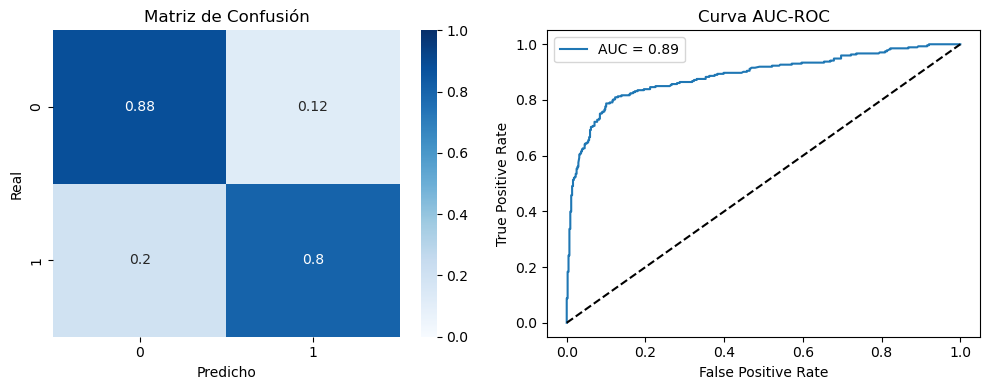

              precision    recall  f1-score   support

           0       0.88      0.88      0.88       439
           1       0.81      0.80      0.80       273

    accuracy                           0.85       712
   macro avg       0.84      0.84      0.84       712
weighted avg       0.85      0.85      0.85       712



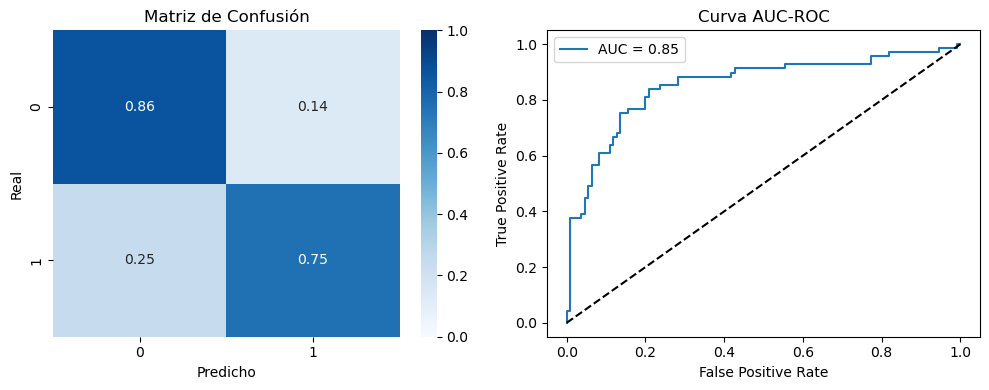

              precision    recall  f1-score   support

           0       0.85      0.86      0.86       110
           1       0.78      0.75      0.76        69

    accuracy                           0.82       179
   macro avg       0.81      0.81      0.81       179
weighted avg       0.82      0.82      0.82       179



In [377]:
y_train_pred = titanic_pipeline.predict(X = X_train_raw)
y_test_pred = titanic_pipeline.predict(X_test_raw)
y_train_proba = titanic_pipeline.predict_proba(X_train_raw)[:, 1]
y_test_proba = titanic_pipeline.predict_proba(X_test_raw)[:, 1]
resultados(y_train_raw, y_train_pred, y_train_proba)
resultados(y_test_raw, y_test_pred, y_test_proba)

## Guardo el modelo final

In [379]:
import joblib

In [380]:
joblib.dump(titanic_pipeline, 'titanic_pipeline.joblib')

['titanic_pipeline.joblib']

### Cargo el modelo y verifico su funcionamiento

In [382]:
loaded_model = joblib.load('titanic_pipeline.joblib')

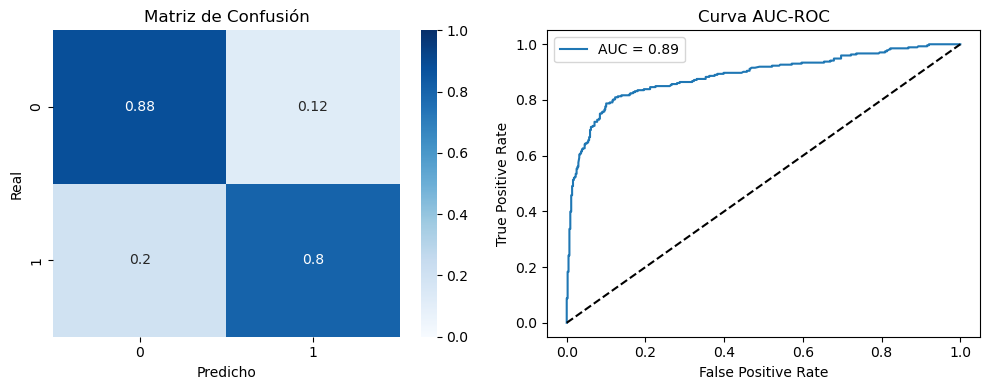

              precision    recall  f1-score   support

           0       0.88      0.88      0.88       439
           1       0.81      0.80      0.80       273

    accuracy                           0.85       712
   macro avg       0.84      0.84      0.84       712
weighted avg       0.85      0.85      0.85       712



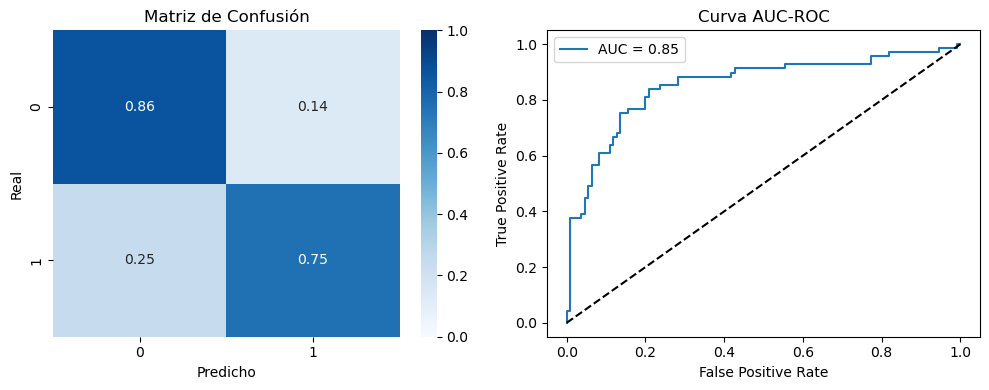

              precision    recall  f1-score   support

           0       0.85      0.86      0.86       110
           1       0.78      0.75      0.76        69

    accuracy                           0.82       179
   macro avg       0.81      0.81      0.81       179
weighted avg       0.82      0.82      0.82       179



In [383]:
y_train_pred = loaded_model.predict(X = X_train_raw)
y_test_pred = loaded_model.predict(X_test_raw)
y_train_proba = loaded_model.predict_proba(X_train_raw)[:, 1]
y_test_proba = loaded_model.predict_proba(X_test_raw)[:, 1]
resultados(y_train_raw, y_train_pred, y_train_proba)
resultados(y_test_raw, y_test_pred, y_test_proba)